Environment versions:
Keras 2.12.0
Matplotlib 3.7.1
Numpy 1.23.5
Pandas 1.5.3
Python 3.11.3
Seaborn 0.12.2
Sklearn 1.2.2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, recall_score, davies_bouldin_score, silhouette_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop, Adagrad, Adadelta
from keras.regularizers import l1, l2, l1_l2
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth

In [2]:
#Read in csv as df
df = pd.read_csv('car_sales_data.csv')
df

Manufacturer       Model  Engine size Fuel type  Year of manufacture  \
0             Ford      Fiesta          1.0    Petrol                 2002   
1          Porsche  718 Cayman          4.0    Petrol                 2016   
2             Ford      Mondeo          1.6    Diesel                 2014   
3           Toyota        RAV4          1.8    Hybrid                 1988   
4               VW        Polo          1.0    Petrol                 2006   
...            ...         ...          ...       ...                  ...   
49995          BMW          M5          5.0    Petrol                 2018   
49996       Toyota       Prius          1.8    Hybrid                 2003   
49997         Ford      Mondeo          1.6    Diesel                 2022   
49998         Ford       Focus          1.0    Diesel                 2016   
49999           VW        Golf          1.4    Diesel                 2012   

       Mileage   Price  
0       127300    3074  
1        57850   49704  
2        39190   24072  
3       210814    1705  
4       127869    4101  
...        ...     ...  
49995    28664  113006  
49996   105120    9430  
49997     4030   49852  
49998    26468   23630  
49999   109300   10400  

[50000 rows x 7 columns]

**Objectives are to explore how:**

-supervised learning models can be used to predict the price of a second hand car. 

-unsupervised learning techniques can be used to identify clustering patterns in this dataset.

In [3]:
#Update column name Price to Price (GBP)
df.rename(columns={'Price': 'Price (GBP)', 'Engine size': 'Engine size (litres)'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Manufacturer          50000 non-null  object 
 1   Model                 50000 non-null  object 
 2   Engine size (litres)  50000 non-null  float64
 3   Fuel type             50000 non-null  object 
 4   Year of manufacture   50000 non-null  int64  
 5   Mileage               50000 non-null  int64  
 6   Price (GBP)           50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB


**Exploratory Data Analysis**

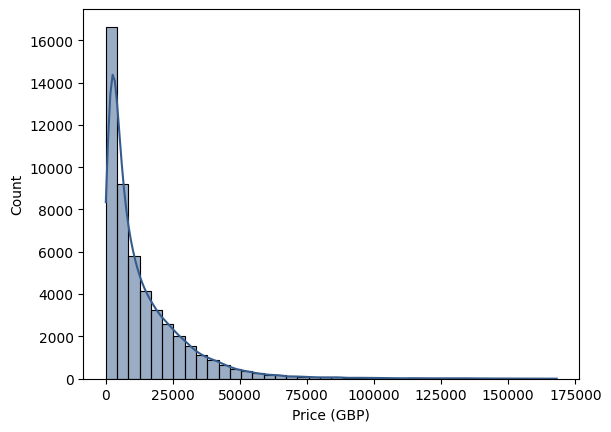

In [4]:
#Plot histogram of car price
price_frequency = sns.histplot(df['Price (GBP)'], bins=40, kde=True, color=sns.color_palette('viridis')[1])

Price ranges upp to around £170000, with most cars at the lower price points.

*Determine how salary varies with numerical variables engine size, year of manufacture and mileage.*

*Create scatter plots of salary vs each of these variables.*

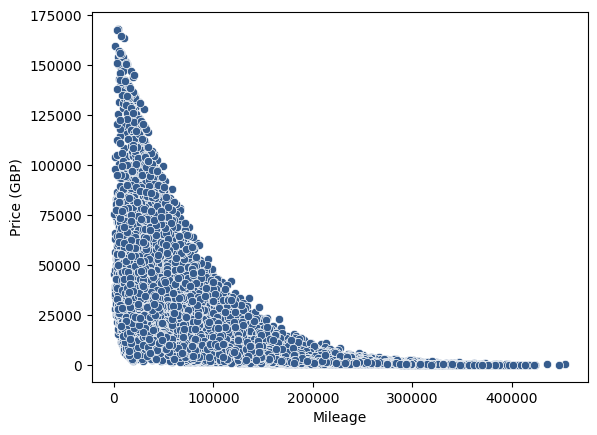

In [5]:
#Price (GBP) versus mileage
#A plot of price (GBP) (y-axis) versus mileage (x-axis)
price_mileage = sns.scatterplot(data=df, x='Mileage', y='Price (GBP)', color=sns.color_palette('viridis')[1])

General trend observed as mileage increases, price decreases. However, there is a wide range/variability of prices for cars, particularly at lower mileages, which may make fitting a linear or polynomial model difficult.

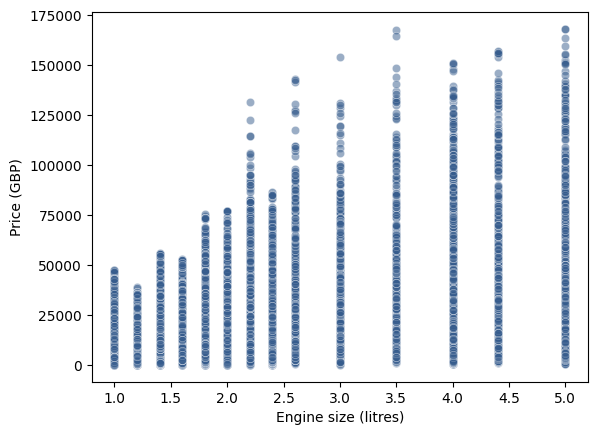

In [6]:
#Price (GBP) versus engine size (litres)
#A plot of price (GBP) (y-axis) versus engine size (litres) (x-axis)
#alpha sets transparency of points to observe those overlapping
price_engine = sns.scatterplot(x='Engine size (litres)', y='Price (GBP)', data=df, alpha=0.5, color=sns.color_palette('viridis')[1])

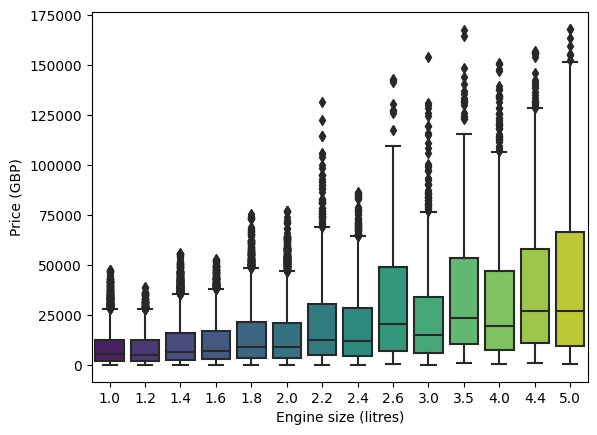

In [7]:
#Price (GBP) versus engine size (litres) in box plot
price_engine_boxplot = sns.boxplot(x='Engine size (litres)', y='Price (GBP)', data=df, palette='viridis')

Trend observed as engine size increases, price increases. However, increased price range for cars with larger engine size, indicating the relationship is probably non-linear.

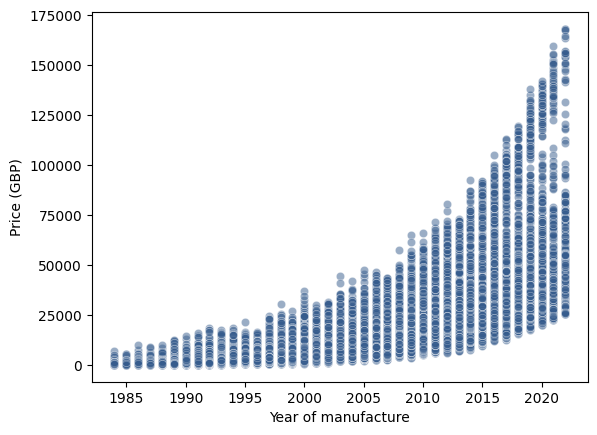

In [8]:
#Price (GBP) versus year of manufacture
#A plot of price (GBP) (y-axis) versus year of manufacture (x-axis)
price_year = sns.scatterplot(x='Year of manufacture', y='Price (GBP)', data=df, alpha=0.5, color=sns.color_palette('viridis')[1])

Trend observed where the newer the car, the price increases. High variability in price for each year of manufacture. This plot indicates the correlation may be non-linear.

Determine strength of trends by visualising correlation coefficients in heat map.

Reference: 

W3 Schools (n. d.) Data science - statistics correlation matrix. Available online: https://www.w3schools.com/datascience/ds_stat_correlation_matrix.asp [Accessed 11/12/2023].

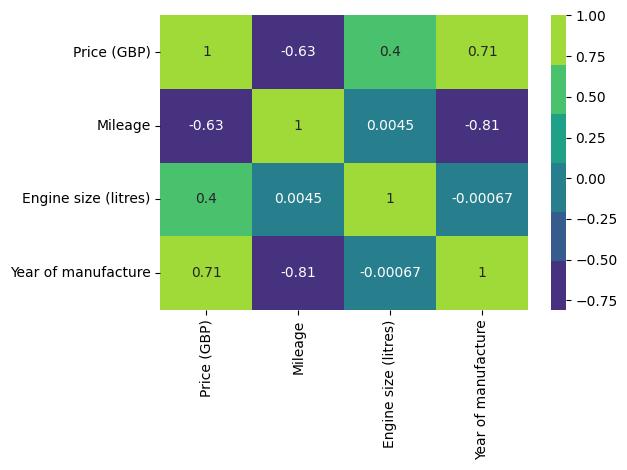

In [14]:
#Define variable to calculate the correlation coefficients
column_list = ['Price (GBP)', 'Mileage', 'Engine size (litres)', 'Year of manufacture']

#Set the color palette to Viridis
viridis_palette = sns.color_palette('viridis')

#Calculate the correlation coefficients, and then plot them using sns heatmap() function
correlation_coefficients = sns.heatmap(df[column_list].corr(), annot=True, cmap=viridis_palette)

#Tighten layout
plt.tight_layout()

Positive values indicate positive correlations, whilst negative values indicate negative correlations, and the closer the magnitude of the coefficient is to 1 the stronger the correlation.

The strongest correlation with price (GBP) is year of manufacture (0.71), followed by mileage (-0.63) and then engine size (litres) (0.4).

The strongest correlation between all numerical values in df is between year of manufacture and mileage (-0.81).

*Comparing numerical price (GBP) with non-numerical data (categorical)*

Compare distribution of price (GBP) also by fuel type and manufacturer (non-numerical values) using box plots.

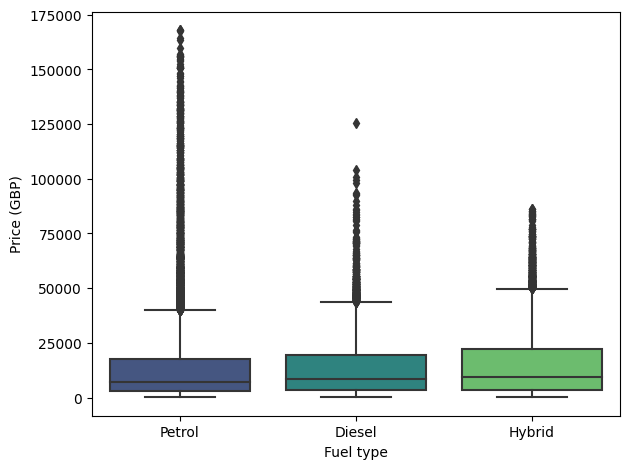

In [9]:
#Price (GBP) versus fuel type in box plot
#Create the boxplot
price_fuel = sns.boxplot(x='Fuel type', y='Price (GBP)', data=df, palette='viridis')

#Tighten layout
plt.tight_layout()

#Show the plot
plt.show()

Median price is similar across the fuel types with similar ranges but distribution of prices for petrol cars in partiulcar has outliers up to the greatest car price in the data.

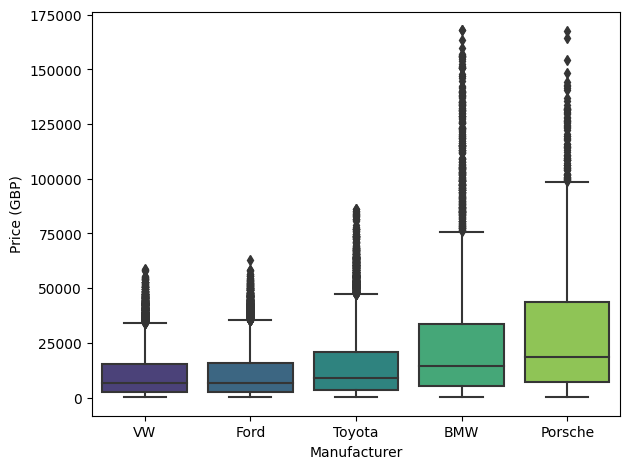

In [13]:
#Price (GBP) versus manufacturer in box plot
#Sort manufacturers by increasing median
median_order = df.groupby('Manufacturer')['Price (GBP)'].median().sort_values().index

#Create the boxplot with specified order
price_manufacturer = sns.boxplot(x='Manufacturer', y='Price (GBP)', data=df, palette='viridis', order=median_order)

#Tighten layout
plt.tight_layout()

#Show the plot
plt.show()

BMW and Porsche manufactured cars have higher median prices, wider range of prices, and higher value outliers.

**Supervised ML (regression) models**

Reference: 

Scikit learn (n. d.) Supervised learning. Available online: https://scikit-learn.org/stable/supervised_learning.html [Accessed 11/12/2023].

Compare regression models that predict the price of a car based on a single numerical input feature. 

- Determine which numerical variable in the dataset is the best predictor for a car’s price, and provide justification 

- Determine for each numerical input feature, whether a linear or non-linear (e.g. polynomial) model is the best fit.

**Simple Linear Regression Model**

Reference: 

W3 Schools (n. d.) Machine learning - linear regression. Available online: https://www.w3schools.com/python/python_ml_linear_regression.asp [Accessed 11/12/2023].

*Predict price (GBP) vs year of manufacture*

In [4]:
#Extract the feature that we will use for the input variable (year of manufacture), and the feature that we want to use as the output variable that the model will predict (Price (GBP)).
#Extract the input feature
x_year = df['Year of manufacture']

#Extract the output feature
y = df['Price (GBP)']

Gradient: 11715.46
Intercept: 13825.71
Mean Absolute Error: 7031.04
Mean Squared Error: 132678999.95
Root Mean Squared Error: 11518.64
R2 Score: 0.5111


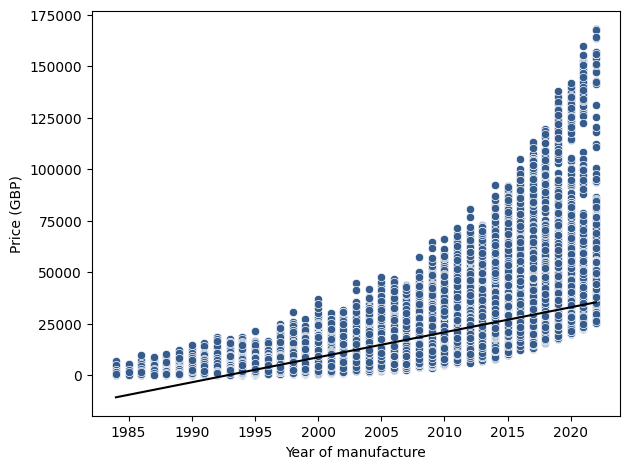

In [21]:
#Create linear regression function to model, fit, evalute and plot regression
def linear_regression(data, x, y, x_name, y_name):
    """
    Perform linear regression on the given data and plot a scatter plot with the best-fit line.

    Parameters:
    x (pandas.Series): The input feature.
    y (pandas.Series): The target variable.
    x_name (str): The series name for the x-axis in the scatter plot.
    y_name (str): The series name for the y-axis in the scatter plot.

    Returns:
    model (sklearn.linear_model.LinearRegression): Trained Linear Regression model.
    fig (matplotlib.figure.Figure): Matplotlib figure.
    """
    #The sklearn models expect the input, x, to be in the form of a 2-dimensional array
    #However, only a single input feature the result is 1-dimensional
    #Convert x to numpy array and reshape to a 2-dimensional array
    x = x.to_numpy().reshape(-1, 1)

    #Split the data into training and testing sets
    #from sklearn.model_selection import train_test_split
    #Split the x and y arrays between the train (80%) and test sets (20%)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    #Standardize the data
    #Important to scale the data to acount for different ranges (imporatn when have multiple numerical inputs)
    #Import the StandardScaler class from sklearn
    #from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    #Fit the standard scaler to x. This will find the mean and standard deviation in x, using the whole dataset
    scaler.fit(x)
    #Apply the standard scaler transformation to both the training and the testing sets
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    #Create and train a linear regression model
    #Import the LinearRegression model from sklearn
    #from sklearn.linear_model import LinearRegression
    #Create an instance of the model
    model = LinearRegression()
    model.fit(x_train_scaled, y_train)
    
    #Get the fit coefficients from the best-fit model
    gradient = model.coef_[0]
    intercept = model.intercept_

    print(f"Gradient: {gradient:.2f}")
    print(f"Intercept: {intercept:.2f}")

    #Fit the model to the training data
    y_pred = model.predict(x_test_scaled)

    #Evaluate the model
    mean_abs = mean_absolute_error(y_test, y_pred)
    mean_squared = mean_squared_error(y_test, y_pred)
    rms_error = np.sqrt(mean_squared)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error: {mean_abs:.2f}")
    print(f"Mean Squared Error: {mean_squared:.2f}")
    print(f"Root Mean Squared Error: {rms_error:.2f}")
    print(f"R2 Score: {r2:.4f}")

    #Create an array of values covering the range of x
    x_fit = np.linspace(min(x), max(x), 100).reshape(-1, 1)

    #Apply the standardisation transformation using the same StandardScaler used on the training and testing data
    x_fit_scaled = scaler.transform(x_fit)

    #Apply the trained model to get y-values for the best-fit line
    y_fit = model.predict(x_fit_scaled)

    #Create a scatter plot
    fig, ax = plt.subplots()
    sns.scatterplot(data=data, x=x_name, y=y_name, color=sns.color_palette('viridis')[1], ax=ax)

    #Plot the best-fit line
    ax.plot(x_fit, y_fit, color='black')
    plt.tight_layout()
    
    return model, fig

linear_year_manuf_price = linear_regression(df, x_year, y, x_name='Year of manufacture', y_name='Price (GBP)')

The data has been reshaped so the intercept corresponds to the predicted price (GBP) with the mean year of manufacture, and the gradient indicates how much price increases by increasing year of manufacture by 1 standard deviation. 

The mean absolute error (MAE) and root mean squared error (RMSE) have the same physical units as the quantity that the model is predicting (GBP), the typical error or uncertainty in these predictions is 7031 GBP (MAE) or 132679000 GBP (RMSE).

The R2 score gives an overall measure of how well the model is performing. An R2 score closer to 1 indicates a better fit. R2 of 0.51 is not great.

The data is not linear. This explains why the metrics calculated above are poor.

*Predict price (GBP) vs mileage*

Gradient: -10383.85
Intercept: 13814.11
Mean Absolute Error: 7964.78
Mean Squared Error: 162468566.87
Root Mean Squared Error: 12746.32
R2 Score: 0.4013


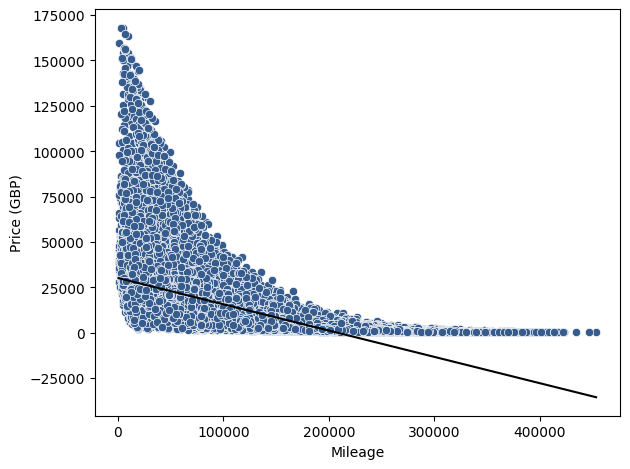

In [22]:
#Extract the input feature
x_mileage = df['Mileage']

linear_mileage_price = linear_regression(df, x_mileage, y, x_name='Mileage', y_name='Price (GBP)')

MAE and RMSE are higher than for Year of manufacture. R2 is worse also.

*Predict price (GBP) vs engine size (litres)*

Gradient: 6538.71
Intercept: 13853.14
Mean Absolute Error: 10817.49
Mean Squared Error: 230499154.45
Root Mean Squared Error: 15182.20
R2 Score: 0.1506


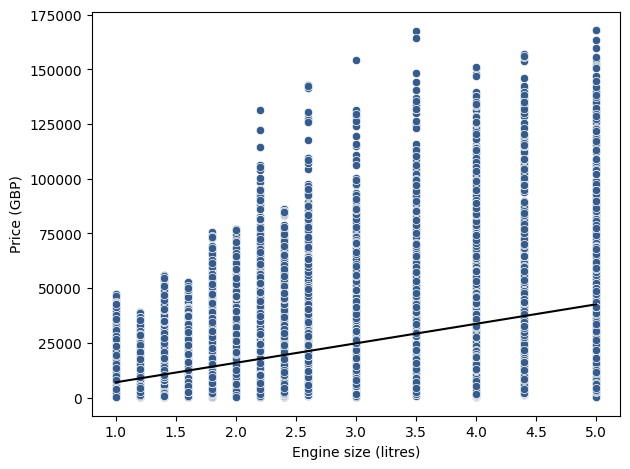

In [23]:
#Extract the input feature
x_engine = df['Engine size (litres)']

linear_engine_price = linear_regression(df, x_engine, y, x_name='Engine size (litres)', y_name='Price (GBP)')

MAE and RMSE and R2 (0.15) are the worst for engine size (litres). This represents a very poor correlation. It may be unlikely that a non-linear model will do a better prediction of price (GBP). 

*Summary of linear regression model for the three variables*

Of the three input variables, year of manufacture, mileage and engine size (litres), a linear regression model best predicted price (GBP) with an R2 of 0.51 for year of manufacture. It is likely that a non-linear model may provide a better prediction of price for year of manufacture and mileage. Engine size shows little linear correlation with price and may not improve in a non-linear model.

**Non-Linear Regression Models**

**Polynomial Regression**

Reference: 

W3 Schools (n. d.) Machine learning - polynomial regression. Available online: https://www.w3schools.com/python/python_ml_polynomial_regression.asp [Accessed 11/12/2023].


*Predict price (GBP) vs Year of manufacture 2nd order*

Coefficients: [12043.66326258  5285.35400178]
Intercept: 8542.972095188623
Mean Absolute Error: 5387.11
Mean Squared Error: 105993894.20
Root Mean Squared Error: 10295.33
R2 Score: 0.6094


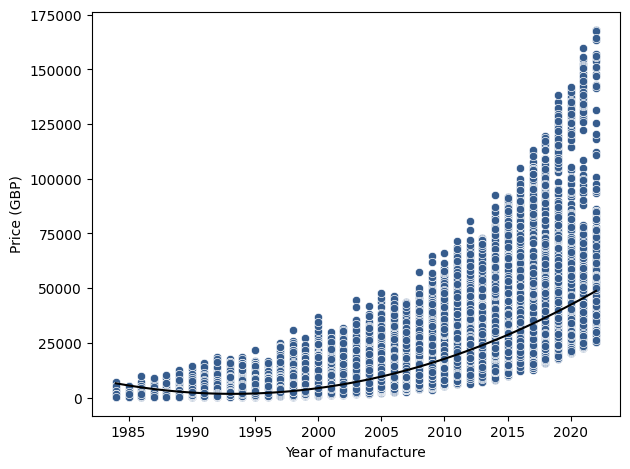

In [16]:
#Define function to model, fit, evalute and plot polynomial regression
def polynomial_regression(data, x, y, x_name, y_name, degree):
    """
    Perform polynomial regression on the given data and plot a scatter plot with the best-fit line.

    Parameters:
    data (pandas.DataFrame): The DataFrame containing the input feature and target variable.
    x (pandas.Series): The input feature.
    y (pandas.Series): The target variable.
    x_name (str): The series name for the x-axis in the scatter plot.
    y_name (str): The series name for the y-axis in the scatter plot.
    degree (int): The degree of the polynomial regression model.

    Returns:
    model (sklearn.linear_model.LinearRegression): Trained Polynomial Regression model.
    fig (matplotlib.figure.Figure): Matplotlib figure.
    """
    #The sklearn models expect the input, x, to be in the form of a 2-dimensional array
    #However, only a single input feature the result is 1-dimensional
    #Convert x to numpy array and reshape to a 2-dimensional array
    x = x.to_numpy().reshape(-1, 1)

    #Split the data into training and testing sets
    #from sklearn.model_selection import train_test_split
    #Split the x and y arrays between the train (80%) and test sets (20%)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    #Standardize the data
    #Important to scale the data to acount for different ranges (imporatn when have multiple numerical inputs)
    #Import the StandardScaler class from sklearn
    #from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    #Fit the standard scaler to x. This will find the mean and standard deviation in x, using the whole dataset
    scaler.fit(x)
    #Apply the standard scaler transformation to both the training and the testing sets
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    #Create and train a polynomial regression model
    #Import the PolynomialFeatures class from sklearn
    #from sklearn.preprocessing import PolynomialFeatures
    #Create an instance of the model
    #Degree of the polynomial here is defined as argument into the function 
    #Set the include_bias parameter to false, so don't include the constant (intercept) term with these polynomial features 
    #Gets added in later using the intercept
    poly = PolynomialFeatures(degree = degree, include_bias = False)
    
    #Apply PolynomialFeatures transformation to the scaled input data from the training set
    #The result will give a 2-dimensional array, where the first column contains the terms for x and the second column contains the terms for x**2.
    x_poly = poly.fit_transform(x_train_scaled)

    #Create an instance of the LinearRegression model
    #Polynomial features combined linearly with y
    model = LinearRegression()
    #Fit the model to the training data.
    model.fit(x_poly, y_train)
    
    #Get the fit coefficients from the best-fit model
    gradient = model.coef_
    intercept = model.intercept_
    
    print(f"Coefficients: {gradient}")
    print(f"Intercept: {intercept}")
    
    #Use the final, trained model to predict the price (GBP) for cars in df
    #First need to create the polynomial features from the scaled inputs features in the testing set
    #Then can use this with the final trained model to get the predicted prices
    x_test_poly = poly.fit_transform(x_test_scaled)
    y_pred = model.predict(x_test_poly)

    #Evaluate the model
    mean_abs = mean_absolute_error(y_test, y_pred)
    mean_squared = mean_squared_error(y_test, y_pred)
    rms_error = np.sqrt(mean_squared)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error: {mean_abs:.2f}")
    print(f"Mean Squared Error: {mean_squared:.2f}")
    print(f"Root Mean Squared Error: {rms_error:.2f}")
    print(f"R2 Score: {r2:.4f}")

    #Create an array of values covering the range of x
    x_fit = np.linspace(min(x), max(x), 100).reshape(-1, 1)

    #Apply the standardisation transformation using the same StandardScaler used on the training and testing data
    x_fit_scaled = scaler.transform(x_fit)

    #Apply the trained model to get y-values for the best-fit line
    #Create the polynomial features and apply them to the trained model
    x_fit_poly = poly.fit_transform(x_fit_scaled)
    y_fit = model.predict(x_fit_poly)

    #Create a scatter plot
    fig, ax = plt.subplots()
    sns.scatterplot(data = data, x = x_name, y = y_name, color=sns.color_palette('viridis')[1], ax=ax)

    #Plot the best-fit line
    ax.plot(x_fit, y_fit, color='black')
    plt.tight_layout()
    
    return model, fig

poly_2_year_manuf_price = polynomial_regression(df, x_year, y, x_name='Year of manufacture', y_name='Price (GBP)', degree=2)

This 2nd order polynomial is a better fit between price (GBP) and year of manufacture than a simple linear model, as the R2 score is now 0.61, compared to 0.51 for the linear model. The fit might be improved further if tested with higher polynomial terms.

*Predict price (GBP) vs Year of manufacture for higher orders*

Cross-validation is a resampling technique used to assess the performance of a predictive model. It provides a more accurate estimate of a model's performance on an independent dataset than a single train-test split.

The process of cross-validation involves the following steps:

Data Splitting: The original dataset is randomly partitioned into k subsets or folds. Typically, k is set to 5 or 10.

Model Training and Evaluation: The model is trained k times, each time using k-1 folds for training and the remaining fold for validation (testing). For each iteration, a different fold is used as the validation set, and the model is trained on the remaining k-1 folds.

Performance Metrics: The performance of the model is evaluated on each validation set, and performance metrics (accuracy, mean squared error) are recorded.

Average Performance: The performance metrics from all iterations are averaged to provide a more robust estimate of the model's performance.

Advantages of Cross-Validation:

Reduces the impact of the randomness in the initial data splitting.

Provides a more stable and representative estimate of model performance.

Helps identify issues such as overfitting or underfitting, selecting degree of the polynomial that provides the best balance between fit and generalisation.

The principle of Occam's Razor suggests that simpler models are preferred over complex ones if they perform similarly. Good practice to choose a model with a degree that is complex enough to capture the underlying patterns but not overly complex.

Reference for cross-validation: 

Scikit learn (n. d.) Cross-validation: evaluating estimator performance. Available online: https://scikit-learn.org/stable/modules/cross_validation.html [Accessed 11/12/2023].

Reference for Occam's razor: 

HowStuffWorks (2023) How Occam's razor works. Available online: https://science.howstuffworks.com/innovation/scientific-experiments/occams-razor.htm [Accessed 11/12/2023].

Optimal Polynomial Degree: 7
Mean Absolute Error: 5157.88
Mean Squared Error: 102580976.68
Root Mean Squared Error: 10128.23
R2 Score: 0.6220


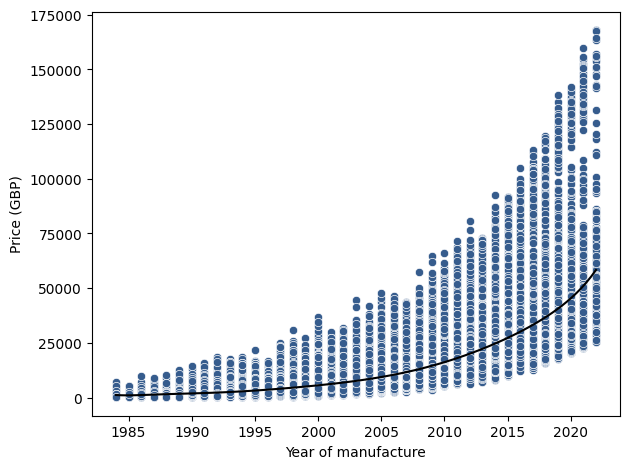

In [18]:
#Function to perform polynomial regression for a range of degrees, finding the optimal one using cross-validation
#from sklearn.model_selection import cross_val_score
def polynomial_regression_cross_validation(data, x, y, x_name, y_name, degrees):
    """
    Perform polynomial regression on the given data, find the optimal degree by cross-validation, print R2,
    and plot a scatter plot with the best-fit line.

    Parameters:
    x (pandas.Series): The input feature.
    y (pandas.Series): The target variable.
    x_name (str): The series name for the x-axis in the scatter plot.
    y_name (str): The series name for the y-axis in the scatter plot.
    degrees (list): List of polynomial degrees to test.

    Returns:
    final_model (sklearn.linear_model.LinearRegression): Trained Polynomial Regression model.
    fig (matplotlib.figure.Figure): Matplotlib figure.
    """
    best_degree = None
    best_cv_score = float('inf')

    for degree in degrees:
        #Convert x to a numpy array and reshape to a 2-dimensional array
        x_array = x.to_numpy().reshape(-1, 1)

        #Split the data into training and testing sets
        x_train, x_test, y_train, y_test = train_test_split(x_array, y, test_size=0.2, random_state=42)

        #Standardize the data
        scaler = StandardScaler()
        scaler.fit(x_array)
        x_train_scaled = scaler.transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        #Create and train a polynomial regression model
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        x_train_poly = poly.fit_transform(x_train_scaled)

        model = LinearRegression()
        #Perform cross-validated scoring on the model using negative mean squared error, using 5 subsets (cv)
        scores = cross_val_score(model, x_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
        #Calculate the average negative mean squared error across all folds
        cv_score = -scores.mean()
        
        #Update the best degree if the current degree has a lower average negative mean squared error
        if cv_score < best_cv_score:
            best_cv_score = cv_score
            best_degree = degree

    print(f"Optimal Polynomial Degree: {best_degree}")

    #Use the optimal degree to train the final model
    x_scaled = scaler.transform(x_array)
    # Transform test data
    x_poly = poly.transform(x_scaled)  
    final_model = LinearRegression()
    final_model.fit(x_poly, y)

    #Evaluate the model on the test data
    x_test_poly = poly.transform(x_test_scaled)
    y_pred = final_model.predict(x_test_poly)
    
    #Evaluate the model
    mean_abs = mean_absolute_error(y_test, y_pred)
    mean_squared = mean_squared_error(y_test, y_pred)
    rms_error = np.sqrt(mean_squared)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error: {mean_abs:.2f}")
    print(f"Mean Squared Error: {mean_squared:.2f}")
    print(f"Root Mean Squared Error: {rms_error:.2f}")
    print(f"R2 Score: {r2:.4f}")

    #Plot the best-fit line
    x_fit = np.linspace(min(x_array), max(x_array), 100).reshape(-1, 1)
    x_fit_scaled = scaler.transform(x_fit)
    x_fit_poly = poly.transform(x_fit_scaled)
    y_fit = final_model.predict(x_fit_poly)

    #Create a scatter plot
    fig, ax = plt.subplots()
    sns.scatterplot(data=data, x=x_name, y=y_name, color=sns.color_palette('viridis')[1], ax=ax)

    #Plot the best-fit line
    ax.plot(x_fit, y_fit, color = 'black')
    plt.tight_layout()

    return final_model, fig

degrees_to_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
poly_best_year_manuf_price = polynomial_regression_cross_validation(df, x_year, y, x_name='Year of manufacture', y_name='Price (GBP)', degrees=degrees_to_test)

The degree of the polynomial that provides the best balance between fit and generalisation for year of manufacture vs price is 7 with an R2 of 0.622.

A 7th-degree polynomial is high and can capture complex patterns in the data. However, using high-degree polynomials comes with some considerations:

1. As the degree of the polynomial increases, the model becomes more flexible and can fit the training data very closely. This can lead to overfitting, where the model performs well on the training data but fails to generalize to new, unseen data.

2. Higher-degree polynomials introduce more parameters, making the model more complex, resulting in a more intricate decision boundary, which might not be necessary for describing the underlying patterns in the data.

3. Higher-degree polynomials can be computationally expensive to fit and evaluate. The model may take longer to train, and predictions may become slower.

4. High-degree polynomials can be sensitive to noise in the data. They might capture fluctuations or outliers that do not represent the true underlying patterns.

*Predict price (GBP) vs mileage 2nd order*

Coefficients: [-13608.66073765   4484.59053514]
Intercept: 9325.301239980745
Mean Absolute Error: 6409.91
Mean Squared Error: 129620312.16
Root Mean Squared Error: 11385.09
R2 Score: 0.5224


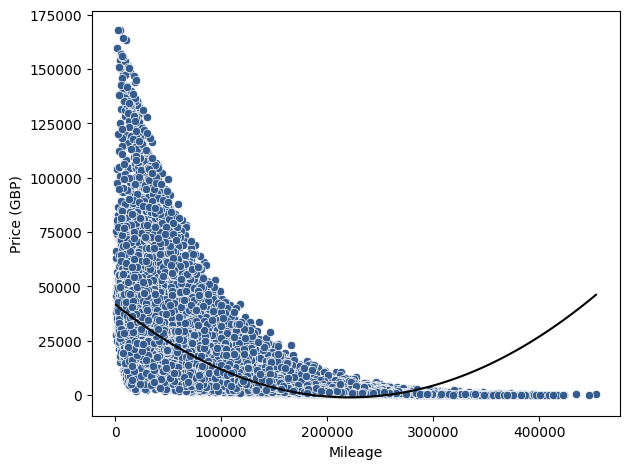

In [18]:
poly_2_mileage_price = polynomial_regression(df, x_mileage, y, x_name='Mileage', y_name='Price (GBP)', degree=2)

2nd order polynomial regression is an improved model (R2=0.52) over linear regression (R2=0.4).

Optimal Polynomial Degree: 5
Mean Absolute Error: 5703.75
Mean Squared Error: 120554245.87
Root Mean Squared Error: 10979.72
R2 Score: 0.5558


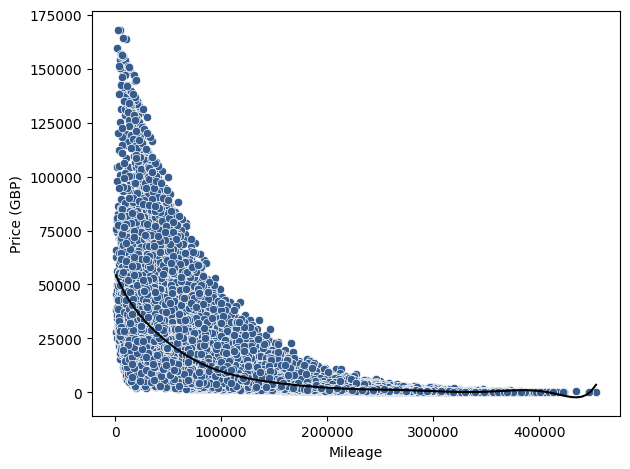

In [24]:
#Testing higher degrees
poly_best_mileage_price = polynomial_regression_cross_validation(df, x_mileage, y, x_name='Mileage', y_name='Price (GBP)', degrees=degrees_to_test)

5th order polynomial regression is the best model (R2=0.55) to choose for a non-linear fit.

*Predict price (GBP) vs engine size (litres)*

Coefficients: [6045.42772837  236.02040276]
Intercept: 13614.55789921067
Mean Absolute Error: 10807.26
Mean Squared Error: 230326166.00
Root Mean Squared Error: 15176.50
R2 Score: 0.1513


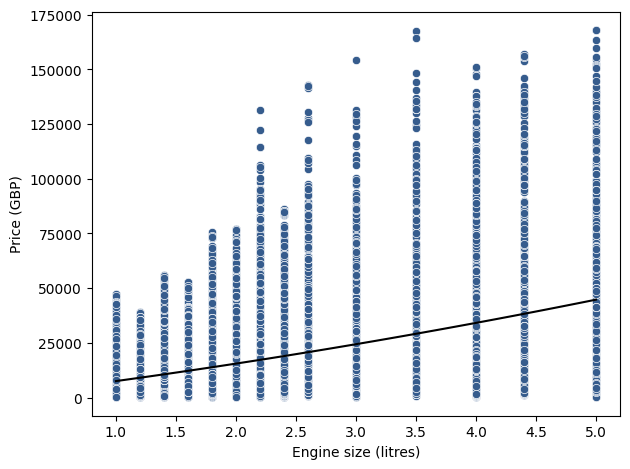

In [20]:
poly_2_engine_price = polynomial_regression(df, x_engine, y, x_name='Engine size (litres)', y_name='Price (GBP)', degree=2)

The polynomial fit (2nd degree) of engine size (litres) vs price (GBP) is only marginally improved (0.1513) over linear regression (0.1506). Both fits are very poor suggesting no linear or non-linear correlation between engine size (litres) and price (GBP).

**Decision Trees Regression**

Decision Tree Regression uses a decision tree as a predictive model. Unlike classification trees, which are used for predicting categorical outcomes, decision tree regression is used for predicting continuous numeric values. it recursively splits the data based on input features.

Can capture complex relationships in the data, but it is prone to overfitting, especially when the tree is deep. Overfitting can be mitigated by tuning hyperparameters or limiting the depth of the tree (maximum depth).

Reference: 

Scikit learn (n. d.) Decision tree regression. Available online: https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html [Accessed 11/12/2023].

Reference 2:

Codecademy (n. d.) Decision trees for classification and regression. Available online: https://www.codecademy.com/article/mlfun-decision-trees-article [Accessed 11/12/2023].

*Year of manufacture vs price (GBP)*

Best Hyperparameters:
min_samples_split: 2
min_samples_leaf: 4
max_features: log2
max_depth: 20
criterion: squared_error
Mean Absolute Error: 5164.72
Mean Squared Error: 102782548.88
Root Mean Squared Error: 10138.17
R2 Score: 0.6213


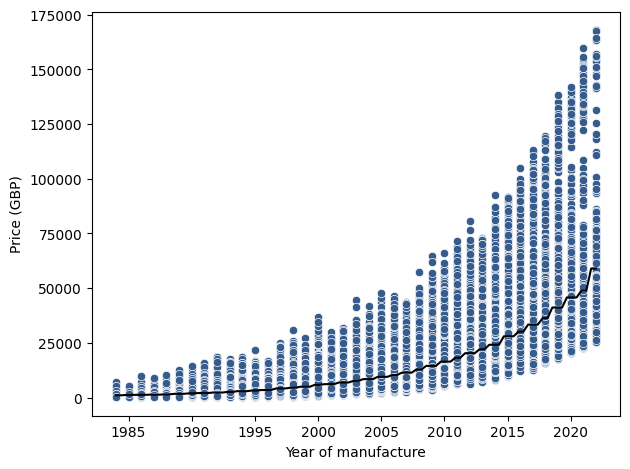

In [21]:
#from sklearn.tree import DecisionTreeRegressor
#Create a function that performs decision tree regression on provided x and y
#Optimise for hyperparameters and then plot the results
def decision_tree_regression(data, x, y, x_name, y_name, max_depth_values=None,
                             min_samples_split_values=None, min_samples_leaf_values=None,
                             max_features_values=None, criterion_values=None, test_size=0.2, random_state=42):
    """
    Perform Decision Tree Regression on the given data, optimize hyperparameters using randomized search,
    plot the results, and return the trained model.

    Parameters:
    data (pandas.DataFrame): The entire dataset.
    x (pandas.Series): The input feature.
    y (pandas.Series): The target variable.
    x_name (str): The series name for the x-axis in the scatter plot.
    y_name (str): The series name for the y-axis in the scatter plot.
    max_depth_values (list or None): List of max_depth values to test. If None, defaults will be used.
    min_samples_split_values (list or None): List of min_samples_split values to test. If None, defaults will be used.
    min_samples_leaf_values (list or None): List of min_samples_leaf values to test. If None, defaults will be used.
    max_features_values (list or None): List of max_features values to test. If None, defaults will be used.
    criterion_values (list or None): List of criterion values to test. If None, defaults will be used.
    test_size (float): Proportion of the dataset to include in the test split.
    random_state (int): Seed for random state.

    Returns:
    opt_model (sklearn.tree.DecisionTreeRegressor): Trained Decision Tree Regression model.
    fig (matplotlib.figure.Figure): Matplotlib figure.
    """
    #Convert x to numpy array and reshape to a 2-dimensional array
    x_array = x.to_numpy().reshape(-1, 1)

    #Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_array, y, test_size=test_size, random_state=random_state)

    #Standardize the data
    scaler = StandardScaler()
    scaler.fit(x_array)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    #Create a decision tree regression model
    model = DecisionTreeRegressor(random_state=random_state)

    #Define the parameter distribution for randomized search
    param_dist = {
        #None added to max_depth to allow the trees to grow until they contain fewer than min_samples_split samples
        'max_depth': max_depth_values if max_depth_values else [int(x) for x in np.linspace(1, 20, 5)] + [None],
        'min_samples_split': min_samples_split_values if min_samples_split_values else [2, 5, 10],
        'min_samples_leaf': min_samples_leaf_values if min_samples_leaf_values else [1, 2, 4],
        'max_features': max_features_values if max_features_values else [1.0, 'sqrt', 'log2'],
        'criterion': criterion_values if criterion_values else ['squared_error', 'absolute_error']
    }

    #Use RandomizedSearchCV for hyperparameter tuning
    #Neg mean squared error used as common utility function
    randomized_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=random_state)
    randomized_search.fit(x_train_scaled, y_train)

    #Get the best hyperparameter values
    best_params = randomized_search.best_params_

    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    #Train the final model with the optimal hyperparameters
    opt_model = DecisionTreeRegressor(**best_params, random_state=42)
    opt_model.fit(x_train_scaled, y_train)

    #Make predictions on the test data
    y_pred = opt_model.predict(x_test_scaled)

    #Evaluate the model
    mean_abs = mean_absolute_error(y_test, y_pred)
    mean_squared = mean_squared_error(y_test, y_pred)
    rms_error = np.sqrt(mean_squared)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error: {mean_abs:.2f}")
    print(f"Mean Squared Error: {mean_squared:.2f}")
    print(f"Root Mean Squared Error: {rms_error:.2f}")
    print(f"R2 Score: {r2:.4f}")

    #Plot the best fit line
    x_fit = np.linspace(min(x), max(x), 100).reshape(-1, 1)
    x_fit_scaled = scaler.transform(x_fit)
    y_fit = opt_model.predict(x_fit_scaled)

    #Create a scatter plot
    fig, ax = plt.subplots()
    sns.scatterplot(data=data, x=x_name, y=y_name, color=sns.color_palette('viridis')[1], ax=ax)

    #Plot the regression line
    ax.plot(x_fit, y_fit, color='black')
    plt.tight_layout()

    return opt_model, fig

decision_tree_year_manuf_price = decision_tree_regression(df, x_year, y, x_name='Year of manufacture', y_name='Price (GBP)')

This decision tree regression model performs only slightly under (0.6213) the polynomial fit (0.622) for prediction of price (GBP) by year of manufacture.

*Mileage vs price (GBP)*

Best Hyperparameters:
min_samples_split: 5
min_samples_leaf: 4
max_features: 1.0
max_depth: 5
criterion: absolute_error
Mean Absolute Error: 5545.59
Mean Squared Error: 127075015.24
Root Mean Squared Error: 11272.76
R2 Score: 0.5317


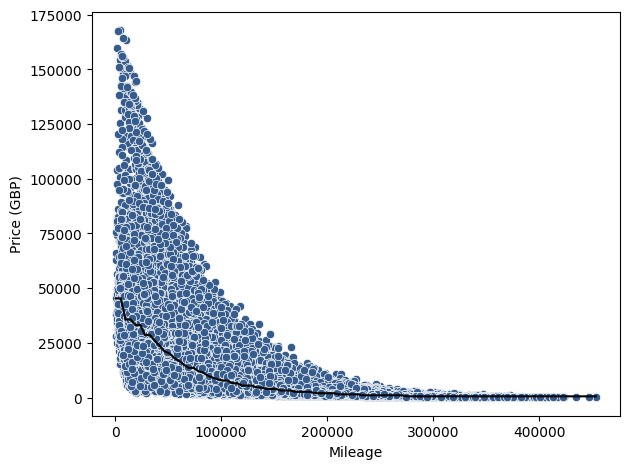

In [22]:
#Run decision tree regression on mileage
decision_tree_mileage_price = decision_tree_regression(df, x_mileage, y, x_name='Mileage', y_name='Price (GBP)')

This decision tree regression model performs only slightly under (0.5317) the polynomial fit (0.556) for prediction of price (GBP) by mileage.

**Random Forest Regression**

Random Forest Regression is an ensemble learning technique that combines the predictions of multiple decision trees to create a more robust and accurate model for regression tasks. 

It uses multiple decision trees and repeatedly samples the training data with replacement (bootstrap sampling). Each tree is trained on a different subset of the data. At each node of the decision tree, a random subset of features is considered for splitting (feature randomisation). It reduces over-fiiting by averaging the prediction from all trees. 

Need to optimise for max depth and no. of trees (estimator values).

Reference: 

Scikit learn (n. d.) sklearn.ensemble.RandomForestRegressor. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html [Accessed 11/12/2023].

Reference 2: 

Geeks for Geeks (n. d.) Random forest regression in Python. Available online: https://www.geeksforgeeks.org/random-forest-regression-in-python/ [Accessed 11/12/2023].

*Year of manufacture vs price (GBP)*

Best Hyperparameters:
n_estimators: 100
min_samples_split: 5
min_samples_leaf: 1
max_features: sqrt
max_depth: 30
Mean Absolute Error: 5162.99
Mean Squared Error: 102815430.35
Root Mean Squared Error: 10139.79
R2 Score: 0.6211


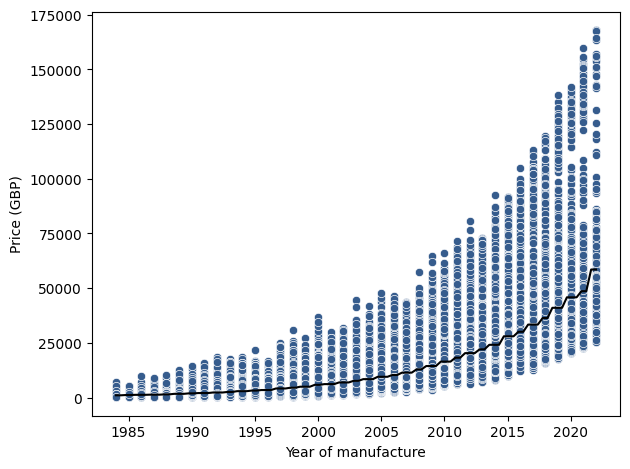

In [23]:
#Didn't include bootstrap or oob value tuning
#Optimising for hyperparameters
def random_forest_regression(data, x, y, x_name, y_name, n_estimators_values=None, max_depth_values=None,
                             min_samples_split_values=None, min_samples_leaf_values=None,
                             max_features_values=None, test_size=0.2, random_state=42):
    """
    Perform Random Forest Regression on the given data, optimize hyperparameters using randomized search,
    plot the results, and return the trained model.

    Parameters:
    data (pandas.DataFrame): The entire dataset.
    x (pandas.Series): The input feature.
    y (pandas.Series): The target variable.
    x_name (str): The series name for the x-axis in the scatter plot.
    y_name (str): The series name for the y-axis in the scatter plot.
    n_estimators_values (list or None): List of n_estimators values to test. If None, defaults will be used.
    max_depth_values (list or None): List of max_depth values to test. If None, defaults will be used.
    min_samples_split_values (list or None): List of min_samples_split values to test. If None, defaults will be used.
    min_samples_leaf_values (list or None): List of min_samples_leaf values to test. If None, defaults will be used.
    max_features_values (list or None): List of max_features values to test. If None, defaults will be used.
    test_size (float): Proportion of the dataset to include in the test split.
    random_state (int): Seed for random state.

    Returns:
    opt_model (sklearn.ensemble.RandomForestRegressor): Trained Random Forest Regression model.
    fig (matplotlib.figure.Figure): Matplotlib figure.
    """
    #Convert x to numpy array and reshape to a 2-dimensional array
    x_array = x.to_numpy().reshape(-1, 1)

    #Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_array, y, test_size=test_size, random_state=random_state)

    #Standardize the data
    scaler = StandardScaler()
    scaler.fit(x_array)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    #Create a random forest regression model
    model = RandomForestRegressor(random_state=random_state)

    #Define the parameter distribution for randomized search
    param_dist = {
        'n_estimators': n_estimators_values if n_estimators_values else [int(x) for x in np.linspace(10, 100, 10)],
        'max_depth': max_depth_values if max_depth_values else [int(x) for x in np.linspace(5, 30, 6)] + [None],
        'min_samples_split': min_samples_split_values if min_samples_split_values else [2, 5, 10],
        'min_samples_leaf': min_samples_leaf_values if min_samples_leaf_values else [1, 2, 4],
        'max_features': max_features_values if max_features_values else [1.0, 'sqrt', 'log2'],
    }

    #Use RandomizedSearchCV for hyperparameter tuning
    randomized_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=random_state)
    randomized_search.fit(x_train_scaled, y_train)

    #Get the best hyperparameter values
    best_params = randomized_search.best_params_

    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    #Train the final model with the optimal hyperparameters
    opt_model = RandomForestRegressor(**best_params, random_state=42)
    opt_model.fit(x_train_scaled, y_train)

    #Make predictions on the test data
    y_pred = opt_model.predict(x_test_scaled)

    #Evaluate the model
    mean_abs = mean_absolute_error(y_test, y_pred)
    mean_squared = mean_squared_error(y_test, y_pred)
    rms_error = np.sqrt(mean_squared)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error: {mean_abs:.2f}")
    print(f"Mean Squared Error: {mean_squared:.2f}")
    print(f"Root Mean Squared Error: {rms_error:.2f}")
    print(f"R2 Score: {r2:.4f}")

    #Plot the best fit line
    x_fit = np.linspace(min(x), max(x), 100).reshape(-1, 1)
    x_fit_scaled = scaler.transform(x_fit)
    y_fit = opt_model.predict(x_fit_scaled)

    #Create a scatter plot
    fig, ax = plt.subplots()
    sns.scatterplot(data=data, x=x_name, y=y_name, color=sns.color_palette('viridis')[1], ax=ax)

    #Plot the regression line
    ax.plot(x_fit, y_fit, color='black')
    plt.tight_layout()

    return opt_model, fig

random_forest_year_manuf_price = random_forest_regression(df, x_year, y, x_name='Year of manufacture', y_name='Price (GBP)')

This random forest regression model performs marginally poorer than decision trees regression (0.6211 compared to 0.6213).

The 7th order polynomial model is still marginally better at predicting salary (GBP) using year of manufacture (0.622)

*Mileage vs price (GBP)*

Best Hyperparameters:
n_estimators: 20
min_samples_split: 2
min_samples_leaf: 2
max_features: sqrt
max_depth: 5
Mean Absolute Error: 5722.09
Mean Squared Error: 121022629.64
Root Mean Squared Error: 11001.03
R2 Score: 0.5540


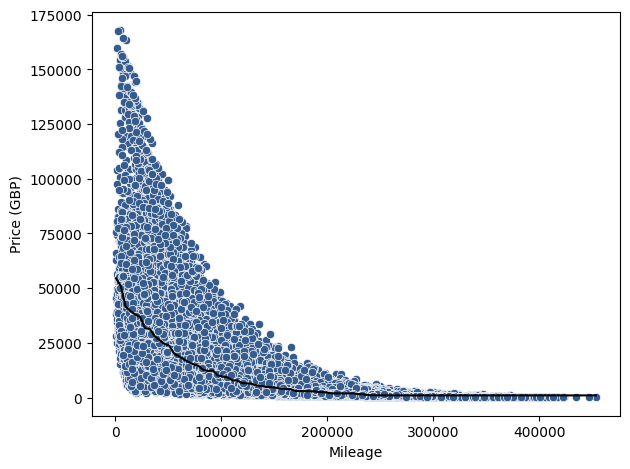

In [24]:
#Run random forest regression function for mileage
random_forest_mileage_price = random_forest_regression(df, x_mileage, y, x_name='Mileage', y_name='Price (GBP)')

This random forest regression model performs slightly better than decision trees regression (0.554 compared to 0.531).

The 5th order polynomial model is still marginally better at predicting salary (GBP) using mileage (0.556).

**Summary of regression models for single numerical inputs**

No significant correlation between engine size (litres) and price (GBP) using linear or polynomial models.

A polynomial model is the better choice for year of manufacture (7th order) and mileage (5th order) for predicting price (GBP). With improved R2 compared to simple linear regression.

Further exploring price prediction using year of manufacture and mileage as input variables using decision tree and random forest regression, both models performed slightly worse than the polynomial regression for both variables. 

For year of manufacture R2 was 0.621 (for both regression models) compared to 0.622 (for 7th order polynomial).

For mileage, the 5th order polynomial model also performed the best (0.556) compared to random forest (0.554) and decision tree regression (0.531).

**Multiple Linear Regression Models**

Consider regression models that take multiple numerical variables as input features to predict the price of a car. 

Explore whether the inclusion of multiple input features improve the accuracy of the model’s prediction compared to the single-input feature models.

**Linear regression model using multiple numerical input features**

In [5]:
feature_names = ["Year of manufacture", "Mileage", "Engine size (litres)"]
x_num = df[feature_names]

Year of manufacture coefficient: 9523.53
Mileage coefficient: -2722.98
Engine size (litres) coefficient: 6556.97
Intercept: 13819.00
Mean Absolute Error: 6091.46
Mean Squared Error: 89158615.76
Root Mean Squared Error: 9442.38
R2 Score: 0.6715


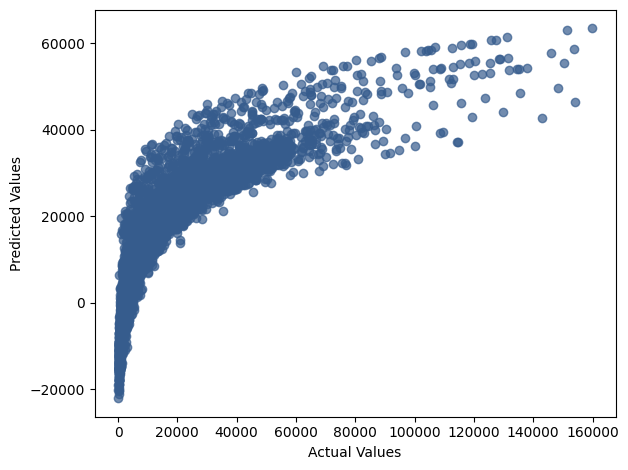

In [25]:
#Define function to perform multiple linear regression and plot best fit 
#Define multiple features for x
#No need to re-shape x because it is already a 2-dimensional array
def multiple_linear_regression(x, y):
    """
    Perform Multiple Linear Regression on the given data, scale input features,
    fit a model, print coefficients, make predictions, evaluate the model, and create a scatter plot.

    Parameters:
    x (pandas.DataFrame): The input features.
    y (pandas.Series): The target variable.
    feature_names (list or None): List of feature names. If None, uses column names of x.

    Returns:
    multiple_linear_model (sklearn.linear_model.LinearRegression): Fitted multiple linear regression model.
    fig (matplotlib.figure.Figure): Matplotlib figure.
    """
    #Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    #Scale the input features
    scaler = StandardScaler()
    scaler.fit(x)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    #Fit a multiple-linear regression model to the training data
    multiple_linear_model = LinearRegression()
    multiple_linear_model.fit(x_train_scaled, y_train)
    
    #Get the fit coefficients from the best-fit model.
    intercept = multiple_linear_model.intercept_
    coefficients = multiple_linear_model.coef_
    
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature} coefficient: {coef:.2f}")
    print(f"Intercept: {intercept:.2f}")
    
    #Make predictions on x_test_scaled (predict price)
    multiple_linear_pred = multiple_linear_model.predict(x_test_scaled)
    
    #Evaluate the model
    mean_abs = mean_absolute_error(y_test, multiple_linear_pred)
    mean_squared = mean_squared_error(y_test, multiple_linear_pred)
    rms_error = np.sqrt(mean_squared)
    r2 = r2_score(y_test, multiple_linear_pred)

    #Print the evaluation metrics
    print(f"Mean Absolute Error: {mean_abs:.2f}")
    print(f"Mean Squared Error: {mean_squared:.2f}")
    print(f"Root Mean Squared Error: {rms_error:.2f}")
    print(f"R2 Score: {r2:.4f}")
    
    #Plot actual vs. predicted with diagonal line
    fig, ax = plt.subplots()
    plt.scatter(y_test, multiple_linear_pred, color=sns.color_palette('viridis')[1], alpha=0.7)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.tight_layout()
    
    return multiple_linear_model, fig
    
multiple_numerical_features_price = multiple_linear_regression(x_num, y)

This multiple linear regression model is a better predictor of price (GBP) by combining multiple features year of manufacture, mileage and engine size (litres) with an R2 of 0.6715. 

However, the plot of actual vs predicted values (and previous non-linear analysis) indicates that the model required is non-linear.

**Decision tree regression using multiple input features**

Reference:

Scikit learn (n. d.) Decision tree regression. Available online: https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html [Accessed 11/12/2023].

Hyperparameters require tuning.

Using Randomised Search for sampling approach using a "fit and score" method to reduce computational time.

Reference:

Scikit learn (n. d.) sklearn.model_selection.RandomizedSearchCV. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html [Accessed 11/12/2023].

Best Hyperparameters:
min_samples_split: 10
min_samples_leaf: 2
max_features: 1.0
max_depth: 30
criterion: absolute_error
Mean Absolute Error: 2416.15
Mean Squared Error: 23351109.50
Root Mean Squared Error: 4832.30
R2 Score: 0.9140


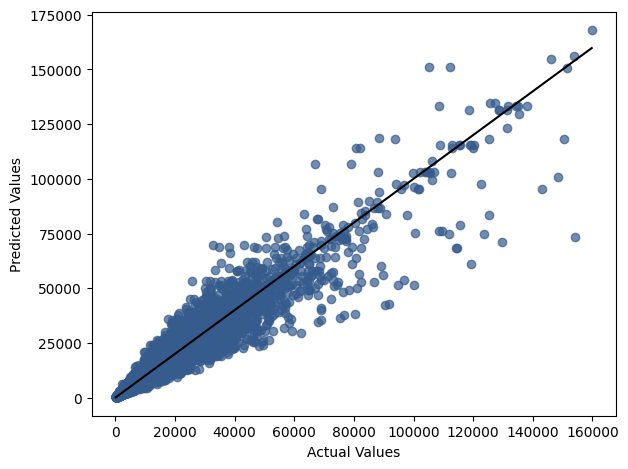

In [26]:
#Function for multiple features and plot actual vs predicted with hyperparameter tuning
def decision_tree_regression_multiple(x, y, max_depth_values=None, min_samples_split_values=None,
                                      min_samples_leaf_values=None, max_features_values=None, criterion_values=None, 
                                      test_size=0.2, random_state=42):
    """
    Perform Decision Tree Regression on the given data, optimize for hyperparameters using cross-validation, 
    plot the results, and return the trained model.

    Parameters:
    x (pandas.DataFrame): The input features.
    y (pandas.Series): The target variable.
    max_depth_values (list or None): List of max_depth values to test. If None, defaults will be used.
    min_samples_split_values (list or None): List of min_samples_split values to test. If None, defaults will be used.
    min_samples_leaf_values (list or None): List of min_samples_leaf values to test. If None, defaults will be used.
    max_features_values (list or None): List of max_features values to test. If None, defaults will be used.
    criterion_values (list or None): List of criterion values to test. If None, defaults will be used.
    test_size (float): Proportion of the dataset to include in the test split.
    random_state (int): Seed for random state.

    Returns:
    opt_model (sklearn.tree.DecisionTreeRegressor): Trained Decision Tree Regression model.
    fig (matplotlib.figure.Figure): Matplotlib figure.
    """
    #Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    #Standardize the data
    scaler = StandardScaler()
    scaler.fit(x)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    #Create a decision tree regression model
    model = DecisionTreeRegressor(random_state=random_state)

    #Define the parameter distribution for randomized search
    #Assumes moderate data complexity
    param_dist = {
        #None added to max_depth to allow the trees to grow until they contain fewer than min_samples_split samples
        'max_depth': max_depth_values if max_depth_values else [int(x) for x in np.linspace(5, 30, 6)] + [None],
        'min_samples_split': min_samples_split_values if min_samples_split_values else [2, 5, 10],
        'min_samples_leaf': min_samples_leaf_values if min_samples_leaf_values else [1, 2, 4],
        'max_features': max_features_values if max_features_values else [1.0, 'sqrt', 'log2'],
        'criterion': criterion_values if criterion_values else ['squared_error', 'absolute_error']
    }

    #Use RandomizedSearchCV for hyperparameter tuning
    #Neg mean squared error commonly used utility function
    randomized_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=random_state)
    randomized_search.fit(x_train_scaled, y_train)

    #Get the best hyperparameter values
    best_params = randomized_search.best_params_

    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    #Train the final model with the optimal hyperparameters
    opt_model = DecisionTreeRegressor(**best_params, random_state=random_state)
    opt_model.fit(x_train_scaled, y_train)

    #Make predictions on the test data
    y_pred = opt_model.predict(x_test_scaled)

    #Evaluate the model
    mean_abs = mean_absolute_error(y_test, y_pred)
    mean_squared = mean_squared_error(y_test, y_pred)
    rms_error = np.sqrt(mean_squared)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error: {mean_abs:.2f}")
    print(f"Mean Squared Error: {mean_squared:.2f}")
    print(f"Root Mean Squared Error: {rms_error:.2f}")
    print(f"R2 Score: {r2:.4f}")

    #Plot actual vs. predicted with diagonal line
    fig, ax = plt.subplots()
    plt.scatter(y_test, y_pred, color=sns.color_palette('viridis')[1], alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.tight_layout()

    return opt_model, fig

decision_tree_multiple_price = decision_tree_regression_multiple(x_num, y)

Using a decision tree regression model with multiple features provides a vastly improved model for prediction (R is 0.9140). This is best predictor of price (GBP) so far. There is higher variability in prediction (over and under fitting) at higher prices.

**Random Forest regression using multiple numerical features**

Reference: 
Scikit learn (n. d.) sklearn.ensemble.RandomForestRegressor. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html [Accessed 11/12/2023].

Hyperparameters require tuning.

Again using Randomised Search.

Best Hyperparameters:
n_estimators: 50
min_samples_split: 10
min_samples_leaf: 2
max_features: log2
max_depth: 20
Mean Absolute Error: 2162.97
Mean Squared Error: 16832304.52
Root Mean Squared Error: 4102.72
R2 Score: 0.9380


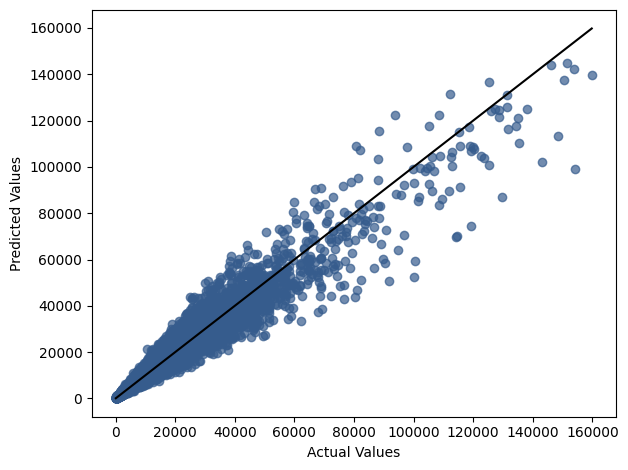

In [27]:
#Function for multiple features and plot actual vs predicted with hyperparameter tuning
def random_forest_regression_multiple(x, y, n_estimators_values=None, max_depth_values=None, min_samples_split_values=None,
                                      min_samples_leaf_values=None, max_features_values=None, test_size=0.2, random_state=42):
    """
    Perform Random Forest Regression on the given data, optimize for hyperparameters using cross-validation, 
    plot the results, and return the trained model.

    Parameters:
    x (pandas.Series): The input features.
    y (pandas.Series): The target variable.
    n_estimators_values (list or None): List of n_estimators values to test. If None, defaults will be used.
    max_depth_values (list or None): List of max_depth values to test. If None, defaults will be used.
    min_samples_split_values (list or None): List of min_samples_split values to test. If None, defaults will be used.
    min_samples_leaf_values (list or None): List of min_samples_leaf values to test. If None, defaults will be used.
    max_features_values (list or None): List of max_features values to test. If None, defaults will be used.
    test_size (float): Proportion of the dataset to include in the test split.
    random_state (int): Seed for random state.

    Returns:
    opt_model (sklearn.ensemble.RandomForestRegressor): Trained Random Forest Regression model.
    fig (matplotlib.figure.Figure): Matplotlib figure.
    """
    #Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    #Standardize the data
    scaler = StandardScaler()
    scaler.fit(x)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    #Create a random forest regression model
    model = RandomForestRegressor(random_state=random_state)

    #Define the parameter distribution for randomized search
    #Assumes moderate complexity of data
    #Set parameters based on
    param_dist = {
        #Allow up to 100 trees
        'n_estimators': n_estimators_values if n_estimators_values else [int(x) for x in np.linspace(10, 100, 10)],
        #None added to max_depth to allow the trees to grow until they contain fewer than min_samples_split samples
        'max_depth': max_depth_values if max_depth_values else [int(x) for x in np.linspace(5, 30, 6)] + [None],
        'min_samples_split': min_samples_split_values if min_samples_split_values else [2, 5, 10],
        'min_samples_leaf': min_samples_leaf_values if min_samples_leaf_values else [1, 2, 4],
        'max_features': max_features_values if max_features_values else [1.0, 'sqrt', 'log2'],
    }

    #Use RandomizedSearchCV for hyperparameter tuning
    randomized_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=random_state)
    randomized_search.fit(x_train_scaled, y_train)

    #Get the best hyperparameter values
    best_params = randomized_search.best_params_

    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    #Train the final model with the optimal hyperparameters
    opt_model = RandomForestRegressor(**best_params, random_state=random_state)
    opt_model.fit(x_train_scaled, y_train)

    #Make predictions on the test data
    y_pred = opt_model.predict(x_test_scaled)

    #Evaluate the model
    mean_abs = mean_absolute_error(y_test, y_pred)
    mean_squared = mean_squared_error(y_test, y_pred)
    rms_error = np.sqrt(mean_squared)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error: {mean_abs:.2f}")
    print(f"Mean Squared Error: {mean_squared:.2f}")
    print(f"Root Mean Squared Error: {rms_error:.2f}")
    print(f"R2 Score: {r2:.4f}")

    #Plot actual vs. predicted with diagonal line
    fig, ax = plt.subplots()
    plt.scatter(y_test, y_pred, color=sns.color_palette('viridis')[1], alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.tight_layout()

    return opt_model, fig

random_forest_multiple_price = random_forest_regression_multiple(x_num, y)

The random forest regressor model is marginally improved at predicting price (GBP) over decision tree regression based on multiple (numerical) features with R2 of 0.9380. The best predictive model so far combining all of the numerical features in df.

**Support Vector Regression using multiple numerical input features**

Support Vector Regression (SVR) is a type of regression algorithm that utilizes Support Vector Machines (SVM) for regression analysis. SVR is particularly useful when dealing with non-linear relationships between input features and the target variable. 

SVR tries to find a hyperplane that best represents the relationship between input features and the target variable in a high-dimensional space.

Choice of kernel - (not linear) Polynomial 'poly' most appropriate and chosen due to regression analysis, where polynomial models were the best fit for the data.

Need to optimise hyperparameters C and epsilon, using Randomised Search again.

C (Cost): Controls the trade-off between achieving a smooth decision boundary and classifying the training points correctly. Higher values of C make the model fit the training data more precisely, potentially leading to overfitting.

Epsilon (epsilon): Defines a margin of tolerance where no penalty is given to errors. It allows the model to have a certain degree of error in fitting the training data.

Reference:

Scikit learn (n. d.) sklearn.svm.SVR. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html [Accessed 11/12/2023].

Reference 2:

Scikit learn (n. d.) Support vector machines. Available online: https://scikit-learn.org/stable/modules/svm.html [Accessed 11/12/2023].

Optimal C: 10
Optimal Epsilon: 1.0
Mean Absolute Error: 6484.69
Mean Squared Error: 96481063.36
Root Mean Squared Error: 9822.48
R2 Score: 0.6445


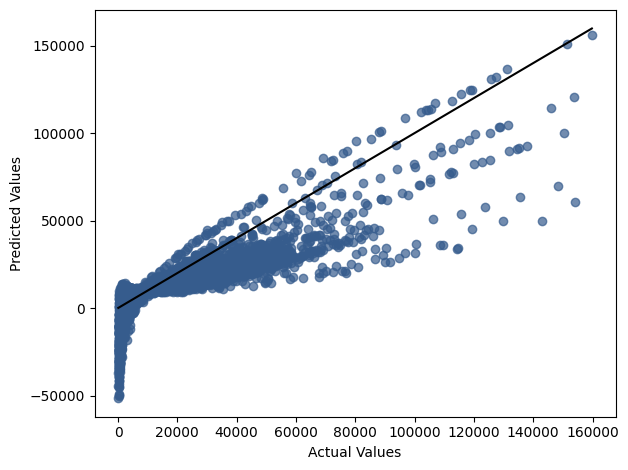

In [28]:
#Define function for SVR with cross validation to determine best C and epsilon 
#Have chosen poly kernel for the analysis base on non-linear fit determined previously
def support_vector_regression_with_cv(x, y, kernel='poly', test_size=0.2, random_state=42):
    """
    Perform Support Vector Regression with cross-validation on the given data.

    Parameters:
    x (pandas.DataFrame): Input features with multiple numerical columns.
    y (pandas.Series): Target variable.
    kernel (str): Kernel type for SVR ('linear', 'rbf', 'poly', etc.).
    test_size (float): Proportion of the dataset to include in the test split.
    random_state (int): Seed for random number generation.

    Returns:
    svr_model (sklearn.svm.SVR): Trained SVR model.
    fig (matplotlib.figure.Figure): Matplotlib figure.
    """
    #Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    #Standardize the data
    scaler = StandardScaler()
    scaler.fit(x)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    #Create an SVR model
    svr_model = SVR(kernel=kernel)

    #Define the parameter distribution for randomized search
    param_dist = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.5, 1.0]}

    #Use RandomizedSearchCV for randomized cross-validation and hyperparameter tuning
    randomized_search = RandomizedSearchCV(svr_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=random_state)
    randomized_search.fit(x_train_scaled, y_train)

    #Get the best hyperparameter values
    best_C = randomized_search.best_params_['C']
    best_epsilon = randomized_search.best_params_['epsilon']

    print(f"Optimal C: {best_C}")
    print(f"Optimal Epsilon: {best_epsilon}")

    #Train the final model with the optimal hyperparameters
    svr_model = SVR(kernel=kernel, C=best_C, epsilon=best_epsilon)
    svr_model.fit(x_train_scaled, y_train)

    #Make predictions on the test set
    y_pred = svr_model.predict(x_test_scaled)

    #Evaluate the model
    mean_abs = mean_absolute_error(y_test, y_pred)
    mean_squared = mean_squared_error(y_test, y_pred)
    rms_error = np.sqrt(mean_squared)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error: {mean_abs:.2f}")
    print(f"Mean Squared Error: {mean_squared:.2f}")
    print(f"Root Mean Squared Error: {rms_error:.2f}")
    print(f"R2 Score: {r2:.4f}")

    #Plot actual vs. predicted with a diagonal line
    fig, ax = plt.subplots()
    plt.scatter(y_test, y_pred, color=sns.color_palette('viridis')[1], alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.tight_layout()

    return svr_model, fig

support_vector_multiple_price = support_vector_regression_with_cv(x_num, y)

SVR is a poorly performing model compared to Decision Tree and Random Forest Regression.

**Summary of supervised regression models with numerical features**

The best single input regression model is a polynomial regression model for both year of manufacture (7th order) and mileage (5th order) for predicting price (GBP). With improved R2 compared to simple linear, decision tree and random forest regression. Hyperparameter optimisation was executed for decision tree, random forest and support vector regression.

No significant correlation between engine size (litres) and price (GBP) therefore models (linear and polynomial) performed poor predictions.

The best supervised multiple regression model for all numerical features in df is Random Forest Regression.

**Supervised regression models for all features (numerical and categorical)**

There are also several categorical variables in the dataset that are likely to affect the price of the car. 

Train a regression model that uses all relevant input variables (both categorical and numerical) to predict the price (e.g. a Random Forest Regressor model). Determine if this improves the accuracy of the results.

**Random Forest Regressor model**

Decision trees can handle both numerical and categorical variables.

Scikit learn (n. d.) sklearn.ensemble.RandomForestRegressor. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html [Accessed 11/12/2023].

*Label encoding*

First need to convert categorical values to numerical using label encoding (could also use one hot encoding)

Reference:

Scikit learn (n. d.) sklearn.preprocessing.LabelEncoder. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html [Accessed 12/12/2023].

This will also be required for ANN model later in this notebook.

In [6]:
#Define feature names (categorical and numerical) for all but price (GBP) to be used
feature_names_2 = ["Manufacturer", "Model", "Fuel type"]
x_cat = df[feature_names_2]

#Deal with scaling of numerical values and encoding of categorical values
scaler = MinMaxScaler()
label = LabelEncoder()

#Standardize the numerical data
scaler.fit(x_num)
x_num_scaled = scaler.transform(x_num)

#Initialize an empty DataFrame to store encoded categorical data
x_cat_label = pd.DataFrame()

#Iterate over each column in x_cat and transform
for col in x_cat.columns:
    # Fit and transform the label encoder for each column
    x_cat_label[col] = label.fit_transform(x_cat[col])

#Combine the numerical and categorical input features into a single array
x_all = pd.concat([pd.DataFrame(x_num_scaled, columns=x_num.columns), x_cat_label], axis=1)

Best Hyperparameters:
n_estimators: 100
min_samples_split: 5
min_samples_leaf: 1
max_features: sqrt
max_depth: 30
Mean Absolute Error: 331.52
Mean Squared Error: 576664.59
Root Mean Squared Error: 759.38
R2 Score: 0.9979


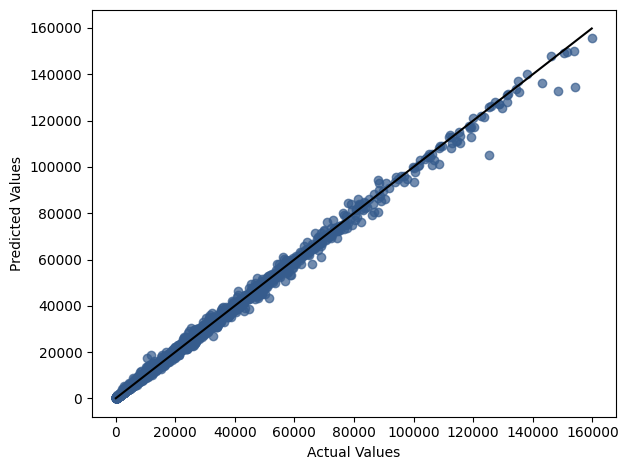

In [31]:
random_forest_all_price = random_forest_regression_multiple(x_all, y)

This is the best model of all regression models (R2 is 0.9979) so far using all the features of the df to predict price (GBP).

In [32]:
#Create dict of all the plots created in this notebook for use in report
figures_to_save = {}

figures_to_save["./price_frequency.png"] = price_frequency
figures_to_save["./price_mileage.png"] = price_mileage
figures_to_save["./price_engine.png"] = price_engine
figures_to_save["./price_engine_boxplot.png"] = price_engine_boxplot
figures_to_save["./price_year.png"] = price_year
figures_to_save["./correlation_coefficients.png"] = correlation_coefficients
figures_to_save["./price_fuel.png"] = price_fuel
figures_to_save["./price_manufacturer.png"] = price_manufacturer
figures_to_save["./linear_year_manuf_price.png"] = linear_year_manuf_price
figures_to_save["./linear_mileage_price.png"] = linear_mileage_price
figures_to_save["./linear_engine_price.png"] = linear_engine_price
figures_to_save["./poly_2_year_manuf_price.png"] = poly_2_year_manuf_price
figures_to_save["./poly_best_year_manuf_price.png"] = poly_best_year_manuf_price
figures_to_save["./poly_2_mileage_price.png"] = poly_2_mileage_price
figures_to_save["./poly_best_mileage_price.png"] = poly_best_mileage_price
figures_to_save["./poly_2_engine_price.png"] = poly_2_engine_price
figures_to_save["./decision_tree_year_manuf_price.png"] = decision_tree_year_manuf_price
figures_to_save["./decision_tree_mileage_price.png"] = decision_tree_mileage_price
figures_to_save["./random_forest_year__manuf price.png"] = random_forest_year_manuf_price
figures_to_save["./random_forest_mileage_price.png"] = random_forest_mileage_price
figures_to_save["./multiple_numerical_features_price.png"] = multiple_numerical_features_price
figures_to_save["./decision_tree_multiple_price.png"] = decision_tree_multiple_price
figures_to_save["./random_forest_multiple_price.png"] = random_forest_multiple_price
figures_to_save["./support_vector_multiple_price.png"] = support_vector_multiple_price
figures_to_save["./random_forest_all_price.png"] = random_forest_all_price

figures_to_save

{'./price_frequency.png': <Axes: xlabel='Price (GBP)', ylabel='Count'>,
 './price_mileage.png': <Axes: xlabel='Mileage', ylabel='Price (GBP)'>,
 './price_engine.png': <Axes: xlabel='Engine size (litres)', ylabel='Price (GBP)'>,
 './price_engine_boxplot.png': <Axes: xlabel='Engine size (litres)', ylabel='Price (GBP)'>,
 './price_year.png': <Axes: xlabel='Year of manufacture', ylabel='Price (GBP)'>,
 './correlation_coefficients.png': <Axes: >,
 './price_fuel.png': <Axes: xlabel='Fuel type', ylabel='Price (GBP)'>,
 './price_manufacturer.png': <Axes: xlabel='Manufacturer', ylabel='Price (GBP)'>,
 './linear_year_manuf_price.png': (LinearRegression(),
  <Figure size 640x480 with 1 Axes>),
 './linear_mileage_price.png': (LinearRegression(),
  <Figure size 640x480 with 1 Axes>),
 './linear_engine_price.png': (LinearRegression(),
  <Figure size 640x480 with 1 Axes>),
 './poly_2_year_manuf_price.png': (LinearRegression(),
  <Figure size 640x480 with 1 Axes>),
 './poly_best_year_manuf_price.png':

In [35]:
#Function to save figures in any dictionary
def save_figures(fig_dict):
    """
    Save figures from the provided dictionary.

    Parameters:
    fig_dict (dict): Dictionary where keys are filenames and values are tuples with a model/regressor and/or a figure object.

    Returns:
    None
    """
    for filename, value in fig_dict.items():
        if isinstance(value, tuple):
            #If it's a tuple, assume it contains both a model and a figure
            model, figure = value
            figure.savefig(filename)
        elif hasattr(value, 'savefig'):
            #If it's not a tuple, but it has a 'savefig' attribute, assume it's a figure
            value.savefig(filename)
        elif isinstance(value, plt.Axes):  #Check if it's an Axes object
            #If it's an Axes object, get the associated figure and save it
            value.figure.savefig(filename)
        else:
            raise ValueError(f"Invalid value for {filename}: {value}")

save_figures(figures_to_save)

**Artificial Neural Network**

Develop an Artificial Neural Network (ANN) model predicting the price of a car based on all the available information from the dataset. 

How does its performance compare to the other supervised learning models? 

Discuss your choices for the architecture of the neural network, and describe the hyperparameter tuning performed to achieve the best performance.

Tuning: No of layers, learning rate (adam optimiser), batch size, number of epochs, hidden layer units, dropout and early stopping (patience) (regularisation parameters), batch normalisation, other activation functions (relu default), other optimisers and regularisation parameters. 

Alternative regularisation parameters = Weight Regularization L1 or L2 or Elastic Net (both L1 and L2).

Mean squared error fo loss:

When comparing different models, the one with the lower MSE is generally considered better at fitting the training data.

It's essential to monitor both the training and validation MSE. If the training MSE is significantly lower than the validation MSE, it may indicate overfitting.

*First ANN model*

In [12]:
#Split between training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_all, y, test_size = 0.2, random_state = 42)

In [13]:
#Run first ANN model based on 2 hidden layers with relu activation, epochs 200, early stopping with patience 20 
#Hidden layer units of 64, dropout rate of 0.2 and default adam optimiser
#Linear last layer because this is a regression analysis with continuous variable as output
def build_and_train_ann_2_hiddenlayer(x_train, y_train, epochs=200, validation_split=0.1, patience=20,
                        hidden_layer_units=64, dropout_rate=0.2, optimizer='adam'):
    """
    Build and train a simple feedforward neural network.

    Parameters:
    x_train: Input features for training.
    y_train: Target variable for training.
    epochs: Number of training epochs.
    validation_split: Fraction of the training data to be used as validation data.
    patience: Number of epochs with no improvement after which training will be stopped.
    hidden_layer_units: Number of units in each hidden layer.
    dropout_rate: Dropout rate for the dropout layer.
    optimizer: Optimizer to use during training.

    Returns:
    model: Trained Keras model.
    history: Training history.
    """

    #Create an instance of the Sequential class
    model = Sequential()

    #First hidden layer, with input_dim = 6, specified units, and the ReLU activation function
    model.add(Dense(units=hidden_layer_units, input_dim=6, activation="relu"))
    # Add a dropout layer with the specified dropout rate
    model.add(Dropout(dropout_rate))

    #Second hidden layer with specified units and the ReLU activation function
    model.add(Dense(units=hidden_layer_units, activation="relu"))

    #The output layer, this will have 1 unit because predicting one value, price (GBP)
    #Linear activation function, because performing regression, predicting a continuous output variable
    model.add(Dense(units=1, activation="linear"))

    #Compile the model using the specified optimizer
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics='mean_squared_error')

    #Define the early stopping criterion
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

    #Train the model
    history = model.fit(x=x_train, y=y_train, batch_size=None, epochs=epochs, verbose="auto",
                        validation_split=validation_split, callbacks=[early_stopping])

    return model, history

ann_1, history_1 = build_and_train_ann_2_hiddenlayer(x_train, y_train)

Epoch 1/200
1125/1125 [==============================] - 2s 2ms/step - loss: 330640704.0000 - mean_squared_error: 330640704.0000 - val_loss: 259907840.0000 - val_mean_squared_error: 259907840.0000
Epoch 2/200
1125/1125 [==============================] - 2s 1ms/step - loss: 249918272.0000 - mean_squared_error: 249918272.0000 - val_loss: 203912512.0000 - val_mean_squared_error: 203912512.0000
Epoch 3/200
1125/1125 [==============================] - 2s 1ms/step - loss: 167507504.0000 - mean_squared_error: 167507504.0000 - val_loss: 110730344.0000 - val_mean_squared_error: 110730344.0000
Epoch 4/200
1125/1125 [==============================] - 2s 1ms/step - loss: 93889392.0000 - mean_squared_error: 93889392.0000 - val_loss: 68074248.0000 - val_mean_squared_error: 68074248.0000
Epoch 5/200
1125/1125 [==============================] - 2s 2ms/step - loss: 67308192.0000 - mean_squared_error: 67308192.0000 - val_loss: 53016564.0000 - val_mean_squared_error: 53016564.0000
Epoch 6/200
1125/1125 [

1125/1125 [==============================] - 2s 1ms/step - loss: 17457412.0000 - mean_squared_error: 17457412.0000 - val_loss: 13350459.0000 - val_mean_squared_error: 13350459.0000
Epoch 86/200
1125/1125 [==============================] - 2s 1ms/step - loss: 17222046.0000 - mean_squared_error: 17222046.0000 - val_loss: 13595162.0000 - val_mean_squared_error: 13595162.0000
Epoch 87/200
1125/1125 [==============================] - 2s 1ms/step - loss: 17196244.0000 - mean_squared_error: 17196244.0000 - val_loss: 13346784.0000 - val_mean_squared_error: 13346784.0000
Epoch 88/200
1125/1125 [==============================] - 1s 1ms/step - loss: 17043638.0000 - mean_squared_error: 17043638.0000 - val_loss: 13344744.0000 - val_mean_squared_error: 13344744.0000
Epoch 89/200
1125/1125 [==============================] - 1s 1ms/step - loss: 16668883.0000 - mean_squared_error: 16668883.0000 - val_loss: 13268048.0000 - val_mean_squared_error: 13268048.0000
Epoch 90/200
1125/1125 [===================

1125/1125 [==============================] - 2s 1ms/step - loss: 12182875.0000 - mean_squared_error: 12182875.0000 - val_loss: 7919976.5000 - val_mean_squared_error: 7919976.5000
Epoch 170/200
1125/1125 [==============================] - 2s 1ms/step - loss: 12558631.0000 - mean_squared_error: 12558631.0000 - val_loss: 8264526.0000 - val_mean_squared_error: 8264526.0000
Epoch 171/200
1125/1125 [==============================] - 2s 1ms/step - loss: 12448852.0000 - mean_squared_error: 12448852.0000 - val_loss: 8179678.0000 - val_mean_squared_error: 8179678.0000
Epoch 172/200
1125/1125 [==============================] - 2s 1ms/step - loss: 12370918.0000 - mean_squared_error: 12370918.0000 - val_loss: 8544216.0000 - val_mean_squared_error: 8544216.0000
Epoch 173/200
1125/1125 [==============================] - 1s 1ms/step - loss: 12110235.0000 - mean_squared_error: 12110235.0000 - val_loss: 7873151.0000 - val_mean_squared_error: 7873151.0000
Epoch 174/200
1125/1125 [========================

313/313 [==============================] - 0s 989us/step
R2 Score: 0.975


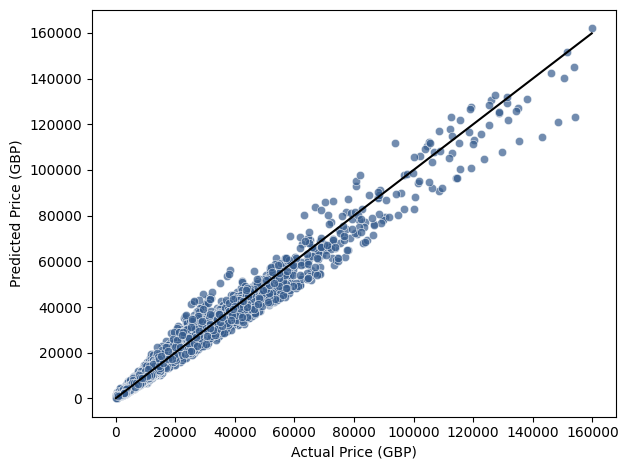

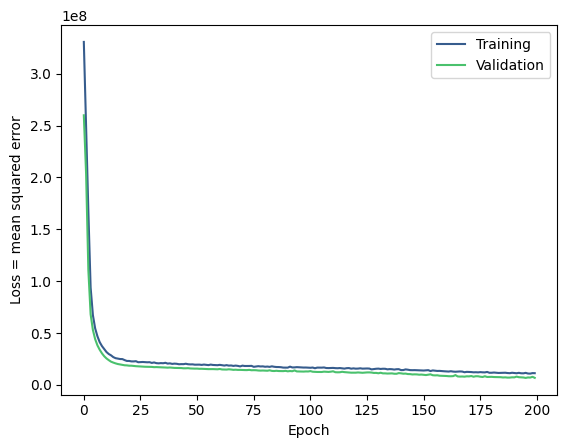

In [14]:
#Predict the model outputs for the testing set
y_pred_1 = ann_1.predict(x_test)

#PLot actual vs predicted and R2
def plot_and_score(actual, predicted):
    """
    Create a scatter plot comparing actual and predicted values with a line indicating perfect predictions.
    
    Parameters:
    actual: Series or array-like, actual target values.
    predicted: Series or array-like, predicted values from a model.
    
    Returns:
    fig: Matplotlib Figure object.
    """
    #Create df with actual and predicted values
    compare_df = pd.DataFrame({'Actual': actual.to_numpy().flatten(), 'Predicted': predicted.flatten()})

    #Create a scatter plot with sns
    fig, ax = plt.subplots()
    sns.scatterplot(x='Actual', y='Predicted', data=compare_df, color=sns.color_palette('viridis')[1], alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black')
    plt.xlabel("Actual Price (GBP)")
    plt.ylabel("Predicted Price (GBP)")
    plt.tight_layout()

    #Calculate R2 score
    r2 = r2_score(compare_df['Actual'], compare_df['Predicted'])
    print(f'R2 Score: {r2:.3f}')
    
    return fig

ann_predicted_actual_1 = plot_and_score(y_test, y_pred_1)

#Plot training and validation loss against epoch
def plot_training_history(history_df):
    """
    Plot the training and validation loss over epochs.

    Parameters:
    history_df: DataFrame, training history containing loss and validation loss.

    Returns:
    fig: Matplotlib Figure object.
    """
    #Plot the training and validation loss
    fig, ax = plt.subplots()
    plt.plot(history_df["loss"], label="Training", color=sns.color_palette('viridis')[1])
    plt.plot(history_df["val_loss"], label="Validation", color=sns.color_palette('viridis')[4])

    #Add labels and a legend
    plt.xlabel('Epoch')
    plt.ylabel('Loss = mean squared error')
    plt.legend()

    return fig

ann_loss_1 = plot_training_history(pd.DataFrame(history_1.history))

In [15]:
#Save figure as png
ann_predicted_actual_1.savefig('ann_predicted_actual_1.png')
ann_loss_1.savefig('ann_loss_1.png')

The mean squared error loss in both the training and the validation sets decrease rapidly in the first 10 epochs, and then continue to decrease gradually after that. There is no strong evidence of over-fitting, as validation loss is not increasing at later epochs while the training loss continues to decrease.
The training ran the full 200 epochs so the early stopping criterion was not triggered and the model wan't optimised early. The model may not have reached the minimum loss.

Actual vs predicted value for price (GBP) is an ok fit with R of 0.975. The higher the price, the less accurate the model becomes in its prediction with slight bias (underpredicting) at higher prices.

*Adding an extra hidden layer*

In [16]:
#Run ANN with 3 hidden layers with relu activation, epochs 200, early stopping with patience 20, 
#Hidden layer units of 64, dropout rate of 0.2 and default adam optimiser
#Incorporate ability to include regularisation in addition to drop-out
#from keras.regularizers import l1, l2, l1_l2
def build_and_train_ann_3_hiddenlayer(x_train, y_train, epochs=200, validation_split=0.1, patience=20,
                        hidden_layer_units=64, dropout_rate=0.2, optimizer='adam', 
                        regularization=None, regularization_rate=0.01, activation="relu"):
    """
    Build and train a simple feedforward neural network.

    Parameters:
    x_train: Input features for training.
    y_train: Target variable for training.
    epochs: Number of training epochs.
    validation_split: Fraction of the training data to be used as validation data.
    patience: Number of epochs with no improvement after which training will be stopped.
    hidden_layer_units: Number of units in each hidden layer.
    dropout_rate: Dropout rate for the dropout layer.
    optimizer: Optimizer to use during training.
    regularization: Type of regularization ('l1', 'l2', 'l1_l2', or None).
    regularization_rate: Regularization rate.
    activation: Activation function for hidden layers.

    Returns:
    model: Trained Keras model.
    history: Training history.
    """

    #Create a dictionary to map regularization names to functions
    regularization_map = {'l1': l1(regularization_rate),
                          'l2': l2(regularization_rate),
                          'l1_l2': l1_l2(regularization_rate),
                          None: None}

    #Create an instance of the Sequential class
    model = Sequential()

    #First hidden layer, with input_dim=6, specified units, and the specified activation function
    model.add(Dense(units=hidden_layer_units, input_dim=6, activation=activation, kernel_regularizer=regularization_map[regularization]))
    #Add a dropout layer with the specified dropout rate
    model.add(Dropout(dropout_rate))

    #Second hidden layer with specified units and the specified activation function
    model.add(Dense(units=hidden_layer_units, activation=activation, kernel_regularizer=regularization_map[regularization]))

    #Third hidden layer with specified units and the specified activation function
    model.add(Dense(units=hidden_layer_units, activation=activation, kernel_regularizer=regularization_map[regularization]))

    #The output layer, this will have 1 unit because predicting one value, price (GBP)
    #Linear activation function, because performing regression, predicting a continuous output variable
    model.add(Dense(units=1, activation="linear"))

    #Compile the model using the specified optimizer
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics='mean_squared_error')

    #Define the early stopping criterion
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

    #Train the model
    history = model.fit(x=x_train, y=y_train, batch_size=None, epochs=epochs, verbose="auto",
                        validation_split=validation_split, callbacks=[early_stopping])

    return model, history

ann_2, history_2 = build_and_train_ann_3_hiddenlayer(x_train, y_train)

Epoch 1/200
1125/1125 [==============================] - 2s 1ms/step - loss: 262634416.0000 - mean_squared_error: 262634416.0000 - val_loss: 114325928.0000 - val_mean_squared_error: 114325928.0000
Epoch 2/200
1125/1125 [==============================] - 1s 1ms/step - loss: 71848616.0000 - mean_squared_error: 71848616.0000 - val_loss: 41625044.0000 - val_mean_squared_error: 41625044.0000
Epoch 3/200
1125/1125 [==============================] - 2s 1ms/step - loss: 38742092.0000 - mean_squared_error: 38742092.0000 - val_loss: 28198630.0000 - val_mean_squared_error: 28198630.0000
Epoch 4/200
1125/1125 [==============================] - 2s 1ms/step - loss: 29605068.0000 - mean_squared_error: 29605068.0000 - val_loss: 22540768.0000 - val_mean_squared_error: 22540768.0000
Epoch 5/200
1125/1125 [==============================] - 2s 1ms/step - loss: 25956364.0000 - mean_squared_error: 25956364.0000 - val_loss: 20225304.0000 - val_mean_squared_error: 20225304.0000
Epoch 6/200
1125/1125 [========

Epoch 86/200
1125/1125 [==============================] - 2s 1ms/step - loss: 7816055.5000 - mean_squared_error: 7816055.5000 - val_loss: 3157897.5000 - val_mean_squared_error: 3157897.5000
Epoch 87/200
1125/1125 [==============================] - 2s 1ms/step - loss: 7912406.0000 - mean_squared_error: 7912406.0000 - val_loss: 3376506.5000 - val_mean_squared_error: 3376506.5000
Epoch 88/200
1125/1125 [==============================] - 2s 1ms/step - loss: 8094017.5000 - mean_squared_error: 8094017.5000 - val_loss: 3117694.5000 - val_mean_squared_error: 3117694.5000
Epoch 89/200
1125/1125 [==============================] - 2s 1ms/step - loss: 7685360.5000 - mean_squared_error: 7685360.5000 - val_loss: 3279089.7500 - val_mean_squared_error: 3279089.7500
Epoch 90/200
1125/1125 [==============================] - 1s 1ms/step - loss: 8127934.0000 - mean_squared_error: 8127934.0000 - val_loss: 3299049.0000 - val_mean_squared_error: 3299049.0000
Epoch 91/200
1125/1125 [==========================

Epoch 129/200
1125/1125 [==============================] - 2s 1ms/step - loss: 6832590.5000 - mean_squared_error: 6832590.5000 - val_loss: 2552913.0000 - val_mean_squared_error: 2552913.0000
Epoch 130/200
1125/1125 [==============================] - 2s 1ms/step - loss: 6847004.5000 - mean_squared_error: 6847004.5000 - val_loss: 2968298.2500 - val_mean_squared_error: 2968298.2500
Epoch 131/200
1125/1125 [==============================] - 2s 1ms/step - loss: 7200821.0000 - mean_squared_error: 7200821.0000 - val_loss: 3035584.5000 - val_mean_squared_error: 3035584.5000
Epoch 132/200
1125/1125 [==============================] - 2s 1ms/step - loss: 7012391.0000 - mean_squared_error: 7012391.0000 - val_loss: 2661824.0000 - val_mean_squared_error: 2661824.0000
Epoch 133/200
1125/1125 [==============================] - 2s 1ms/step - loss: 6948880.0000 - mean_squared_error: 6948880.0000 - val_loss: 2880894.2500 - val_mean_squared_error: 2880894.2500
Epoch 134/200
1125/1125 [====================

313/313 [==============================] - 0s 938us/step
R2 Score: 0.991


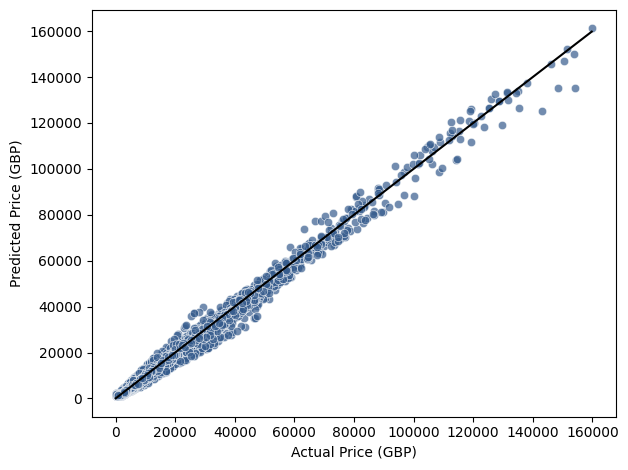

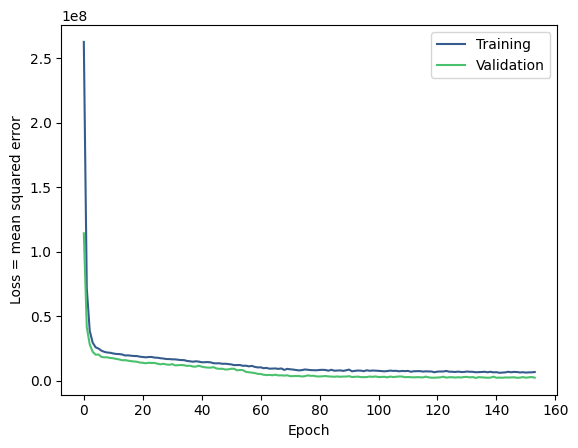

In [17]:
#Predict the model outputs for the testing set
y_pred_2 = ann_2.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_2 = plot_and_score(y_test, y_pred_2)

#Plot training and validation loss against epoch
ann_loss_2 = plot_training_history(pd.DataFrame(history_2.history))

#Save figure as png
ann_predicted_actual_2.savefig('ann_predicted_actual_2.png')
ann_loss_2.savefig('ann_loss_2.png')

The mean squared error loss in both the training and the validation sets decrease rapidly in the first 5 epochs, and then continue to decrease gradually after that.

The history of the training and validation losses look better. The training ran only 150 epochs so the early stopping criterion was triggered and the model was optimised quicker. Early stopping helps prevent overfitting and reduces unnecessary computation.

Actual vs predicted value for price (GBP) R2 is better with the extra layer but is under-predicting prices as they increase with slight bias present again. The spread of the data at higher prices is tighter as well, so this will be selected as the prefered number of layers.

*Learning rate (adam optimiser)*

Used to determine the rate of updating the weights (varies between 0 and 1).
Too small and it will take a long time to train the model.
Too large and it may never reach the minimum loss.

Reference:

Keras (n. d.) Adam. Available online: https://keras.io/api/optimizers/adam/ [Accessed 11/12/2023].

In [18]:
#Adam optimizer in Keras uses a default learning rate of 0.001
#from keras.optimizers import Adam
#Change learning rate to 0.01

adam_optimizer_01 = Adam(learning_rate = 0.01)

ann_3, history_3 = build_and_train_ann_3_hiddenlayer(x_train, y_train, optimizer=adam_optimizer_01)

Epoch 1/200
1125/1125 [==============================] - 2s 2ms/step - loss: 70108984.0000 - mean_squared_error: 70108984.0000 - val_loss: 34366652.0000 - val_mean_squared_error: 34366652.0000
Epoch 2/200
1125/1125 [==============================] - 2s 1ms/step - loss: 25830556.0000 - mean_squared_error: 25830556.0000 - val_loss: 25538040.0000 - val_mean_squared_error: 25538040.0000
Epoch 3/200
1125/1125 [==============================] - 2s 1ms/step - loss: 25008612.0000 - mean_squared_error: 25008612.0000 - val_loss: 17882144.0000 - val_mean_squared_error: 17882144.0000
Epoch 4/200
1125/1125 [==============================] - 2s 1ms/step - loss: 23732868.0000 - mean_squared_error: 23732868.0000 - val_loss: 18557946.0000 - val_mean_squared_error: 18557946.0000
Epoch 5/200
1125/1125 [==============================] - 2s 1ms/step - loss: 22653518.0000 - mean_squared_error: 22653518.0000 - val_loss: 17249686.0000 - val_mean_squared_error: 17249686.0000
Epoch 6/200
1125/1125 [============

313/313 [==============================] - 0s 1ms/step
R2 Score: 0.885


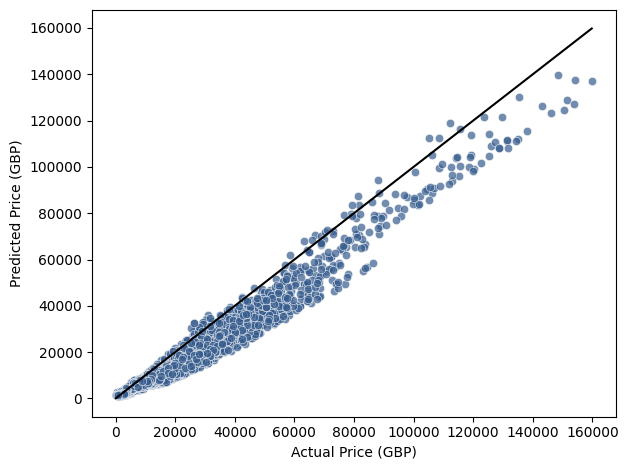

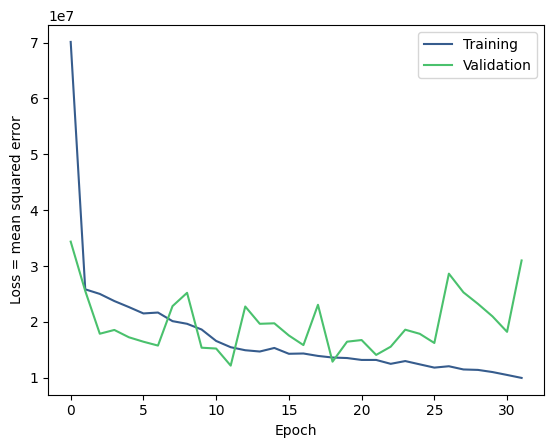

In [19]:
#Predict the model outputs for the testing set
y_pred_3 = ann_3.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_3 = plot_and_score(y_test, y_pred_3)

#Plot training and validation loss against epoch
ann_loss_3 = plot_training_history(pd.DataFrame(history_3.history))

#Save figure as png
ann_predicted_actual_3.savefig('ann_predicted_actual_3.png')
ann_loss_3.savefig('ann_loss_3.png')

Setting the learning rate to 0.01 has decreased the fit (0.932) and increased the systematic bias in the model predictions, where the model is underpredicting higher prices. The model is training too quickly.

In [20]:
#Change learning rate to 0.0001
adam_optimizer_0001 = Adam(learning_rate = 0.0001)

ann_4, history_4 = build_and_train_ann_3_hiddenlayer(x_train, y_train, optimizer=adam_optimizer_0001)

Epoch 1/200
1125/1125 [==============================] - 2s 2ms/step - loss: 443701376.0000 - mean_squared_error: 443701376.0000 - val_loss: 364034240.0000 - val_mean_squared_error: 364034240.0000
Epoch 2/200
1125/1125 [==============================] - 1s 1ms/step - loss: 312465824.0000 - mean_squared_error: 312465824.0000 - val_loss: 275552064.0000 - val_mean_squared_error: 275552064.0000
Epoch 3/200
1125/1125 [==============================] - 2s 1ms/step - loss: 286138080.0000 - mean_squared_error: 286138080.0000 - val_loss: 268491488.0000 - val_mean_squared_error: 268491488.0000
Epoch 4/200
1125/1125 [==============================] - 1s 1ms/step - loss: 278470208.0000 - mean_squared_error: 278470208.0000 - val_loss: 260604848.0000 - val_mean_squared_error: 260604848.0000
Epoch 5/200
1125/1125 [==============================] - 2s 1ms/step - loss: 269376416.0000 - mean_squared_error: 269376416.0000 - val_loss: 250849328.0000 - val_mean_squared_error: 250849328.0000
Epoch 6/200
112

1125/1125 [==============================] - 2s 1ms/step - loss: 26595540.0000 - mean_squared_error: 26595540.0000 - val_loss: 21593446.0000 - val_mean_squared_error: 21593446.0000
Epoch 44/200
1125/1125 [==============================] - 2s 1ms/step - loss: 26313272.0000 - mean_squared_error: 26313272.0000 - val_loss: 21348000.0000 - val_mean_squared_error: 21348000.0000
Epoch 45/200
1125/1125 [==============================] - 2s 1ms/step - loss: 26447758.0000 - mean_squared_error: 26447758.0000 - val_loss: 21077450.0000 - val_mean_squared_error: 21077450.0000
Epoch 46/200
1125/1125 [==============================] - 2s 1ms/step - loss: 26395916.0000 - mean_squared_error: 26395916.0000 - val_loss: 20860892.0000 - val_mean_squared_error: 20860892.0000
Epoch 47/200
1125/1125 [==============================] - 2s 1ms/step - loss: 25823314.0000 - mean_squared_error: 25823314.0000 - val_loss: 20706798.0000 - val_mean_squared_error: 20706798.0000
Epoch 48/200
1125/1125 [===================

1125/1125 [==============================] - 2s 1ms/step - loss: 20050290.0000 - mean_squared_error: 20050290.0000 - val_loss: 15770973.0000 - val_mean_squared_error: 15770973.0000
Epoch 128/200
1125/1125 [==============================] - 2s 1ms/step - loss: 19362666.0000 - mean_squared_error: 19362666.0000 - val_loss: 15491688.0000 - val_mean_squared_error: 15491688.0000
Epoch 129/200
1125/1125 [==============================] - 2s 1ms/step - loss: 19804908.0000 - mean_squared_error: 19804908.0000 - val_loss: 15481144.0000 - val_mean_squared_error: 15481144.0000
Epoch 130/200
1125/1125 [==============================] - 2s 1ms/step - loss: 19799104.0000 - mean_squared_error: 19799104.0000 - val_loss: 15405263.0000 - val_mean_squared_error: 15405263.0000
Epoch 131/200
1125/1125 [==============================] - 2s 1ms/step - loss: 20079806.0000 - mean_squared_error: 20079806.0000 - val_loss: 15548399.0000 - val_mean_squared_error: 15548399.0000
Epoch 132/200
1125/1125 [==============

313/313 [==============================] - 0s 858us/step
R2 Score: 0.945


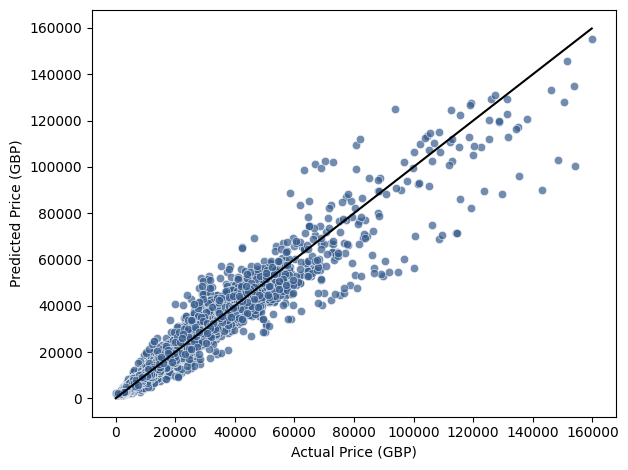

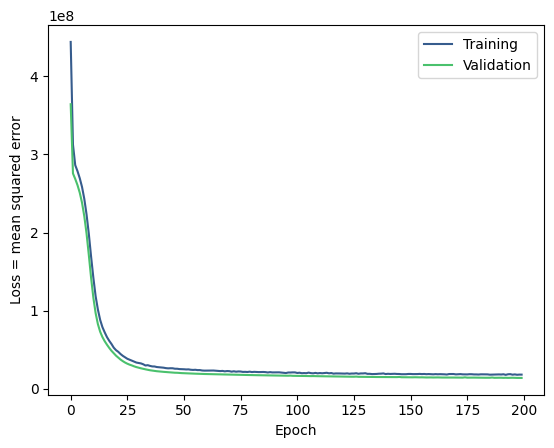

In [21]:
#Predict the model outputs for the testing set
y_pred_4 = ann_4.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_4 = plot_and_score(y_test, y_pred_4)

#Plot training and validation loss against epoch
ann_loss_4 = plot_training_history(pd.DataFrame(history_4.history))

#Save figure as png
ann_predicted_actual_4.savefig('ann_predicted_actual_4.png')
ann_loss_4.savefig('ann_loss_4.png')

Setting the learning rate to 0.0001 has reduced bias but it is still there a little in the model predictions, and slightly decreased fit of actual vs predicted price compared to default (0.001). The maximum epochs was reached (200) and fitting took up to 40 epochs. The model may not have reached the minimum loss.
 
The best learning rate for this dataset is default 0.001.

*Drop-out rate*

Regularisation technique. Try decreasing drop-out in case the model is overfitting to certain patterns in the training data that don't hold in the test data, causing the underprediction of higher prices.

Reference:

Geeks for Geeks (n. d.) Dropout in neural networks. Available online: https://www.geeksforgeeks.org/dropout-in-neural-networks/ [Accessed 11/12/2023].

Started with 0.2, change to 0.1.

In [22]:
ann_5, history_5 = build_and_train_ann_3_hiddenlayer(x_train, y_train, dropout_rate=0.1)

Epoch 1/200
1125/1125 [==============================] - 2s 1ms/step - loss: 259448688.0000 - mean_squared_error: 259448688.0000 - val_loss: 103803648.0000 - val_mean_squared_error: 103803648.0000
Epoch 2/200
1125/1125 [==============================] - 2s 1ms/step - loss: 67669464.0000 - mean_squared_error: 67669464.0000 - val_loss: 39875428.0000 - val_mean_squared_error: 39875428.0000
Epoch 3/200
1125/1125 [==============================] - 1s 1ms/step - loss: 36747128.0000 - mean_squared_error: 36747128.0000 - val_loss: 27110862.0000 - val_mean_squared_error: 27110862.0000
Epoch 4/200
1125/1125 [==============================] - 2s 1ms/step - loss: 27440882.0000 - mean_squared_error: 27440882.0000 - val_loss: 21610720.0000 - val_mean_squared_error: 21610720.0000
Epoch 5/200
1125/1125 [==============================] - 1s 1ms/step - loss: 24051486.0000 - mean_squared_error: 24051486.0000 - val_loss: 19505140.0000 - val_mean_squared_error: 19505140.0000
Epoch 6/200
1125/1125 [========

1125/1125 [==============================] - 1s 1ms/step - loss: 12193061.0000 - mean_squared_error: 12193061.0000 - val_loss: 10706182.0000 - val_mean_squared_error: 10706182.0000
Epoch 86/200
1125/1125 [==============================] - 2s 1ms/step - loss: 12101465.0000 - mean_squared_error: 12101465.0000 - val_loss: 9773726.0000 - val_mean_squared_error: 9773726.0000
Epoch 87/200
1125/1125 [==============================] - 2s 2ms/step - loss: 12131800.0000 - mean_squared_error: 12131800.0000 - val_loss: 9655711.0000 - val_mean_squared_error: 9655711.0000
Epoch 88/200
1125/1125 [==============================] - 1s 1ms/step - loss: 11825959.0000 - mean_squared_error: 11825959.0000 - val_loss: 8996095.0000 - val_mean_squared_error: 8996095.0000
Epoch 89/200
1125/1125 [==============================] - 2s 1ms/step - loss: 11574385.0000 - mean_squared_error: 11574385.0000 - val_loss: 9041447.0000 - val_mean_squared_error: 9041447.0000
Epoch 90/200
1125/1125 [===========================

Epoch 128/200
1125/1125 [==============================] - 2s 2ms/step - loss: 5896937.5000 - mean_squared_error: 5896937.5000 - val_loss: 2864102.7500 - val_mean_squared_error: 2864102.7500
Epoch 129/200
1125/1125 [==============================] - 1s 1ms/step - loss: 5911691.5000 - mean_squared_error: 5911691.5000 - val_loss: 2883506.7500 - val_mean_squared_error: 2883506.7500
Epoch 130/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5879202.0000 - mean_squared_error: 5879202.0000 - val_loss: 2939741.0000 - val_mean_squared_error: 2939741.0000
Epoch 131/200
1125/1125 [==============================] - 2s 2ms/step - loss: 5654586.0000 - mean_squared_error: 5654586.0000 - val_loss: 3059771.2500 - val_mean_squared_error: 3059771.2500
Epoch 132/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5869536.0000 - mean_squared_error: 5869536.0000 - val_loss: 3591352.0000 - val_mean_squared_error: 3591352.0000
Epoch 133/200
1125/1125 [====================

Epoch 171/200
1125/1125 [==============================] - 2s 2ms/step - loss: 5007909.0000 - mean_squared_error: 5007909.0000 - val_loss: 2635030.7500 - val_mean_squared_error: 2635030.7500
Epoch 172/200
1125/1125 [==============================] - 2s 2ms/step - loss: 5121242.5000 - mean_squared_error: 5121242.5000 - val_loss: 2595197.5000 - val_mean_squared_error: 2595197.5000
Epoch 173/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4737654.5000 - mean_squared_error: 4737654.5000 - val_loss: 3735872.2500 - val_mean_squared_error: 3735872.2500
Epoch 174/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4916432.0000 - mean_squared_error: 4916432.0000 - val_loss: 2361550.2500 - val_mean_squared_error: 2361550.2500
Epoch 175/200
1125/1125 [==============================] - 1s 1ms/step - loss: 4877401.0000 - mean_squared_error: 4877401.0000 - val_loss: 2489302.0000 - val_mean_squared_error: 2489302.0000
Epoch 176/200
1125/1125 [====================

313/313 [==============================] - 0s 1ms/step
R2 Score: 0.991


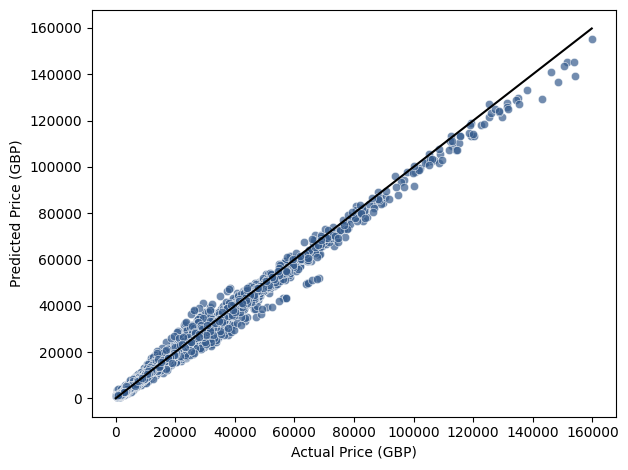

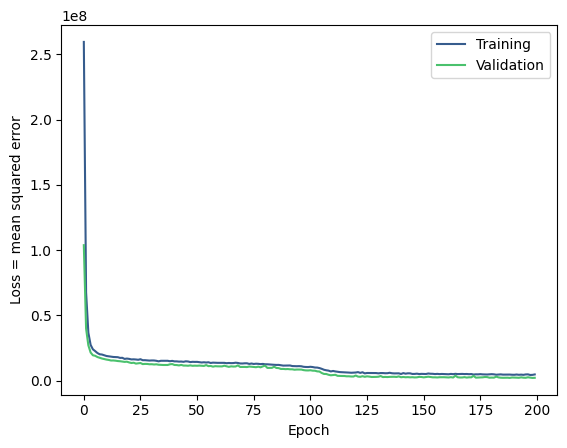

In [23]:
#Predict the model outputs for the testing set
y_pred_5 = ann_5.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_5 = plot_and_score(y_test, y_pred_5)

#Plot training and validation loss against epoch
ann_loss_5 = plot_training_history(pd.DataFrame(history_5.history))

#Save figure as png
ann_predicted_actual_5.savefig('ann_predicted_actual_5.png')
ann_loss_5.savefig('ann_loss_5.png')

Reducing the drop-out rate to 0.1 has vastly improved the actual vs predicted correlation to the best so far (R2 = 0.991), but no early stopping. There is however still bias in the predictions at the higher price predictions.

*Trying different optimisers*

Exploring 3 different types of optimiser:

RMSprop (Root Mean Square Propagation):

Adjusts the learning rates for each parameter based on the average of recent magnitudes of the gradients.
Helps mitigate issues with SGD by adapting the learning rates on a per-parameter basis.

Keras (n. d.) RMSprop. Available online: https://keras.io/api/optimizers/rmsprop/ [Accessed 11/12/2023].

Adagrad (Adaptive Gradient Algorithm):

Adapts learning rates for each parameter based on historical gradients.
Tends to perform well for sparse data.

Keras (n. d.) Adagrad. Available online: https://keras.io/api/optimizers/adagrad/ [Accessed 11/12/2023].

Adadelta:

An extension of Adagrad that addresses its tendency to decrease learning rates monotonically.
Adapts the learning rates based on a moving average of recent gradients.

Keras (n. d.) Adadelta. Available online: https://keras.io/api/optimizers/adadelta/ [Accessed 11/12/2023].

In [24]:
#from keras.optimizers import RMSprop
ann_6, history_6 = build_and_train_ann_3_hiddenlayer(x_train, y_train, dropout_rate=0.1, optimizer='rmsprop')

Epoch 1/200
1125/1125 [==============================] - 2s 2ms/step - loss: 290179200.0000 - mean_squared_error: 290179200.0000 - val_loss: 176543520.0000 - val_mean_squared_error: 176543520.0000
Epoch 2/200
1125/1125 [==============================] - 2s 1ms/step - loss: 99595896.0000 - mean_squared_error: 99595896.0000 - val_loss: 50230512.0000 - val_mean_squared_error: 50230512.0000
Epoch 3/200
1125/1125 [==============================] - 2s 1ms/step - loss: 43335032.0000 - mean_squared_error: 43335032.0000 - val_loss: 30177510.0000 - val_mean_squared_error: 30177510.0000
Epoch 4/200
1125/1125 [==============================] - 2s 2ms/step - loss: 29647394.0000 - mean_squared_error: 29647394.0000 - val_loss: 23081880.0000 - val_mean_squared_error: 23081880.0000
Epoch 5/200
1125/1125 [==============================] - 2s 1ms/step - loss: 25051066.0000 - mean_squared_error: 25051066.0000 - val_loss: 20274386.0000 - val_mean_squared_error: 20274386.0000
Epoch 6/200
1125/1125 [========

Epoch 86/200
1125/1125 [==============================] - 2s 1ms/step - loss: 8914242.0000 - mean_squared_error: 8914242.0000 - val_loss: 6065522.5000 - val_mean_squared_error: 6065522.5000
Epoch 87/200
1125/1125 [==============================] - 1s 1ms/step - loss: 8737477.0000 - mean_squared_error: 8737477.0000 - val_loss: 6162742.5000 - val_mean_squared_error: 6162742.5000
Epoch 88/200
1125/1125 [==============================] - 2s 1ms/step - loss: 8595673.0000 - mean_squared_error: 8595673.0000 - val_loss: 5815227.0000 - val_mean_squared_error: 5815227.0000
Epoch 89/200
1125/1125 [==============================] - 2s 1ms/step - loss: 8275590.5000 - mean_squared_error: 8275590.5000 - val_loss: 5803485.0000 - val_mean_squared_error: 5803485.0000
Epoch 90/200
1125/1125 [==============================] - 1s 1ms/step - loss: 8316603.0000 - mean_squared_error: 8316603.0000 - val_loss: 5356461.5000 - val_mean_squared_error: 5356461.5000
Epoch 91/200
1125/1125 [==========================

Epoch 129/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4643879.5000 - mean_squared_error: 4643879.5000 - val_loss: 1764957.0000 - val_mean_squared_error: 1764957.0000
Epoch 130/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4508519.0000 - mean_squared_error: 4508519.0000 - val_loss: 2418895.2500 - val_mean_squared_error: 2418895.2500
Epoch 131/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4659348.5000 - mean_squared_error: 4659348.5000 - val_loss: 2193109.0000 - val_mean_squared_error: 2193109.0000
Epoch 132/200
1125/1125 [==============================] - 2s 2ms/step - loss: 4603454.5000 - mean_squared_error: 4603454.5000 - val_loss: 1937938.0000 - val_mean_squared_error: 1937938.0000
Epoch 133/200
1125/1125 [==============================] - 2s 2ms/step - loss: 4291161.0000 - mean_squared_error: 4291161.0000 - val_loss: 1787682.8750 - val_mean_squared_error: 1787682.8750
Epoch 134/200
1125/1125 [====================

Epoch 172/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3716891.7500 - mean_squared_error: 3716891.7500 - val_loss: 1659233.1250 - val_mean_squared_error: 1659233.1250
Epoch 173/200
1125/1125 [==============================] - 1s 1ms/step - loss: 3669708.0000 - mean_squared_error: 3669708.0000 - val_loss: 2447114.7500 - val_mean_squared_error: 2447114.7500
Epoch 174/200
1125/1125 [==============================] - 2s 1ms/step - loss: 3612858.5000 - mean_squared_error: 3612858.5000 - val_loss: 1792486.6250 - val_mean_squared_error: 1792486.6250
Epoch 175/200
1125/1125 [==============================] - 1s 1ms/step - loss: 3580877.0000 - mean_squared_error: 3580877.0000 - val_loss: 2097553.2500 - val_mean_squared_error: 2097553.2500
Epoch 176/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3743167.7500 - mean_squared_error: 3743167.7500 - val_loss: 1981530.2500 - val_mean_squared_error: 1981530.2500
Epoch 177/200
1125/1125 [====================

313/313 [==============================] - 1s 2ms/step
R2 Score: 0.994


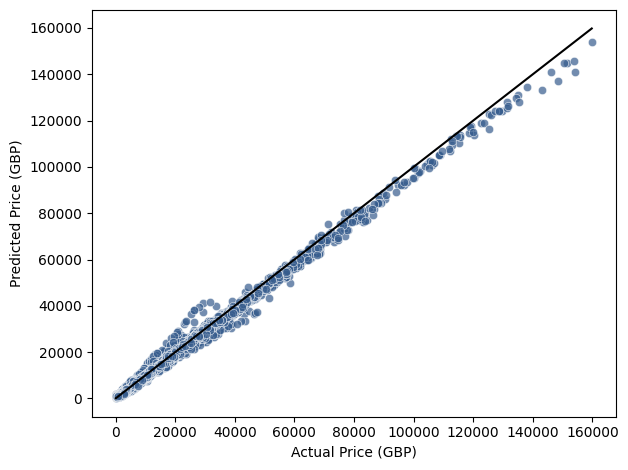

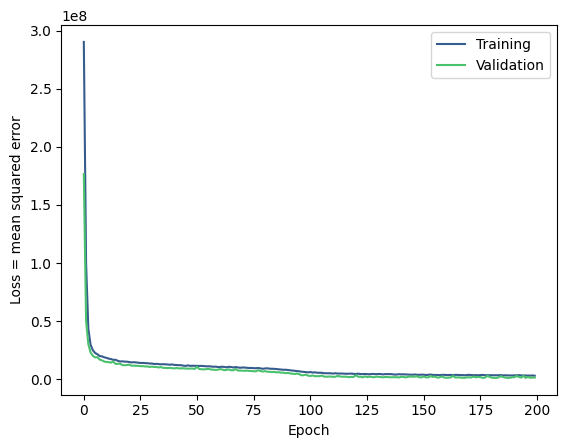

In [25]:
#Predict the model outputs for the testing set
y_pred_6 = ann_6.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_6 = plot_and_score(y_test, y_pred_6)

#Plot training and validation loss against epoch
ann_loss_6 = plot_training_history(pd.DataFrame(history_6.history))

#Save figure as png
ann_predicted_actual_6.savefig('ann_predicted_actual_6.png')
ann_loss_6.savefig('ann_loss_6.png')

In [26]:
#from keras.optimizers import Adagrad
ann_7, history_7 = build_and_train_ann_3_hiddenlayer(x_train, y_train, dropout_rate=0.1, optimizer='adagrad')

Epoch 1/200
1125/1125 [==============================] - 2s 2ms/step - loss: 458675328.0000 - mean_squared_error: 458675328.0000 - val_loss: 433559776.0000 - val_mean_squared_error: 433559776.0000
Epoch 2/200
1125/1125 [==============================] - 2s 2ms/step - loss: 438985280.0000 - mean_squared_error: 438985280.0000 - val_loss: 406718592.0000 - val_mean_squared_error: 406718592.0000
Epoch 3/200
1125/1125 [==============================] - 2s 2ms/step - loss: 406650176.0000 - mean_squared_error: 406650176.0000 - val_loss: 371592800.0000 - val_mean_squared_error: 371592800.0000
Epoch 4/200
1125/1125 [==============================] - 2s 2ms/step - loss: 370602624.0000 - mean_squared_error: 370602624.0000 - val_loss: 337338304.0000 - val_mean_squared_error: 337338304.0000
Epoch 5/200
1125/1125 [==============================] - 2s 1ms/step - loss: 338876544.0000 - mean_squared_error: 338876544.0000 - val_loss: 310422112.0000 - val_mean_squared_error: 310422112.0000
Epoch 6/200
112

1125/1125 [==============================] - 2s 1ms/step - loss: 253842160.0000 - mean_squared_error: 253842160.0000 - val_loss: 240712272.0000 - val_mean_squared_error: 240712272.0000
Epoch 84/200
1125/1125 [==============================] - 2s 1ms/step - loss: 253141888.0000 - mean_squared_error: 253141888.0000 - val_loss: 240157744.0000 - val_mean_squared_error: 240157744.0000
Epoch 85/200
1125/1125 [==============================] - 2s 1ms/step - loss: 252477616.0000 - mean_squared_error: 252477616.0000 - val_loss: 239599248.0000 - val_mean_squared_error: 239599248.0000
Epoch 86/200
1125/1125 [==============================] - 1s 1ms/step - loss: 252041520.0000 - mean_squared_error: 252041520.0000 - val_loss: 239035536.0000 - val_mean_squared_error: 239035536.0000
Epoch 87/200
1125/1125 [==============================] - 2s 1ms/step - loss: 251537648.0000 - mean_squared_error: 251537648.0000 - val_loss: 238469152.0000 - val_mean_squared_error: 238469152.0000
Epoch 88/200
1125/1125 

1125/1125 [==============================] - 2s 1ms/step - loss: 194088336.0000 - mean_squared_error: 194088336.0000 - val_loss: 181829248.0000 - val_mean_squared_error: 181829248.0000
Epoch 166/200
1125/1125 [==============================] - 2s 1ms/step - loss: 193228656.0000 - mean_squared_error: 193228656.0000 - val_loss: 180976368.0000 - val_mean_squared_error: 180976368.0000
Epoch 167/200
1125/1125 [==============================] - 1s 1ms/step - loss: 192366496.0000 - mean_squared_error: 192366496.0000 - val_loss: 180122144.0000 - val_mean_squared_error: 180122144.0000
Epoch 168/200
1125/1125 [==============================] - 1s 1ms/step - loss: 191302256.0000 - mean_squared_error: 191302256.0000 - val_loss: 179265472.0000 - val_mean_squared_error: 179265472.0000
Epoch 169/200
1125/1125 [==============================] - 1s 1ms/step - loss: 190633408.0000 - mean_squared_error: 190633408.0000 - val_loss: 178410112.0000 - val_mean_squared_error: 178410112.0000
Epoch 170/200
1125/

313/313 [==============================] - 0s 1ms/step
R2 Score: 0.393


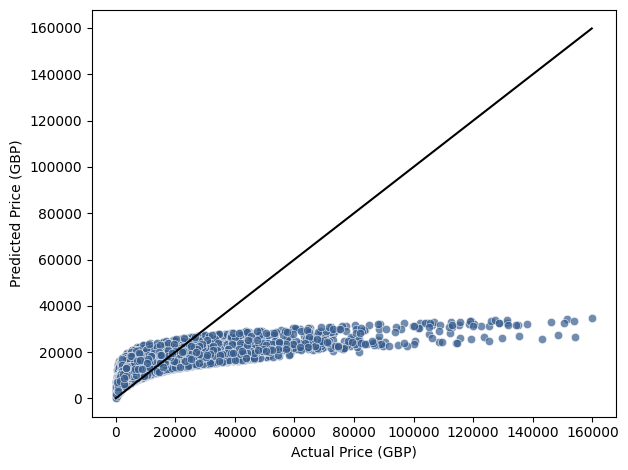

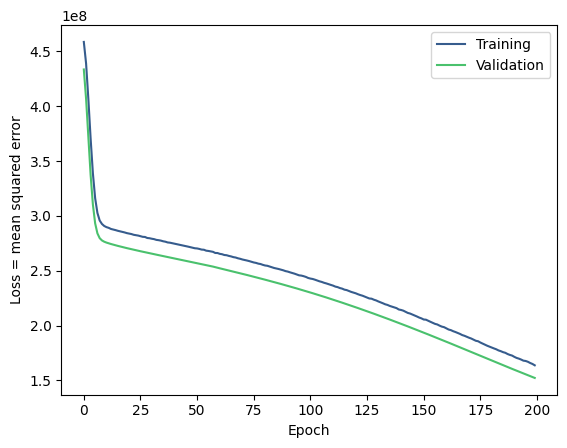

In [27]:
#Predict the model outputs for the testing set
y_pred_7 = ann_7.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_7 = plot_and_score(y_test, y_pred_7)

#Plot training and validation loss against epoch
ann_loss_7 = plot_training_history(pd.DataFrame(history_7.history))

#Save figure as png
ann_predicted_actual_7.savefig('ann_predicted_actual_7.png')
ann_loss_7.savefig('ann_loss_7.png')

In [28]:
#from keras.optimizers import Adadelta
ann_8, history_8 = build_and_train_ann_3_hiddenlayer(x_train, y_train, dropout_rate=0.1, optimizer='adadelta')

Epoch 1/200
1125/1125 [==============================] - 2s 2ms/step - loss: 462738784.0000 - mean_squared_error: 462738784.0000 - val_loss: 444539040.0000 - val_mean_squared_error: 444539040.0000
Epoch 2/200
1125/1125 [==============================] - 2s 2ms/step - loss: 462718464.0000 - mean_squared_error: 462718464.0000 - val_loss: 444515648.0000 - val_mean_squared_error: 444515648.0000
Epoch 3/200
1125/1125 [==============================] - 2s 1ms/step - loss: 462691648.0000 - mean_squared_error: 462691648.0000 - val_loss: 444485248.0000 - val_mean_squared_error: 444485248.0000
Epoch 4/200
1125/1125 [==============================] - 2s 2ms/step - loss: 462656832.0000 - mean_squared_error: 462656832.0000 - val_loss: 444446272.0000 - val_mean_squared_error: 444446272.0000
Epoch 5/200
1125/1125 [==============================] - 2s 2ms/step - loss: 462612832.0000 - mean_squared_error: 462612832.0000 - val_loss: 444398240.0000 - val_mean_squared_error: 444398240.0000
Epoch 6/200
112

1125/1125 [==============================] - 2s 2ms/step - loss: 295693888.0000 - mean_squared_error: 295693888.0000 - val_loss: 281170528.0000 - val_mean_squared_error: 281170528.0000
Epoch 84/200
1125/1125 [==============================] - 2s 1ms/step - loss: 295570624.0000 - mean_squared_error: 295570624.0000 - val_loss: 281077632.0000 - val_mean_squared_error: 281077632.0000
Epoch 85/200
1125/1125 [==============================] - 2s 2ms/step - loss: 295234464.0000 - mean_squared_error: 295234464.0000 - val_loss: 280984640.0000 - val_mean_squared_error: 280984640.0000
Epoch 86/200
1125/1125 [==============================] - 2s 1ms/step - loss: 295330240.0000 - mean_squared_error: 295330240.0000 - val_loss: 280890144.0000 - val_mean_squared_error: 280890144.0000
Epoch 87/200
1125/1125 [==============================] - 2s 2ms/step - loss: 295078464.0000 - mean_squared_error: 295078464.0000 - val_loss: 280799296.0000 - val_mean_squared_error: 280799296.0000
Epoch 88/200
1125/1125 

1125/1125 [==============================] - 2s 1ms/step - loss: 286949312.0000 - mean_squared_error: 286949312.0000 - val_loss: 272911040.0000 - val_mean_squared_error: 272911040.0000
Epoch 166/200
1125/1125 [==============================] - 2s 1ms/step - loss: 287235776.0000 - mean_squared_error: 287235776.0000 - val_loss: 272798048.0000 - val_mean_squared_error: 272798048.0000
Epoch 167/200
1125/1125 [==============================] - 2s 1ms/step - loss: 287080512.0000 - mean_squared_error: 287080512.0000 - val_loss: 272688320.0000 - val_mean_squared_error: 272688320.0000
Epoch 168/200
1125/1125 [==============================] - 2s 1ms/step - loss: 286828320.0000 - mean_squared_error: 286828320.0000 - val_loss: 272577632.0000 - val_mean_squared_error: 272577632.0000
Epoch 169/200
1125/1125 [==============================] - 2s 1ms/step - loss: 286598176.0000 - mean_squared_error: 286598176.0000 - val_loss: 272463200.0000 - val_mean_squared_error: 272463200.0000
Epoch 170/200
1125/

313/313 [==============================] - 0s 995us/step
R2 Score: -0.047


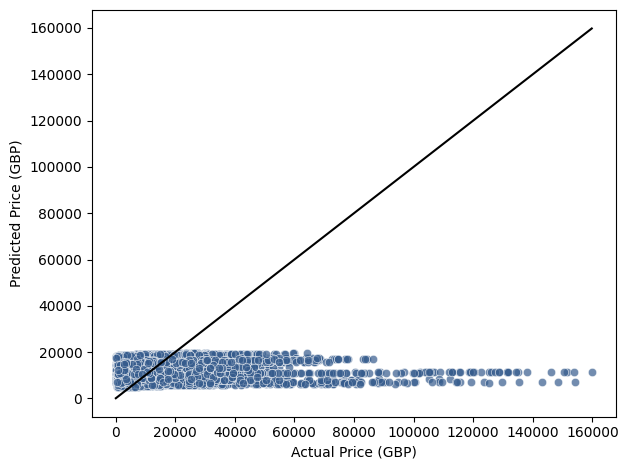

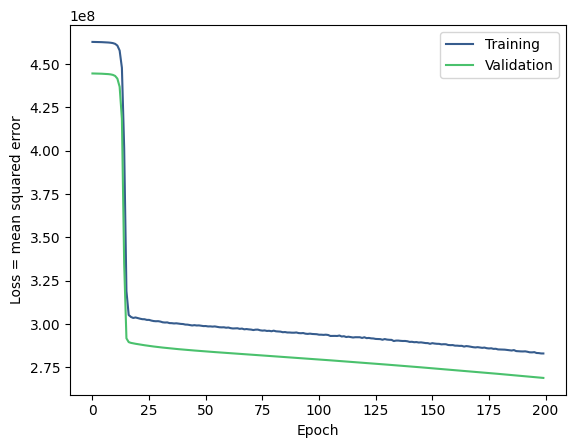

In [29]:
#Predict the model outputs for the testing set
y_pred_8 = ann_8.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_8 = plot_and_score(y_test, y_pred_8)

#Plot training and validation loss against epoch
ann_loss_8 = plot_training_history(pd.DataFrame(history_8.history))

#Save figure as png
ann_predicted_actual_8.savefig('ann_predicted_actual_8.png')
ann_loss_8.savefig('ann_loss_8.png')

None of the additional tested optimisers show improved fit over Adam optimiser. RMSprop showed slightly better fit but took the full 200 epochs to train the model and bias is more pronounced.

*Additional regularisation*

Try L1, L2 or Elastic Net (L1 and L2) regularisation

Geeks for Geeks (n. d.) Regularization in machine learning. Available online: https://www.geeksforgeeks.org/regularization-in-machine-learning/ [Accessed 11/12/2023].

Lasso (L1):

Scikit learn (n. d.) sklearn.linear_model.Lasso. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html [Accessed 11/12/2023].

Ridge (L2):

Scikit learn (n. d.) sklearn.linear_model.Ridge. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html [Accessed 11/12/2023].

Elastic Net:

Scikit learn (n. d.) sklearn.linear_model.ElasticNetCV. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html [Accessed 11/12/2023].

In [30]:
#Using L1 regularisation with dropout rate 0.1, regularisation rate 0.01
ann_l1, history_l1 = build_and_train_ann_3_hiddenlayer(x_train, y_train, dropout_rate=0.1, regularization='l1', regularization_rate=0.01)

Epoch 1/200
1125/1125 [==============================] - 2s 2ms/step - loss: 229696352.0000 - mean_squared_error: 229696352.0000 - val_loss: 71658568.0000 - val_mean_squared_error: 71658544.0000
Epoch 2/200
1125/1125 [==============================] - 2s 2ms/step - loss: 54175308.0000 - mean_squared_error: 54175244.0000 - val_loss: 34374552.0000 - val_mean_squared_error: 34374520.0000
Epoch 3/200
1125/1125 [==============================] - 3s 2ms/step - loss: 31970486.0000 - mean_squared_error: 31970434.0000 - val_loss: 23694006.0000 - val_mean_squared_error: 23693964.0000
Epoch 4/200
1125/1125 [==============================] - 2s 2ms/step - loss: 25086024.0000 - mean_squared_error: 25085984.0000 - val_loss: 20572268.0000 - val_mean_squared_error: 20572208.0000
Epoch 5/200
1125/1125 [==============================] - 2s 2ms/step - loss: 22776968.0000 - mean_squared_error: 22776928.0000 - val_loss: 19991602.0000 - val_mean_squared_error: 19991548.0000
Epoch 6/200
1125/1125 [==========

1125/1125 [==============================] - 1s 1ms/step - loss: 4356472.0000 - mean_squared_error: 4356386.5000 - val_loss: 2458370.7500 - val_mean_squared_error: 2458283.0000
Epoch 87/200
1125/1125 [==============================] - 1s 1ms/step - loss: 4443658.5000 - mean_squared_error: 4443573.0000 - val_loss: 2125971.2500 - val_mean_squared_error: 2125884.7500
Epoch 88/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4174044.2500 - mean_squared_error: 4173956.0000 - val_loss: 1821789.2500 - val_mean_squared_error: 1821702.2500
Epoch 89/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4139359.7500 - mean_squared_error: 4139271.5000 - val_loss: 1952042.7500 - val_mean_squared_error: 1951956.5000
Epoch 90/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4597580.0000 - mean_squared_error: 4597491.5000 - val_loss: 2313901.5000 - val_mean_squared_error: 2313815.0000
Epoch 91/200
1125/1125 [==============================] - 2s 1m

1125/1125 [==============================] - 2s 2ms/step - loss: 3497736.2500 - mean_squared_error: 3497648.0000 - val_loss: 1891333.3750 - val_mean_squared_error: 1891245.2500
Epoch 130/200
1125/1125 [==============================] - 2s 1ms/step - loss: 3646252.2500 - mean_squared_error: 3646166.0000 - val_loss: 1688787.3750 - val_mean_squared_error: 1688698.3750
Epoch 131/200
1125/1125 [==============================] - 2s 1ms/step - loss: 3474458.2500 - mean_squared_error: 3474366.7500 - val_loss: 1641609.2500 - val_mean_squared_error: 1641520.3750
Epoch 132/200
1125/1125 [==============================] - 2s 1ms/step - loss: 3597572.2500 - mean_squared_error: 3597480.7500 - val_loss: 1656651.8750 - val_mean_squared_error: 1656563.7500
Epoch 133/200
1125/1125 [==============================] - 2s 1ms/step - loss: 3484143.2500 - mean_squared_error: 3484057.5000 - val_loss: 1602440.8750 - val_mean_squared_error: 1602352.1250
Epoch 134/200
1125/1125 [==============================] - 

Epoch 172/200
1125/1125 [==============================] - 3s 3ms/step - loss: 3117979.7500 - mean_squared_error: 3117886.7500 - val_loss: 1687209.1250 - val_mean_squared_error: 1687118.0000
Epoch 173/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3340008.2500 - mean_squared_error: 3339912.2500 - val_loss: 1574205.8750 - val_mean_squared_error: 1574114.5000
Epoch 174/200
1125/1125 [==============================] - 2s 1ms/step - loss: 3069258.2500 - mean_squared_error: 3069162.5000 - val_loss: 1516904.2500 - val_mean_squared_error: 1516813.0000
Epoch 175/200
1125/1125 [==============================] - 2s 1ms/step - loss: 3283535.2500 - mean_squared_error: 3283444.5000 - val_loss: 1404637.6250 - val_mean_squared_error: 1404545.8750
Epoch 176/200
1125/1125 [==============================] - 2s 1ms/step - loss: 3144243.5000 - mean_squared_error: 3144150.0000 - val_loss: 1385562.0000 - val_mean_squared_error: 1385470.5000
Epoch 177/200
1125/1125 [====================

313/313 [==============================] - 0s 924us/step
R2 Score: 0.996


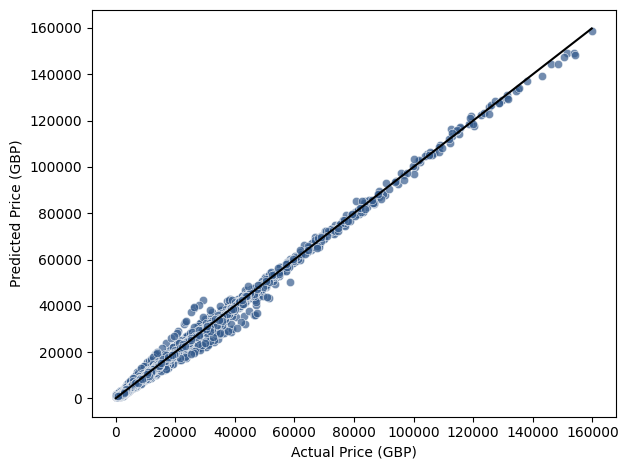

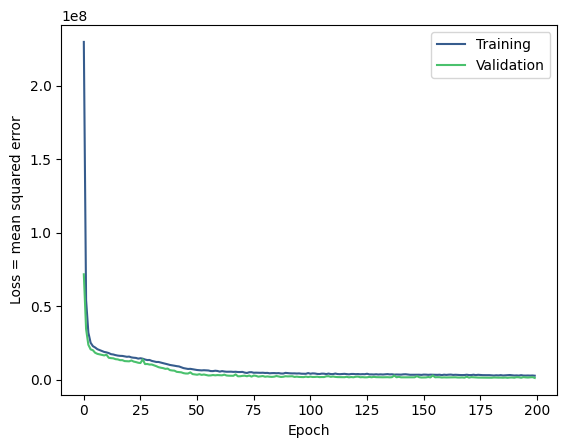

In [31]:
#Predict the model outputs for the testing set
y_pred_l1 = ann_l1.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_l1 = plot_and_score(y_test, y_pred_l1)

#Plot training and validation loss against epoch
ann_loss_l1 = plot_training_history(pd.DataFrame(history_l1.history))

#Save figure as png
ann_predicted_actual_l1.savefig('ann_predicted_actual_l1.png')
ann_loss_l1.savefig('ann_loss_l1.png')

In [32]:
#Using L2 regularisation with dropout 0.1, regularisation rate 0.01
ann_l2, history_l2 = build_and_train_ann_3_hiddenlayer(x_train, y_train, dropout_rate=0.1, regularization='l2', regularization_rate=0.01)

Epoch 1/200
1125/1125 [==============================] - 2s 1ms/step - loss: 248725808.0000 - mean_squared_error: 248725808.0000 - val_loss: 91937568.0000 - val_mean_squared_error: 91937536.0000
Epoch 2/200
1125/1125 [==============================] - 2s 1ms/step - loss: 63174068.0000 - mean_squared_error: 63174048.0000 - val_loss: 40883864.0000 - val_mean_squared_error: 40883832.0000
Epoch 3/200
1125/1125 [==============================] - 2s 1ms/step - loss: 35541104.0000 - mean_squared_error: 35541052.0000 - val_loss: 25850810.0000 - val_mean_squared_error: 25850776.0000
Epoch 4/200
1125/1125 [==============================] - 1s 1ms/step - loss: 26810008.0000 - mean_squared_error: 26809948.0000 - val_loss: 21402344.0000 - val_mean_squared_error: 21402290.0000
Epoch 5/200
1125/1125 [==============================] - 1s 1ms/step - loss: 23778356.0000 - mean_squared_error: 23778298.0000 - val_loss: 19655754.0000 - val_mean_squared_error: 19655692.0000
Epoch 6/200
1125/1125 [==========

1125/1125 [==============================] - 2s 1ms/step - loss: 6093900.0000 - mean_squared_error: 6093714.5000 - val_loss: 2977004.7500 - val_mean_squared_error: 2976818.0000
Epoch 87/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5909686.5000 - mean_squared_error: 5909501.5000 - val_loss: 2835009.0000 - val_mean_squared_error: 2834821.7500
Epoch 88/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5952495.5000 - mean_squared_error: 5952306.5000 - val_loss: 3084546.5000 - val_mean_squared_error: 3084356.5000
Epoch 89/200
1125/1125 [==============================] - 2s 1ms/step - loss: 6275468.0000 - mean_squared_error: 6275283.5000 - val_loss: 3088950.0000 - val_mean_squared_error: 3088760.0000
Epoch 90/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5704753.5000 - mean_squared_error: 5704557.5000 - val_loss: 3169860.5000 - val_mean_squared_error: 3169670.2500
Epoch 91/200
1125/1125 [==============================] - 1s 1m

1125/1125 [==============================] - 1s 1ms/step - loss: 5471718.5000 - mean_squared_error: 5471494.0000 - val_loss: 2431971.5000 - val_mean_squared_error: 2431751.7500
Epoch 130/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5251336.0000 - mean_squared_error: 5251119.5000 - val_loss: 2513750.5000 - val_mean_squared_error: 2513530.0000
Epoch 131/200
1125/1125 [==============================] - 1s 1ms/step - loss: 5182538.5000 - mean_squared_error: 5182313.0000 - val_loss: 2235606.5000 - val_mean_squared_error: 2235384.5000
Epoch 132/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5214580.0000 - mean_squared_error: 5214369.0000 - val_loss: 2176897.2500 - val_mean_squared_error: 2176676.0000
Epoch 133/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5301575.0000 - mean_squared_error: 5301356.5000 - val_loss: 2575213.2500 - val_mean_squared_error: 2574991.0000
Epoch 134/200
1125/1125 [==============================] - 

Epoch 172/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4317791.0000 - mean_squared_error: 4317546.0000 - val_loss: 1716963.0000 - val_mean_squared_error: 1716715.2500
Epoch 173/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4201746.5000 - mean_squared_error: 4201501.0000 - val_loss: 2072181.2500 - val_mean_squared_error: 2071933.5000
Epoch 174/200
1125/1125 [==============================] - 1s 1ms/step - loss: 4457916.0000 - mean_squared_error: 4457667.5000 - val_loss: 1960287.1250 - val_mean_squared_error: 1960037.3750
Epoch 175/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4806783.5000 - mean_squared_error: 4806532.0000 - val_loss: 2236188.0000 - val_mean_squared_error: 2235939.2500
Epoch 176/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4326342.0000 - mean_squared_error: 4326093.5000 - val_loss: 1851752.2500 - val_mean_squared_error: 1851502.8750
Epoch 177/200
1125/1125 [====================

313/313 [==============================] - 0s 1ms/step
R2 Score: 0.994


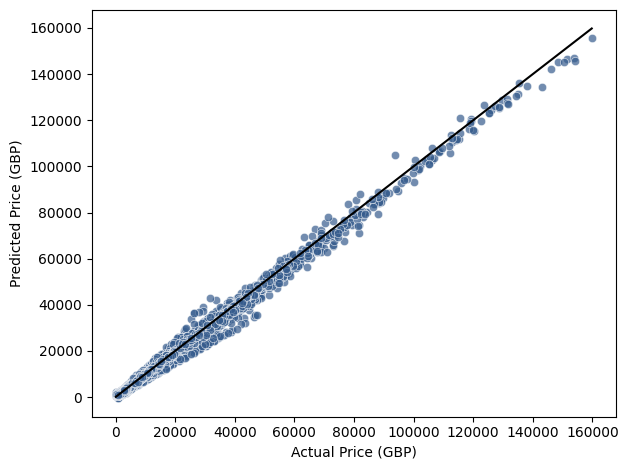

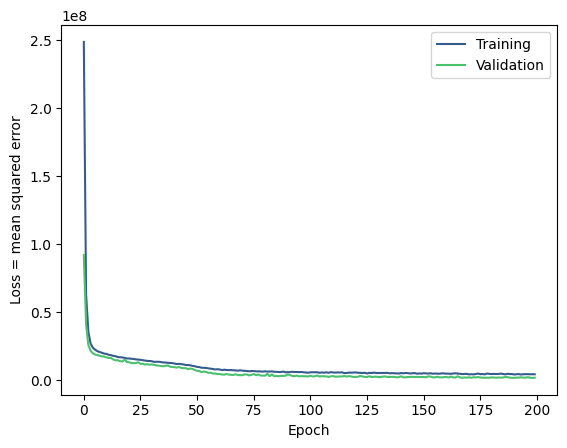

In [33]:
#Predict the model outputs for the testing set
y_pred_l2 = ann_l2.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_l2 = plot_and_score(y_test, y_pred_l2)

#Plot training and validation loss against epoch
ann_loss_l2 = plot_training_history(pd.DataFrame(history_l2.history))

#Save figure as png
ann_predicted_actual_l2.savefig('ann_predicted_actual_l2.png')
ann_loss_l2.savefig('ann_loss_l2.png')

In [34]:
#Using elastic net regularisation with dropout 0.1
ann_elastic, history_elastic = build_and_train_ann_3_hiddenlayer(x_train, y_train, dropout_rate=0.1, regularization='l1_l2', regularization_rate=0.01)

Epoch 1/200
1125/1125 [==============================] - 3s 2ms/step - loss: 249069280.0000 - mean_squared_error: 249069248.0000 - val_loss: 87138792.0000 - val_mean_squared_error: 87138744.0000
Epoch 2/200
1125/1125 [==============================] - 2s 1ms/step - loss: 61259472.0000 - mean_squared_error: 61259396.0000 - val_loss: 37466260.0000 - val_mean_squared_error: 37466188.0000
Epoch 3/200
1125/1125 [==============================] - 2s 1ms/step - loss: 35350196.0000 - mean_squared_error: 35350104.0000 - val_loss: 26097942.0000 - val_mean_squared_error: 26097850.0000
Epoch 4/200
1125/1125 [==============================] - 2s 1ms/step - loss: 27247154.0000 - mean_squared_error: 27247060.0000 - val_loss: 21345440.0000 - val_mean_squared_error: 21345340.0000
Epoch 5/200
1125/1125 [==============================] - 2s 2ms/step - loss: 23677624.0000 - mean_squared_error: 23677520.0000 - val_loss: 19458160.0000 - val_mean_squared_error: 19458062.0000
Epoch 6/200
1125/1125 [==========

Epoch 86/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5990086.0000 - mean_squared_error: 5989770.0000 - val_loss: 3012737.0000 - val_mean_squared_error: 3012420.5000
Epoch 87/200
1125/1125 [==============================] - 1s 1ms/step - loss: 6004985.0000 - mean_squared_error: 6004669.5000 - val_loss: 2949866.2500 - val_mean_squared_error: 2949549.7500
Epoch 88/200
1125/1125 [==============================] - 1s 1ms/step - loss: 6007129.0000 - mean_squared_error: 6006809.5000 - val_loss: 3319929.0000 - val_mean_squared_error: 3319613.0000
Epoch 89/200
1125/1125 [==============================] - 1s 1ms/step - loss: 5691615.0000 - mean_squared_error: 5691294.5000 - val_loss: 3090887.7500 - val_mean_squared_error: 3090568.2500
Epoch 90/200
1125/1125 [==============================] - 1s 1ms/step - loss: 5987871.5000 - mean_squared_error: 5987549.0000 - val_loss: 2974160.7500 - val_mean_squared_error: 2973840.7500
Epoch 91/200
1125/1125 [==========================

Epoch 129/200
1125/1125 [==============================] - 1s 1ms/step - loss: 5500880.0000 - mean_squared_error: 5500520.0000 - val_loss: 2584035.0000 - val_mean_squared_error: 2583680.7500
Epoch 130/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4873266.0000 - mean_squared_error: 4872908.0000 - val_loss: 2516426.5000 - val_mean_squared_error: 2516071.2500
Epoch 131/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5668267.5000 - mean_squared_error: 5667909.5000 - val_loss: 2722071.2500 - val_mean_squared_error: 2721713.7500
Epoch 132/200
1125/1125 [==============================] - 1s 1ms/step - loss: 5222212.0000 - mean_squared_error: 5221864.5000 - val_loss: 2872252.7500 - val_mean_squared_error: 2871895.7500
Epoch 133/200
1125/1125 [==============================] - 1s 1ms/step - loss: 5003036.0000 - mean_squared_error: 5002678.5000 - val_loss: 2482827.7500 - val_mean_squared_error: 2482470.2500
Epoch 134/200
1125/1125 [====================

313/313 [==============================] - 0s 997us/step
R2 Score: 0.989


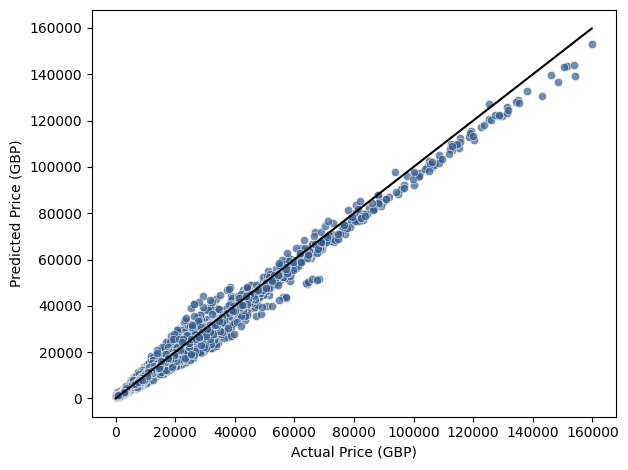

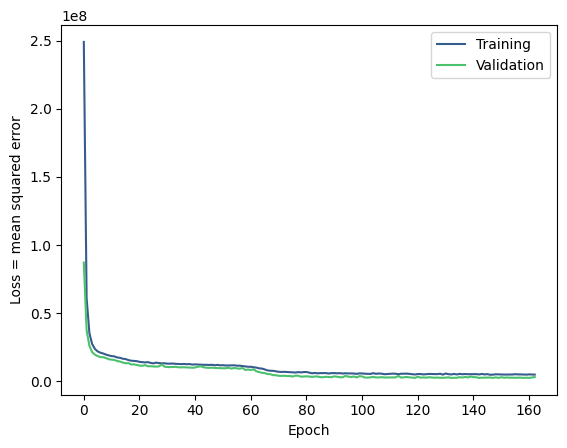

In [35]:
#Predict the model outputs for the testing set
y_pred_elastic = ann_elastic.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_elastic = plot_and_score(y_test, y_pred_elastic)

#Plot training and validation loss against epoch
ann_loss_elastic = plot_training_history(pd.DataFrame(history_elastic.history))

#Save figure as png
ann_predicted_actual_elastic.savefig('ann_predicted_actual_elastic.png')
ann_loss_elastic.savefig('ann_loss_elastic.png')

L1 regularisation, regularisation rate of 0.01, provides the best fit (0.996), closley followed by L2. This is improved over drop-out of 0.1 alone. L1 and L2 regularisation does a better job at accounting for the top fit of the curve. There is no early stopping for L1 and L2.

In [36]:
#Changing regularisation rate
#Using L1 regularisation with dropout 0.1, with regularisation_rate of 0.05
ann_l1_2, history_l1_2 = build_and_train_ann_3_hiddenlayer(x_train, y_train, dropout_rate=0.1, regularization='l1', regularization_rate=0.05)

Epoch 1/200
1125/1125 [==============================] - 3s 2ms/step - loss: 260688816.0000 - mean_squared_error: 260688720.0000 - val_loss: 108662944.0000 - val_mean_squared_error: 108662800.0000
Epoch 2/200
1125/1125 [==============================] - 2s 2ms/step - loss: 64860892.0000 - mean_squared_error: 64860748.0000 - val_loss: 38962360.0000 - val_mean_squared_error: 38962136.0000
Epoch 3/200
1125/1125 [==============================] - 2s 2ms/step - loss: 34419764.0000 - mean_squared_error: 34419584.0000 - val_loss: 25313602.0000 - val_mean_squared_error: 25313378.0000
Epoch 4/200
1125/1125 [==============================] - 2s 1ms/step - loss: 26746598.0000 - mean_squared_error: 26746358.0000 - val_loss: 21729854.0000 - val_mean_squared_error: 21729612.0000
Epoch 5/200
1125/1125 [==============================] - 2s 1ms/step - loss: 24038804.0000 - mean_squared_error: 24038550.0000 - val_loss: 20728696.0000 - val_mean_squared_error: 20728442.0000
Epoch 6/200
1125/1125 [========

1125/1125 [==============================] - 2s 1ms/step - loss: 12703708.0000 - mean_squared_error: 12703362.0000 - val_loss: 11277257.0000 - val_mean_squared_error: 11276919.0000
Epoch 86/200
1125/1125 [==============================] - 2s 1ms/step - loss: 12903089.0000 - mean_squared_error: 12902751.0000 - val_loss: 11447198.0000 - val_mean_squared_error: 11446850.0000
Epoch 87/200
1125/1125 [==============================] - 2s 1ms/step - loss: 12560178.0000 - mean_squared_error: 12559834.0000 - val_loss: 12447191.0000 - val_mean_squared_error: 12446847.0000
Epoch 88/200
1125/1125 [==============================] - 2s 1ms/step - loss: 12910056.0000 - mean_squared_error: 12909729.0000 - val_loss: 12137886.0000 - val_mean_squared_error: 12137538.0000
Epoch 89/200
1125/1125 [==============================] - 2s 1ms/step - loss: 12851814.0000 - mean_squared_error: 12851470.0000 - val_loss: 11838264.0000 - val_mean_squared_error: 11837918.0000
Epoch 90/200
1125/1125 [===================

313/313 [==============================] - 0s 976us/step
R2 Score: 0.953


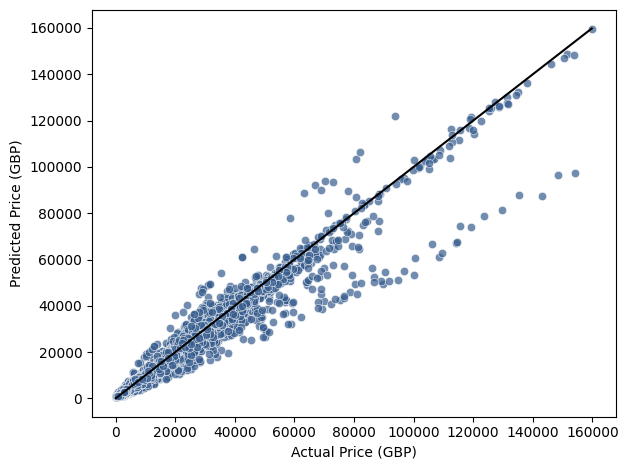

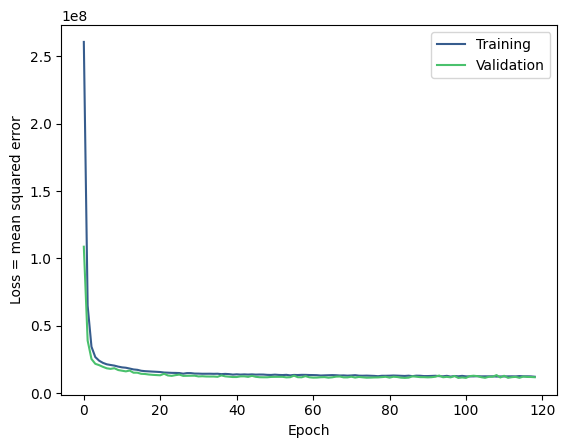

In [37]:
#Predict the model outputs for the testing set
y_pred_l1_2 = ann_l1_2.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_l1_2 = plot_and_score(y_test, y_pred_l1_2)

#Plot training and validation loss against epoch
ann_loss_l1_2 = plot_training_history(pd.DataFrame(history_l1_2.history))

#Save figure as png
ann_predicted_actual_l1_2.savefig('ann_predicted_actual_l1_2.png')
ann_loss_l1_2.savefig('ann_loss_l1_2.png')

In [38]:
#Using L1 regularisation with dropout 0.1, with regularisation_rate of 0.005
ann_l1_3, history_l1_3 = build_and_train_ann_3_hiddenlayer(x_train, y_train, dropout_rate=0.1, regularization='l1', regularization_rate=0.005)

Epoch 1/200
1125/1125 [==============================] - 3s 2ms/step - loss: 256444576.0000 - mean_squared_error: 256444576.0000 - val_loss: 101195128.0000 - val_mean_squared_error: 101195112.0000
Epoch 2/200
1125/1125 [==============================] - 2s 1ms/step - loss: 69244392.0000 - mean_squared_error: 69244384.0000 - val_loss: 42072580.0000 - val_mean_squared_error: 42072564.0000
Epoch 3/200
1125/1125 [==============================] - 2s 1ms/step - loss: 38934232.0000 - mean_squared_error: 38934216.0000 - val_loss: 27807270.0000 - val_mean_squared_error: 27807252.0000
Epoch 4/200
1125/1125 [==============================] - 1s 1ms/step - loss: 28107408.0000 - mean_squared_error: 28107384.0000 - val_loss: 21398488.0000 - val_mean_squared_error: 21398462.0000
Epoch 5/200
1125/1125 [==============================] - 2s 1ms/step - loss: 24120270.0000 - mean_squared_error: 24120252.0000 - val_loss: 19952522.0000 - val_mean_squared_error: 19952502.0000
Epoch 6/200
1125/1125 [========

1125/1125 [==============================] - 1s 1ms/step - loss: 5894448.0000 - mean_squared_error: 5894403.5000 - val_loss: 3569694.7500 - val_mean_squared_error: 3569653.0000
Epoch 87/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5947874.0000 - mean_squared_error: 5947829.0000 - val_loss: 3929194.0000 - val_mean_squared_error: 3929150.7500
Epoch 88/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5760165.0000 - mean_squared_error: 5760123.0000 - val_loss: 3945340.2500 - val_mean_squared_error: 3945297.2500
Epoch 89/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5757173.0000 - mean_squared_error: 5757128.0000 - val_loss: 3317775.5000 - val_mean_squared_error: 3317733.5000
Epoch 90/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5630409.0000 - mean_squared_error: 5630367.5000 - val_loss: 4166425.5000 - val_mean_squared_error: 4166382.5000
Epoch 91/200
1125/1125 [==============================] - 2s 1m

1125/1125 [==============================] - 2s 1ms/step - loss: 4438340.0000 - mean_squared_error: 4438291.5000 - val_loss: 2637708.2500 - val_mean_squared_error: 2637664.5000
Epoch 130/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4404169.0000 - mean_squared_error: 4404124.0000 - val_loss: 2070778.8750 - val_mean_squared_error: 2070733.6250
Epoch 131/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4293247.5000 - mean_squared_error: 4293205.5000 - val_loss: 2290699.5000 - val_mean_squared_error: 2290655.0000
Epoch 132/200
1125/1125 [==============================] - 2s 2ms/step - loss: 4126647.2500 - mean_squared_error: 4126599.5000 - val_loss: 2053093.6250 - val_mean_squared_error: 2053048.6250
Epoch 133/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4177544.0000 - mean_squared_error: 4177495.7500 - val_loss: 2381043.2500 - val_mean_squared_error: 2380998.7500
Epoch 134/200
1125/1125 [==============================] - 

Epoch 172/200
1125/1125 [==============================] - 2s 1ms/step - loss: 3471611.7500 - mean_squared_error: 3471563.2500 - val_loss: 1972325.3750 - val_mean_squared_error: 1972279.1250
Epoch 173/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3513835.2500 - mean_squared_error: 3513787.2500 - val_loss: 2261817.5000 - val_mean_squared_error: 2261771.2500
Epoch 174/200
1125/1125 [==============================] - 1s 1ms/step - loss: 3603543.2500 - mean_squared_error: 3603497.5000 - val_loss: 2024154.1250 - val_mean_squared_error: 2024107.2500
Epoch 175/200
1125/1125 [==============================] - 2s 1ms/step - loss: 3492806.0000 - mean_squared_error: 3492758.0000 - val_loss: 3202384.5000 - val_mean_squared_error: 3202337.7500
Epoch 176/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3500172.7500 - mean_squared_error: 3500123.5000 - val_loss: 2462633.0000 - val_mean_squared_error: 2462585.2500
Epoch 177/200
1125/1125 [====================

313/313 [==============================] - 0s 989us/step
R2 Score: 0.993


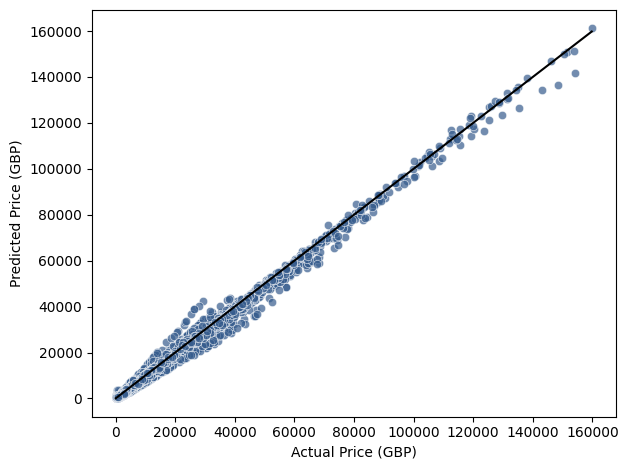

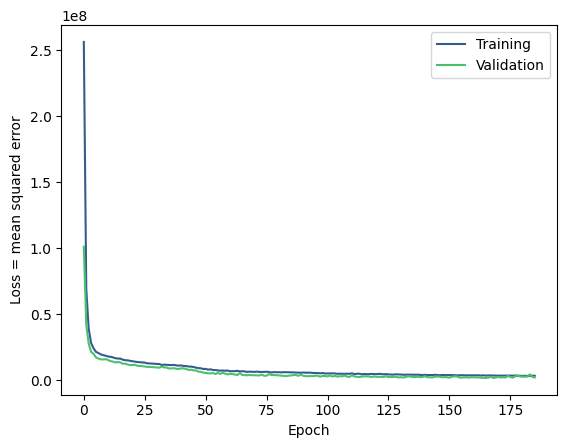

In [39]:
#Predict the model outputs for the testing set
y_pred_l1_3 = ann_l1_3.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_l1_3 = plot_and_score(y_test, y_pred_l1_3)

#Plot training and validation loss against epoch
ann_loss_l1_3 = plot_training_history(pd.DataFrame(history_l1_3.history))

#Save figure as png
ann_predicted_actual_l1_3.savefig('ann_predicted_actual_l1_3.png')
ann_loss_l1_3.savefig('ann_loss_l1_3.png')

Changing regularisation rate to 0.005, slightly reduced the fit (0.993) compared to  0.01 rate (0.996), and the model underwent early stopping , indicating the minimum loss was achieved, preventing overfitting. 

Regularisation rate for L1 of 0.05, the R2 was was much reduced (0.956) with higher variability at higher prices, but againe arly stopping was achieved.

The ANN model with L1 regularisation with regularisation rate of 0.01, and dropout of 0.1 will be used to see the effects of chnaging activation function in the hidden layers.

Then L1 with regularisation rate of 0.005 will be run with the most effective activation function, as early stopping is desirable.

*Activation functions*

Leaky ReLU: activation="leaky_relu" or a parameterized version activation=LeakyReLU(alpha=0.01)

TensorFlow (n. d.) tf.keras.layers.LeakyReLU. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU [Accessed 11/12/2023].

ELU (Exponential Linear Unit): activation="elu"

TensorFlow (n. d.) tf.keras.layers.ELU. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/layers/ELU [Accessed 11/12/2023].

Selu (Scaled Exponential Linear Unit): activation="selu"

TensorFlow (n. d.) tf.keras.activations.selu. Available online: https://www.tensorflow.org/api_docs/python/tf/keras/activations/selu [Accessed 11/12/2023].

In [41]:
#Using L1 regularisation with dropout 0.1, with regularisation_rate of 0.01, activation function for hidden layers leaky relu
ann_l1_4, history_l1_4 = build_and_train_ann_3_hiddenlayer(x_train, y_train, dropout_rate=0.1, regularization='l1', regularization_rate=0.01, activation='leaky_relu')

Epoch 1/200
1125/1125 [==============================] - 3s 2ms/step - loss: 287868000.0000 - mean_squared_error: 287867968.0000 - val_loss: 175456352.0000 - val_mean_squared_error: 175456320.0000
Epoch 2/200
1125/1125 [==============================] - 2s 2ms/step - loss: 87983056.0000 - mean_squared_error: 87983000.0000 - val_loss: 48039220.0000 - val_mean_squared_error: 48039160.0000
Epoch 3/200
1125/1125 [==============================] - 2s 2ms/step - loss: 44989820.0000 - mean_squared_error: 44989752.0000 - val_loss: 31970452.0000 - val_mean_squared_error: 31970380.0000
Epoch 4/200
1125/1125 [==============================] - 2s 2ms/step - loss: 33585848.0000 - mean_squared_error: 33585772.0000 - val_loss: 25287632.0000 - val_mean_squared_error: 25287562.0000
Epoch 5/200
1125/1125 [==============================] - 2s 2ms/step - loss: 28276954.0000 - mean_squared_error: 28276868.0000 - val_loss: 21897874.0000 - val_mean_squared_error: 21897808.0000
Epoch 6/200
1125/1125 [========

1125/1125 [==============================] - 2s 1ms/step - loss: 11377182.0000 - mean_squared_error: 11377066.0000 - val_loss: 9101918.0000 - val_mean_squared_error: 9101805.0000
Epoch 86/200
1125/1125 [==============================] - 2s 1ms/step - loss: 11408172.0000 - mean_squared_error: 11408059.0000 - val_loss: 8792773.0000 - val_mean_squared_error: 8792666.0000
Epoch 87/200
1125/1125 [==============================] - 2s 1ms/step - loss: 11207063.0000 - mean_squared_error: 11206945.0000 - val_loss: 8602762.0000 - val_mean_squared_error: 8602656.0000
Epoch 88/200
1125/1125 [==============================] - 2s 1ms/step - loss: 11232626.0000 - mean_squared_error: 11232520.0000 - val_loss: 8854418.0000 - val_mean_squared_error: 8854308.0000
Epoch 89/200
1125/1125 [==============================] - 2s 1ms/step - loss: 11163472.0000 - mean_squared_error: 11163366.0000 - val_loss: 10000966.0000 - val_mean_squared_error: 10000857.0000
Epoch 90/200
1125/1125 [===========================

Epoch 128/200
1125/1125 [==============================] - 1s 1ms/step - loss: 8519852.0000 - mean_squared_error: 8519731.0000 - val_loss: 5648993.0000 - val_mean_squared_error: 5648869.5000
Epoch 129/200
1125/1125 [==============================] - 1s 1ms/step - loss: 7935721.5000 - mean_squared_error: 7935596.0000 - val_loss: 5725041.0000 - val_mean_squared_error: 5724917.0000
Epoch 130/200
1125/1125 [==============================] - 2s 1ms/step - loss: 8007684.5000 - mean_squared_error: 8007567.0000 - val_loss: 5294742.5000 - val_mean_squared_error: 5294620.0000
Epoch 131/200
1125/1125 [==============================] - 1s 1ms/step - loss: 7774434.5000 - mean_squared_error: 7774310.0000 - val_loss: 5458078.5000 - val_mean_squared_error: 5457956.5000
Epoch 132/200
1125/1125 [==============================] - 2s 1ms/step - loss: 7780951.0000 - mean_squared_error: 7780824.5000 - val_loss: 5309870.5000 - val_mean_squared_error: 5309746.5000
Epoch 133/200
1125/1125 [====================

Epoch 171/200
1125/1125 [==============================] - 2s 2ms/step - loss: 4517824.5000 - mean_squared_error: 4517693.5000 - val_loss: 2856401.7500 - val_mean_squared_error: 2856273.0000
Epoch 172/200
1125/1125 [==============================] - 2s 2ms/step - loss: 4532160.5000 - mean_squared_error: 4532029.0000 - val_loss: 2439489.0000 - val_mean_squared_error: 2439360.0000
Epoch 173/200
1125/1125 [==============================] - 2s 1ms/step - loss: 4776797.5000 - mean_squared_error: 4776666.0000 - val_loss: 2549507.5000 - val_mean_squared_error: 2549378.2500
Epoch 174/200
1125/1125 [==============================] - 2s 2ms/step - loss: 4482122.0000 - mean_squared_error: 4481991.5000 - val_loss: 2434379.5000 - val_mean_squared_error: 2434249.7500
Epoch 175/200
1125/1125 [==============================] - 2s 2ms/step - loss: 4854760.0000 - mean_squared_error: 4854624.5000 - val_loss: 2516367.0000 - val_mean_squared_error: 2516237.5000
Epoch 176/200
1125/1125 [====================

313/313 [==============================] - 0s 984us/step
R2 Score: 0.993


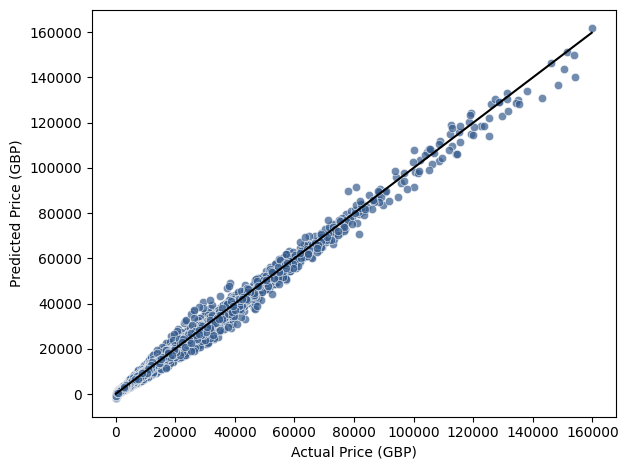

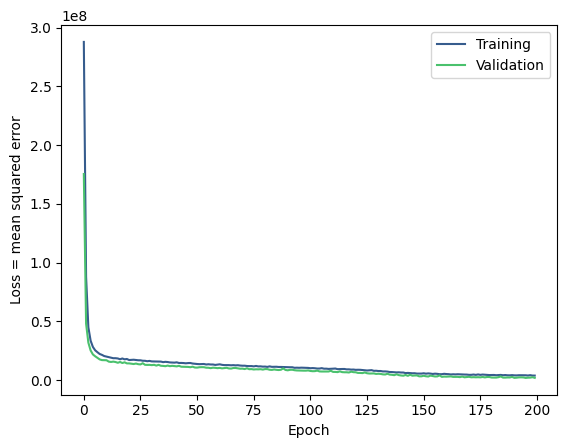

In [42]:
#Predict the model outputs for the testing set
y_pred_l1_4 = ann_l1_4.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_l1_4 = plot_and_score(y_test, y_pred_l1_4)

#Plot training and validation loss against epoch
ann_loss_l1_4 = plot_training_history(pd.DataFrame(history_l1_4.history))

#Save figure as png
ann_predicted_actual_l1_4.savefig('ann_predicted_actual_l1_4.png')
ann_loss_l1_4.savefig('ann_loss_l1_4.png')

Poorer fit for leaky relu

In [43]:
#Using L1 regularisation with dropout 0.1, with regularisation_rate of 0.01, activation function for hidden layers elu
ann_l1_5, history_l1_5 = build_and_train_ann_3_hiddenlayer(x_train, y_train, dropout_rate=0.1, regularization='l1', regularization_rate=0.01, activation='elu')

Epoch 1/200
1125/1125 [==============================] - 2s 1ms/step - loss: 293222976.0000 - mean_squared_error: 293222976.0000 - val_loss: 205869152.0000 - val_mean_squared_error: 205869136.0000
Epoch 2/200
1125/1125 [==============================] - 2s 1ms/step - loss: 93669280.0000 - mean_squared_error: 93669232.0000 - val_loss: 43428420.0000 - val_mean_squared_error: 43428380.0000
Epoch 3/200
1125/1125 [==============================] - 2s 1ms/step - loss: 40937052.0000 - mean_squared_error: 40937012.0000 - val_loss: 27133844.0000 - val_mean_squared_error: 27133790.0000
Epoch 4/200
1125/1125 [==============================] - 2s 1ms/step - loss: 32037284.0000 - mean_squared_error: 32037230.0000 - val_loss: 22836466.0000 - val_mean_squared_error: 22836418.0000
Epoch 5/200
1125/1125 [==============================] - 2s 1ms/step - loss: 28764540.0000 - mean_squared_error: 28764482.0000 - val_loss: 20873294.0000 - val_mean_squared_error: 20873230.0000
Epoch 6/200
1125/1125 [========

1125/1125 [==============================] - 2s 2ms/step - loss: 5877498.0000 - mean_squared_error: 5877419.5000 - val_loss: 3371581.7500 - val_mean_squared_error: 3371503.7500
Epoch 87/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5504554.0000 - mean_squared_error: 5504469.5000 - val_loss: 3156876.7500 - val_mean_squared_error: 3156796.5000
Epoch 88/200
1125/1125 [==============================] - 2s 2ms/step - loss: 5574684.0000 - mean_squared_error: 5574606.5000 - val_loss: 3078035.5000 - val_mean_squared_error: 3077953.5000
Epoch 89/200
1125/1125 [==============================] - 2s 2ms/step - loss: 5619394.5000 - mean_squared_error: 5619317.5000 - val_loss: 3266300.5000 - val_mean_squared_error: 3266221.5000
Epoch 90/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5724857.0000 - mean_squared_error: 5724775.5000 - val_loss: 3115015.7500 - val_mean_squared_error: 3114937.0000
Epoch 91/200
1125/1125 [==============================] - 2s 1m

1125/1125 [==============================] - 2s 2ms/step - loss: 3984815.5000 - mean_squared_error: 3984731.2500 - val_loss: 2170143.2500 - val_mean_squared_error: 2170060.5000
Epoch 130/200
1125/1125 [==============================] - 2s 2ms/step - loss: 4025491.5000 - mean_squared_error: 4025408.2500 - val_loss: 2361785.2500 - val_mean_squared_error: 2361703.2500
Epoch 131/200
1125/1125 [==============================] - 2s 2ms/step - loss: 4087557.2500 - mean_squared_error: 4087475.7500 - val_loss: 2283065.5000 - val_mean_squared_error: 2282984.0000
Epoch 132/200
1125/1125 [==============================] - 3s 2ms/step - loss: 3940475.7500 - mean_squared_error: 3940390.7500 - val_loss: 2127487.7500 - val_mean_squared_error: 2127404.7500
Epoch 133/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3965500.0000 - mean_squared_error: 3965416.7500 - val_loss: 2120795.7500 - val_mean_squared_error: 2120713.0000
Epoch 134/200
1125/1125 [==============================] - 

Epoch 172/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3127453.5000 - mean_squared_error: 3127369.7500 - val_loss: 1513245.2500 - val_mean_squared_error: 1513159.8750
Epoch 173/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3212575.2500 - mean_squared_error: 3212488.0000 - val_loss: 1569675.1250 - val_mean_squared_error: 1569589.3750
Epoch 174/200
1125/1125 [==============================] - 2s 2ms/step - loss: 2977593.7500 - mean_squared_error: 2977509.0000 - val_loss: 1736373.0000 - val_mean_squared_error: 1736287.7500
Epoch 175/200
1125/1125 [==============================] - 2s 2ms/step - loss: 2982246.5000 - mean_squared_error: 2982163.0000 - val_loss: 1637012.2500 - val_mean_squared_error: 1636927.5000
Epoch 176/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3030862.7500 - mean_squared_error: 3030778.2500 - val_loss: 1535759.8750 - val_mean_squared_error: 1535675.3750
Epoch 177/200
1125/1125 [====================

313/313 [==============================] - 0s 1ms/step
R2 Score: 0.994


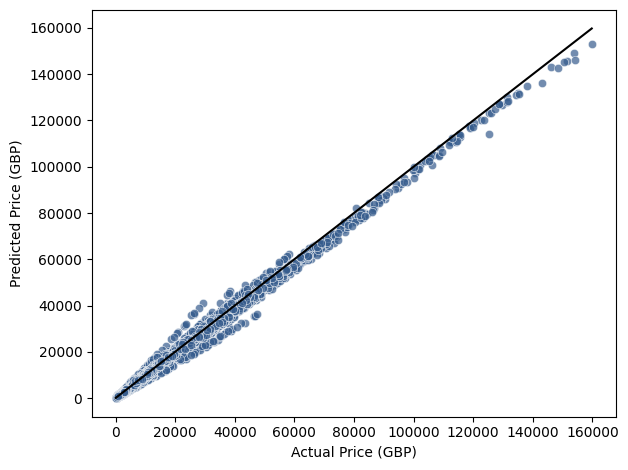

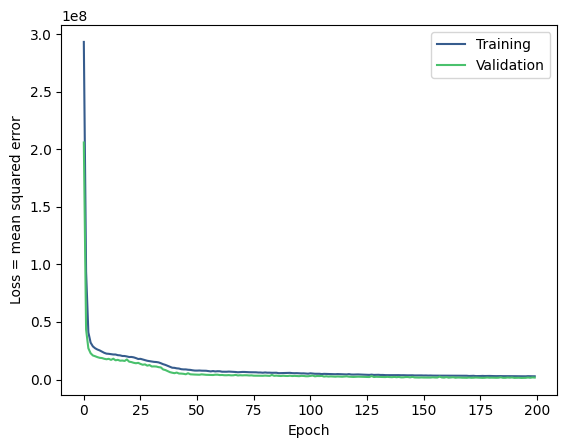

In [44]:
#Predict the model outputs for the testing set
y_pred_l1_5 = ann_l1_5.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_l1_5 = plot_and_score(y_test, y_pred_l1_5)

#Plot training and validation loss against epoch
ann_loss_l1_5 = plot_training_history(pd.DataFrame(history_l1_5.history))

#Save figure as png
ann_predicted_actual_l1_5.savefig('ann_predicted_actual_l1_5.png')
ann_loss_l1_5.savefig('ann_loss_l1_5.png')

For elu, the fit is good R2 0.994, however there is no early stopping and the model appears to still bias for higher prices adn udner-predict them.

In [45]:
#Using L1 regularisation with dropout 0.1, with regularisation_rate of 0.01, activation function for hidden layers selu
ann_l1_6, history_l1_6 = build_and_train_ann_3_hiddenlayer(x_train, y_train, dropout_rate=0.1, regularization='l1', regularization_rate=0.01, activation='selu')

Epoch 1/200
1125/1125 [==============================] - 3s 2ms/step - loss: 282110528.0000 - mean_squared_error: 282110464.0000 - val_loss: 153559808.0000 - val_mean_squared_error: 153559744.0000
Epoch 2/200
1125/1125 [==============================] - 2s 2ms/step - loss: 70361960.0000 - mean_squared_error: 70361912.0000 - val_loss: 32769456.0000 - val_mean_squared_error: 32769406.0000
Epoch 3/200
1125/1125 [==============================] - 2s 2ms/step - loss: 35835496.0000 - mean_squared_error: 35835452.0000 - val_loss: 23998690.0000 - val_mean_squared_error: 23998630.0000
Epoch 4/200
1125/1125 [==============================] - 2s 2ms/step - loss: 30547472.0000 - mean_squared_error: 30547426.0000 - val_loss: 23733694.0000 - val_mean_squared_error: 23733642.0000
Epoch 5/200
1125/1125 [==============================] - 2s 2ms/step - loss: 28131358.0000 - mean_squared_error: 28131304.0000 - val_loss: 21042940.0000 - val_mean_squared_error: 21042880.0000
Epoch 6/200
1125/1125 [========

Epoch 86/200
1125/1125 [==============================] - 2s 2ms/step - loss: 9681859.0000 - mean_squared_error: 9681790.0000 - val_loss: 6238889.0000 - val_mean_squared_error: 6238816.5000
Epoch 87/200
1125/1125 [==============================] - 2s 2ms/step - loss: 9411064.0000 - mean_squared_error: 9410993.0000 - val_loss: 5784177.0000 - val_mean_squared_error: 5784106.5000
Epoch 88/200
1125/1125 [==============================] - 2s 2ms/step - loss: 9841314.0000 - mean_squared_error: 9841244.0000 - val_loss: 5756120.0000 - val_mean_squared_error: 5756049.0000
Epoch 89/200
1125/1125 [==============================] - 2s 2ms/step - loss: 9860050.0000 - mean_squared_error: 9859976.0000 - val_loss: 5538753.5000 - val_mean_squared_error: 5538682.5000
Epoch 90/200
1125/1125 [==============================] - 2s 2ms/step - loss: 9377046.0000 - mean_squared_error: 9376968.0000 - val_loss: 5513010.0000 - val_mean_squared_error: 5512939.0000
Epoch 91/200
1125/1125 [==========================

Epoch 129/200
1125/1125 [==============================] - 2s 2ms/step - loss: 8320254.0000 - mean_squared_error: 8320178.5000 - val_loss: 5117608.0000 - val_mean_squared_error: 5117532.0000
Epoch 130/200
1125/1125 [==============================] - 2s 2ms/step - loss: 8375931.5000 - mean_squared_error: 8375865.0000 - val_loss: 5053488.0000 - val_mean_squared_error: 5053415.0000
Epoch 131/200
1125/1125 [==============================] - 2s 2ms/step - loss: 8274936.5000 - mean_squared_error: 8274862.0000 - val_loss: 5145291.0000 - val_mean_squared_error: 5145218.5000
Epoch 132/200
1125/1125 [==============================] - 2s 1ms/step - loss: 8053648.0000 - mean_squared_error: 8053578.0000 - val_loss: 5711790.5000 - val_mean_squared_error: 5711719.0000
Epoch 133/200
1125/1125 [==============================] - 2s 2ms/step - loss: 8427068.0000 - mean_squared_error: 8426993.0000 - val_loss: 5328264.0000 - val_mean_squared_error: 5328193.0000
Epoch 134/200
1125/1125 [====================

Epoch 172/200
1125/1125 [==============================] - 2s 2ms/step - loss: 7080067.5000 - mean_squared_error: 7079991.0000 - val_loss: 4636080.5000 - val_mean_squared_error: 4636005.0000
Epoch 173/200
1125/1125 [==============================] - 2s 2ms/step - loss: 7081463.5000 - mean_squared_error: 7081392.0000 - val_loss: 4534555.5000 - val_mean_squared_error: 4534480.5000
Epoch 174/200
1125/1125 [==============================] - 2s 2ms/step - loss: 7096894.5000 - mean_squared_error: 7096822.0000 - val_loss: 4781008.0000 - val_mean_squared_error: 4780932.0000
Epoch 175/200
1125/1125 [==============================] - 2s 2ms/step - loss: 6969834.5000 - mean_squared_error: 6969758.0000 - val_loss: 4433941.0000 - val_mean_squared_error: 4433864.5000
Epoch 176/200
1125/1125 [==============================] - 2s 2ms/step - loss: 7230940.0000 - mean_squared_error: 7230866.0000 - val_loss: 4624115.5000 - val_mean_squared_error: 4624041.0000
Epoch 177/200
1125/1125 [====================

313/313 [==============================] - 0s 1ms/step
R2 Score: 0.987


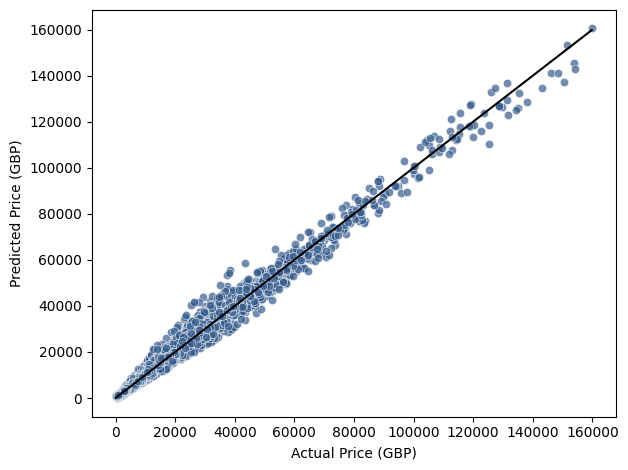

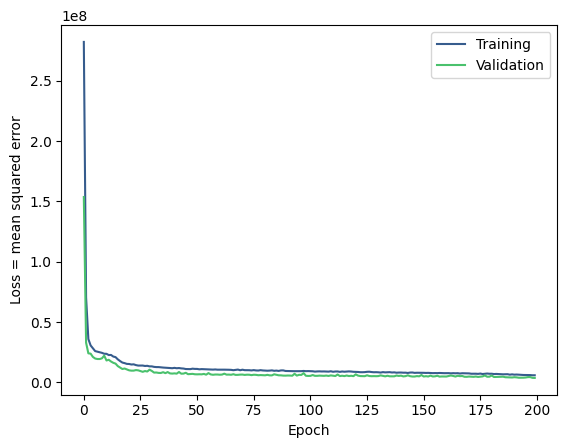

In [46]:
#Predict the model outputs for the testing set
y_pred_l1_6 = ann_l1_6.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_l1_6 = plot_and_score(y_test, y_pred_l1_6)

#Plot training and validation loss against epoch
ann_loss_l1_6 = plot_training_history(pd.DataFrame(history_l1_6.history))

#Save figure as png
ann_predicted_actual_l1_6.savefig('ann_predicted_actual_l1_6.png')
ann_loss_l1_6.savefig('ann_loss_l1_6.png')

In [48]:
#Using L1 regularisation with dropout 0.1, with regularisation_rate of 0.005, activation function for hidden layers elu
ann_l1_7, history_l1_7 = build_and_train_ann_3_hiddenlayer(x_train, y_train, dropout_rate=0.1, regularization='l1', regularization_rate=0.005, activation='elu')

Epoch 1/200
1125/1125 [==============================] - 3s 2ms/step - loss: 292507360.0000 - mean_squared_error: 292507360.0000 - val_loss: 207070304.0000 - val_mean_squared_error: 207070272.0000
Epoch 2/200
1125/1125 [==============================] - 2s 2ms/step - loss: 94796016.0000 - mean_squared_error: 94796000.0000 - val_loss: 41358568.0000 - val_mean_squared_error: 41358544.0000
Epoch 3/200
1125/1125 [==============================] - 2s 2ms/step - loss: 40121480.0000 - mean_squared_error: 40121436.0000 - val_loss: 27142120.0000 - val_mean_squared_error: 27142096.0000
Epoch 4/200
1125/1125 [==============================] - 2s 2ms/step - loss: 32539242.0000 - mean_squared_error: 32539228.0000 - val_loss: 22571470.0000 - val_mean_squared_error: 22571442.0000
Epoch 5/200
1125/1125 [==============================] - 2s 2ms/step - loss: 28909106.0000 - mean_squared_error: 28909074.0000 - val_loss: 21102060.0000 - val_mean_squared_error: 21102042.0000
Epoch 6/200
1125/1125 [========

Epoch 86/200
1125/1125 [==============================] - 2s 2ms/step - loss: 8989841.0000 - mean_squared_error: 8989813.0000 - val_loss: 7104827.5000 - val_mean_squared_error: 7104785.5000
Epoch 87/200
1125/1125 [==============================] - 3s 2ms/step - loss: 9277658.0000 - mean_squared_error: 9277618.0000 - val_loss: 5811976.0000 - val_mean_squared_error: 5811939.5000
Epoch 88/200
1125/1125 [==============================] - 2s 2ms/step - loss: 8871184.0000 - mean_squared_error: 8871149.0000 - val_loss: 5940782.0000 - val_mean_squared_error: 5940746.0000
Epoch 89/200
1125/1125 [==============================] - 2s 2ms/step - loss: 9081602.0000 - mean_squared_error: 9081562.0000 - val_loss: 6129547.0000 - val_mean_squared_error: 6129506.5000
Epoch 90/200
1125/1125 [==============================] - 2s 2ms/step - loss: 9100759.0000 - mean_squared_error: 9100718.0000 - val_loss: 5970461.5000 - val_mean_squared_error: 5970423.5000
Epoch 91/200
1125/1125 [==========================

Epoch 129/200
1125/1125 [==============================] - 2s 2ms/step - loss: 7530534.0000 - mean_squared_error: 7530499.5000 - val_loss: 4753485.5000 - val_mean_squared_error: 4753444.0000
Epoch 130/200
1125/1125 [==============================] - 2s 1ms/step - loss: 7424297.0000 - mean_squared_error: 7424264.0000 - val_loss: 4955959.0000 - val_mean_squared_error: 4955920.0000
Epoch 131/200
1125/1125 [==============================] - 2s 2ms/step - loss: 7553689.0000 - mean_squared_error: 7553643.5000 - val_loss: 4912509.0000 - val_mean_squared_error: 4912474.0000
Epoch 132/200
1125/1125 [==============================] - 2s 2ms/step - loss: 7367505.0000 - mean_squared_error: 7367464.5000 - val_loss: 4645105.0000 - val_mean_squared_error: 4645064.5000
Epoch 133/200
1125/1125 [==============================] - 3s 3ms/step - loss: 7367930.5000 - mean_squared_error: 7367892.5000 - val_loss: 4590897.5000 - val_mean_squared_error: 4590859.5000
Epoch 134/200
1125/1125 [====================

Epoch 172/200
1125/1125 [==============================] - 2s 2ms/step - loss: 5227948.5000 - mean_squared_error: 5227912.5000 - val_loss: 3193746.7500 - val_mean_squared_error: 3193706.2500
Epoch 173/200
1125/1125 [==============================] - 2s 2ms/step - loss: 5122186.0000 - mean_squared_error: 5122147.0000 - val_loss: 3229722.2500 - val_mean_squared_error: 3229681.2500
Epoch 174/200
1125/1125 [==============================] - 2s 2ms/step - loss: 5096027.0000 - mean_squared_error: 5095989.0000 - val_loss: 3700609.7500 - val_mean_squared_error: 3700567.0000
Epoch 175/200
1125/1125 [==============================] - 2s 2ms/step - loss: 5174263.0000 - mean_squared_error: 5174224.0000 - val_loss: 3055144.5000 - val_mean_squared_error: 3055103.2500
Epoch 176/200
1125/1125 [==============================] - 2s 2ms/step - loss: 5147873.5000 - mean_squared_error: 5147839.0000 - val_loss: 3124474.0000 - val_mean_squared_error: 3124431.2500
Epoch 177/200
1125/1125 [====================

313/313 [==============================] - 0s 1ms/step
R2 Score: 0.991


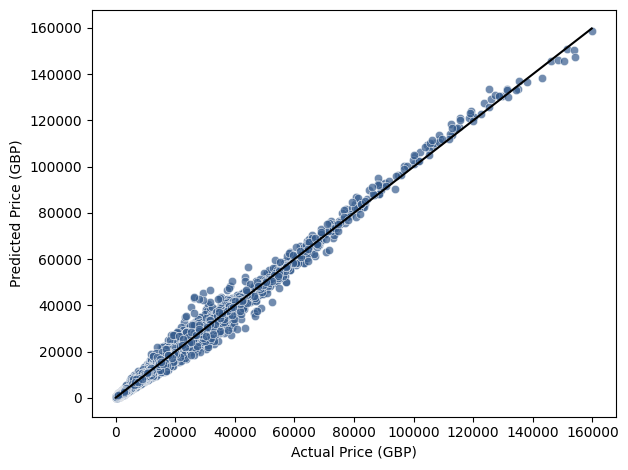

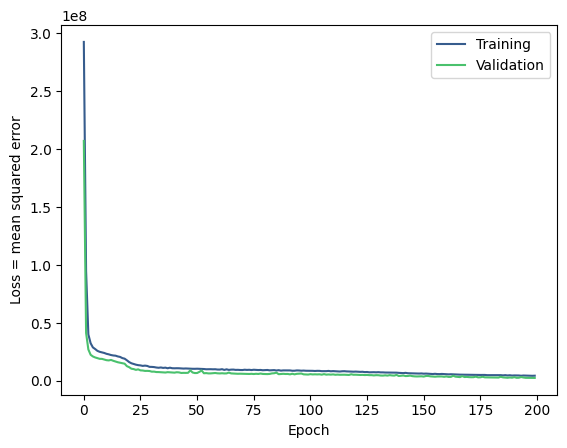

In [49]:
#Predict the model outputs for the testing set
y_pred_l1_7 = ann_l1_7.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_l1_7 = plot_and_score(y_test, y_pred_l1_7)

#Plot training and validation loss against epoch
ann_loss_l1_7 = plot_training_history(pd.DataFrame(history_l1_7.history))

#Save figure as png
ann_predicted_actual_l1_7.savefig('ann_predicted_actual_l1_7.png')
ann_loss_l1_7.savefig('ann_loss_l1_7.png')

*Reducing patience*

In [57]:
#Using L1 regularisation with dropout rate 0.1, regularisation rate 0.01, relu, reducing patience to 15 to induce early stopping
ann_l1_8, history_l1_8 = build_and_train_ann_3_hiddenlayer(x_train, y_train, patience=15, dropout_rate=0.1, regularization='l1', regularization_rate=0.01)

Epoch 1/200
1125/1125 [==============================] - 3s 2ms/step - loss: 249276576.0000 - mean_squared_error: 249276544.0000 - val_loss: 86615120.0000 - val_mean_squared_error: 86615088.0000
Epoch 2/200
1125/1125 [==============================] - 2s 2ms/step - loss: 61772952.0000 - mean_squared_error: 61772924.0000 - val_loss: 38484472.0000 - val_mean_squared_error: 38484440.0000
Epoch 3/200
1125/1125 [==============================] - 2s 2ms/step - loss: 35763912.0000 - mean_squared_error: 35763860.0000 - val_loss: 26266618.0000 - val_mean_squared_error: 26266576.0000
Epoch 4/200
1125/1125 [==============================] - 2s 1ms/step - loss: 27265612.0000 - mean_squared_error: 27265576.0000 - val_loss: 21507676.0000 - val_mean_squared_error: 21507642.0000
Epoch 5/200
1125/1125 [==============================] - 2s 2ms/step - loss: 23987382.0000 - mean_squared_error: 23987348.0000 - val_loss: 19300496.0000 - val_mean_squared_error: 19300450.0000
Epoch 6/200
1125/1125 [==========

1125/1125 [==============================] - 2s 2ms/step - loss: 5905008.0000 - mean_squared_error: 5904933.5000 - val_loss: 3026248.7500 - val_mean_squared_error: 3026172.2500
Epoch 87/200
1125/1125 [==============================] - 2s 2ms/step - loss: 5789667.0000 - mean_squared_error: 5789587.0000 - val_loss: 2965197.5000 - val_mean_squared_error: 2965123.2500
Epoch 88/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5672391.5000 - mean_squared_error: 5672322.0000 - val_loss: 2941565.2500 - val_mean_squared_error: 2941490.0000
Epoch 89/200
1125/1125 [==============================] - 2s 2ms/step - loss: 5629876.0000 - mean_squared_error: 5629805.0000 - val_loss: 3135459.7500 - val_mean_squared_error: 3135383.7500
Epoch 90/200
1125/1125 [==============================] - 2s 1ms/step - loss: 5374384.5000 - mean_squared_error: 5374307.0000 - val_loss: 2938095.0000 - val_mean_squared_error: 2938020.7500
Epoch 91/200
1125/1125 [==============================] - 2s 1m

1125/1125 [==============================] - 2s 1ms/step - loss: 4574225.5000 - mean_squared_error: 4574148.0000 - val_loss: 2421117.2500 - val_mean_squared_error: 2421038.0000
Epoch 130/200
1125/1125 [==============================] - 2s 2ms/step - loss: 4514074.5000 - mean_squared_error: 4513992.0000 - val_loss: 2499489.7500 - val_mean_squared_error: 2499410.2500
Epoch 131/200
1125/1125 [==============================] - 2s 2ms/step - loss: 4682596.0000 - mean_squared_error: 4682514.0000 - val_loss: 2256356.7500 - val_mean_squared_error: 2256277.0000
Epoch 132/200
1125/1125 [==============================] - 2s 2ms/step - loss: 4554472.5000 - mean_squared_error: 4554389.5000 - val_loss: 2283681.2500 - val_mean_squared_error: 2283602.5000
Epoch 133/200
1125/1125 [==============================] - 2s 2ms/step - loss: 4467567.0000 - mean_squared_error: 4467491.0000 - val_loss: 2418113.5000 - val_mean_squared_error: 2418034.2500
Epoch 134/200
1125/1125 [==============================] - 

Epoch 172/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3700820.7500 - mean_squared_error: 3700736.0000 - val_loss: 1970232.1250 - val_mean_squared_error: 1970149.0000
Epoch 173/200
1125/1125 [==============================] - 2s 1ms/step - loss: 3858388.7500 - mean_squared_error: 3858304.0000 - val_loss: 2658524.7500 - val_mean_squared_error: 2658442.2500
Epoch 174/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3794511.5000 - mean_squared_error: 3794423.2500 - val_loss: 2197405.5000 - val_mean_squared_error: 2197322.0000
Epoch 175/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3782729.7500 - mean_squared_error: 3782647.5000 - val_loss: 2467562.7500 - val_mean_squared_error: 2467479.2500
Epoch 176/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3861274.5000 - mean_squared_error: 3861191.7500 - val_loss: 2168227.0000 - val_mean_squared_error: 2168143.0000
Epoch 177/200
1125/1125 [====================

313/313 [==============================] - 0s 1ms/step
R2 Score: 0.993


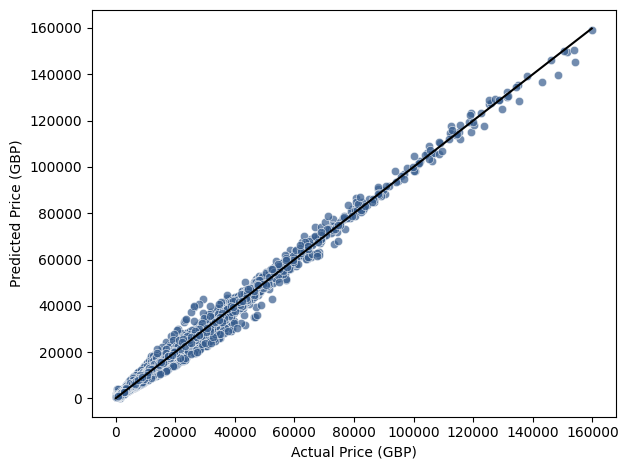

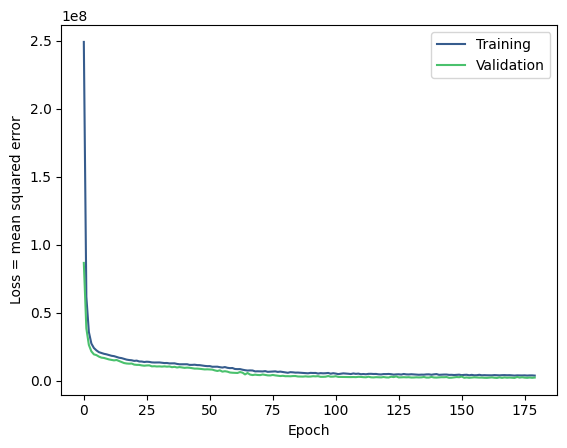

In [58]:
#Predict the model outputs for the testing set
y_pred_l1_8 = ann_l1_8.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_l1_8 = plot_and_score(y_test, y_pred_l1_8)

#Plot training and validation loss against epoch
ann_loss_l1_8 = plot_training_history(pd.DataFrame(history_l1_8.history))

#Save figure as png
ann_predicted_actual_l1_8.savefig('ann_predicted_actual_l1_8.png')
ann_loss_l1_8.savefig('ann_loss_l1_8.png')

In [67]:
#Using L2 regularisation with dropout 0.1, with regularisation_rate of 0.01, patience 15
ann_l2_2, history_l2_2 = build_and_train_ann_3_hiddenlayer(x_train, y_train, patience=15, dropout_rate=0.1, regularization='l2', regularization_rate=0.01)

Epoch 1/200
1125/1125 [==============================] - 3s 2ms/step - loss: 248152272.0000 - mean_squared_error: 248152272.0000 - val_loss: 85713248.0000 - val_mean_squared_error: 85713232.0000
Epoch 2/200
1125/1125 [==============================] - 2s 2ms/step - loss: 58974368.0000 - mean_squared_error: 58974324.0000 - val_loss: 36305908.0000 - val_mean_squared_error: 36305880.0000
Epoch 3/200
1125/1125 [==============================] - 2s 2ms/step - loss: 33037258.0000 - mean_squared_error: 33037218.0000 - val_loss: 24179426.0000 - val_mean_squared_error: 24179380.0000
Epoch 4/200
1125/1125 [==============================] - 2s 2ms/step - loss: 25812846.0000 - mean_squared_error: 25812792.0000 - val_loss: 20706902.0000 - val_mean_squared_error: 20706862.0000
Epoch 5/200
1125/1125 [==============================] - 2s 2ms/step - loss: 23392934.0000 - mean_squared_error: 23392894.0000 - val_loss: 19327272.0000 - val_mean_squared_error: 19327230.0000
Epoch 6/200
1125/1125 [==========

Epoch 44/200
1125/1125 [==============================] - 2s 2ms/step - loss: 7420777.0000 - mean_squared_error: 7420631.0000 - val_loss: 3716422.5000 - val_mean_squared_error: 3716274.7500
Epoch 45/200
1125/1125 [==============================] - 2s 2ms/step - loss: 7827326.5000 - mean_squared_error: 7827174.0000 - val_loss: 3725080.0000 - val_mean_squared_error: 3724934.2500
Epoch 46/200
1125/1125 [==============================] - 2s 2ms/step - loss: 7838627.0000 - mean_squared_error: 7838484.5000 - val_loss: 4599999.0000 - val_mean_squared_error: 4599850.0000
Epoch 47/200
1125/1125 [==============================] - 2s 2ms/step - loss: 7544127.0000 - mean_squared_error: 7543970.5000 - val_loss: 3925844.5000 - val_mean_squared_error: 3925695.7500
Epoch 48/200
1125/1125 [==============================] - 2s 2ms/step - loss: 6870916.5000 - mean_squared_error: 6870769.0000 - val_loss: 3657106.0000 - val_mean_squared_error: 3656956.2500
Epoch 49/200
1125/1125 [==========================

1125/1125 [==============================] - 2s 2ms/step - loss: 3835705.5000 - mean_squared_error: 3835516.2500 - val_loss: 1911994.2500 - val_mean_squared_error: 1911802.2500
Epoch 131/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3807999.7500 - mean_squared_error: 3807810.0000 - val_loss: 1853061.8750 - val_mean_squared_error: 1852869.8750
Epoch 132/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3947955.0000 - mean_squared_error: 3947765.2500 - val_loss: 2046403.5000 - val_mean_squared_error: 2046210.0000
Epoch 133/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3737950.0000 - mean_squared_error: 3737756.0000 - val_loss: 1732259.2500 - val_mean_squared_error: 1732065.6250
Epoch 134/200
1125/1125 [==============================] - 2s 2ms/step - loss: 3633993.2500 - mean_squared_error: 3633800.5000 - val_loss: 1611876.5000 - val_mean_squared_error: 1611682.0000
Epoch 135/200
1125/1125 [==============================] - 

313/313 [==============================] - 0s 1ms/step
R2 Score: 0.995


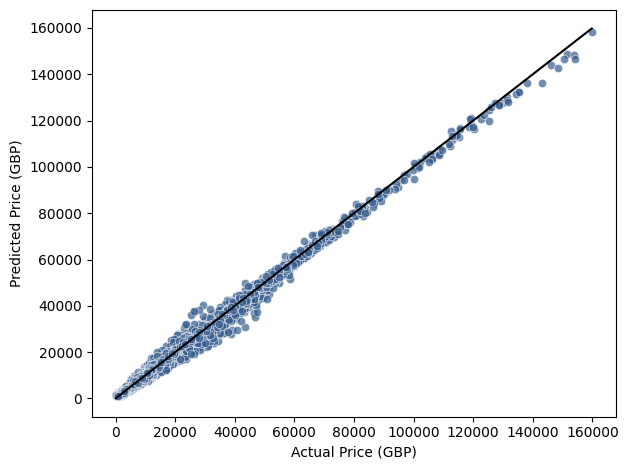

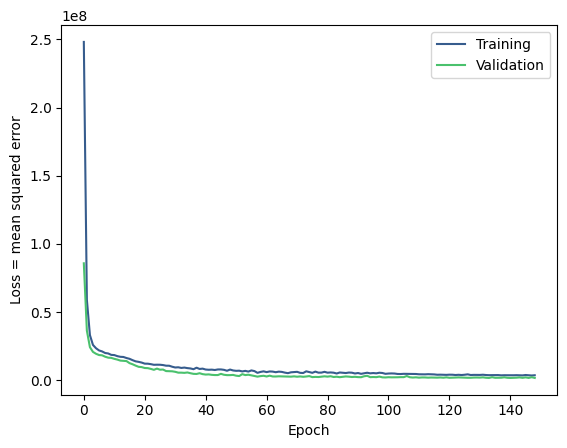

In [68]:
#Predict the model outputs for the testing set
y_pred_l2_2 = ann_l2_2.predict(x_test)

#Plot actual vs predicted and R2
ann_predicted_actual_l2_2 = plot_and_score(y_test, y_pred_l2_2)

#Plot training and validation loss against epoch
ann_loss_l2_2 = plot_training_history(pd.DataFrame(history_l2_2.history))

#Save figure as png
ann_predicted_actual_l2_2.savefig('ann_predicted_actual_l2_2.png')
ann_loss_l2_2.savefig('ann_loss_l2_2.png')

The ANN model with 3 hidden layers, L2 regularisation, with regularisation rate of 0.01, dropout of 0.1, pateince of 15 and relu activation on hidden layers, is the preferred model, reducing bias at higher prices of car, and early stopping ensuring minimum loss is achieved, preventing overfitting. In terms of computation time this model is also preferred.

The ANN models struggled to predict the higher prices, perhaps due to fewer data points for higher prices in the training set making prediction at higher prices less accurate.

*Keras tuner*

An alternative to optimising manually, could use keras tuner but tuning lots of hyperparameters using this method can be computationally intensive.

TensorFlow (n. d.) Introduction to the Keras Tuner. Available online: https://www.tensorflow.org/tutorials/keras/keras_tuner [Accessed 11/12/2023].

**Conclusions on best model for prediction of car price on both numerical and categorical features**

The best model for predicting the price of a car in the dataset is random forest regression (R2 0.998) using all the features (numerical and categorical). The ANN model is also very good at car price prediction using all the features coming a close second (R2 0.995). This ANN model has 3 hidden layers (relu activation), L2 regularisation with regularisation rate of 0.01, and dropout of 0.1, with early stopping.

**Unsupervised Clustering**

Use the k-Means clustering algorithm to identify clusters in the car sales data. 

Consider different combinations of the numerical variables in the dataset to use as input features for the clustering algorithm. 

In each case, determine the optimal number of clusters (k) to use, explain reason.

Determine the best combination of variables producing the best clustering results.

Use appropriate evaluation metrics to support conclusions.

Reference:

Scikit learn (n. d.) Clustering. Available online: https://scikit-learn.org/stable/modules/clustering.html [Accessed 11/12/2023].

**KMeans Clustering**

Reference:

Scikit learn (n. d.) sklearn.cluster.KMeans. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html [Accessed 13/12/2023].

Objectives of Kmeans clustering-

1. Compare all numerical variables together 

4. Determine optimal number of clusters using elbow method (inertia) 

5. Evaluation metrics -Silhouette, Davies Bouldin scores (internal valuation metrics and no ground truth).

The Davies-Bouldin index (DBI) is a metric for assessing the separation and compactness of clusters. It is based on the idea that good clusters are those that have low within-cluster variation and high between-cluster separation.

Reference:

Scikit learn (n. d.) sklearn.metrics.davies_bouldin_score. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html [Accessed 13/12/2023].

Silhouette Score is a metric to evaluate the performance of clustering algorithm. It uses compactness of individual clusters(intra cluster distance) and separation amongst clusters (inter cluster distance) to measure an overall representative score of how well the clustering algorithm has performed.

Reference: 

Scikit learn (n. d.) sklearn.metrics.silhouette_score. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html [Accessed 13/12/2023].

A lower Davies-Bouldin score and a higher Silhouette score generally indicate better clustering.

Reference for evaluation metrics:

Hyperskill (n. d.) Introduction to clustering evaluation. Available online: https://hyperskill.org/learn/step/28809 [Accessed 13/12/2023].

In [41]:
#Combinations of 2 numerical features
feature_names_3 = ["Year of manufacture", "Engine size (litres)"]
feature_names_4 = ["Year of manufacture", "Mileage"]
feature_names_5 = ["Year of manufacture", "Price (GBP)"]
feature_names_6 = ["Engine size (litres)", "Mileage"]
feature_names_7 = ["Engine size (litres)", "Price (GBP)"]
feature_names_8 = ["Mileage", "Price (GBP)"]

Optimal number of clusters: 3
Silhouette Score: 0.4597
Davies-Bouldin Score: 0.7525


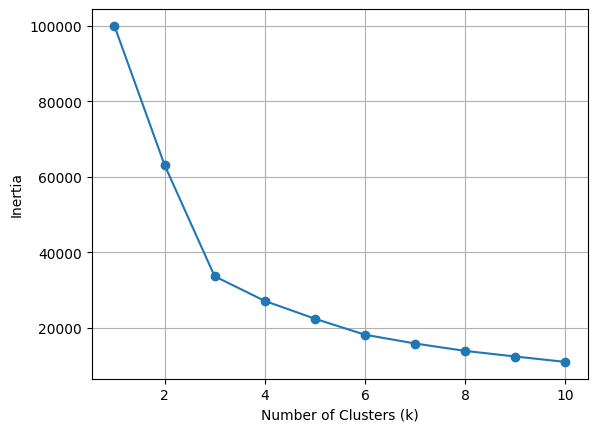

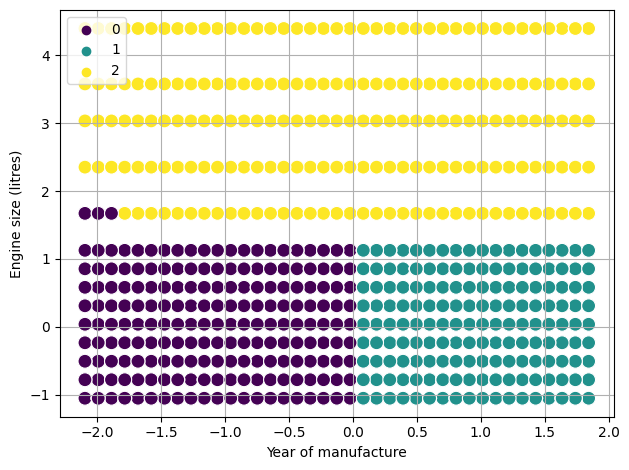

In [47]:
#Import the k-Means model
#from sklearn.cluster import KMeans
#Function for KNN on 2 features to pass in df and the feature names to cluster by
def execute_kmeans_clustering(data, feature_names):
    """
    Perform K-means clustering on two features and return plots for inertia and cluster visualization.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing the data.
    feature_names (list): A list of two feature names to perform clustering.

    Returns:
    fig1, ax1, fig2, ax2: Matplotlib figures and axes for inertia and cluster visualization plots.
    """
    #Scale the data
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data[feature_names])

    #Create a list to store the inertia values
    inertia_values = []

    #Range of k values (from 1 to 10)
    k_values = range(1, 11)

    #Iterate over each k value and determine inertia
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(x_scaled)
        inertia = kmeans.inertia_
        inertia_values.append(inertia)

    #Plot inertia versus k
    fig1, ax1 = plt.subplots()
    ax1.plot(k_values, inertia_values, marker='o')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.grid(True)

    # Auto-detect the elbow point for the optimal number of clusters
    optimal_k = calc_optimal_k(inertia_values)
    print(f"Optimal number of clusters: {optimal_k}")

    #Create the final K-Means model with the optimal number of clusters
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    final_kmeans.fit(x_scaled)

    #Predict cluster labels
    cluster_labels_pred = final_kmeans.predict(x_scaled)

    #Calculate Davies-Bouldin score and silhouette score
    s_score = silhouette_score(x_scaled, cluster_labels_pred)
    db_score = davies_bouldin_score(x_scaled, cluster_labels_pred)
    print(f"Silhouette Score: {s_score:.4f}")
    print(f"Davies-Bouldin Score: {db_score:.4f}")

    #Create a scatter plot to visualize clusters
    data_with_clusters = pd.DataFrame(data=x_scaled, columns=feature_names)
    data_with_clusters['Cluster'] = cluster_labels_pred
    fig2, ax2 = plt.subplots()
    sns.scatterplot(data=data_with_clusters, x=feature_names[0], y=feature_names[1], hue=cluster_labels_pred, palette='viridis', s=100, ax=ax2)
    ax2.grid(True)

    plt.tight_layout()

    #Return the figures
    return fig1, ax1, fig2, ax2

#Define function to calculate optimal k value based on inertia values list
#Calculates the difference between consecutive inertia values, computes the relative differences, and identifies the elbow point
def calc_optimal_k(inertia_values):
    """
    Calculate the optimal number of clusters based on the inertia values.

    Parameters:
    inertia_values (list): List of inertia values for different cluster numbers.

    Returns:
    int: The optimal number of clusters.
    """
    #Automatic detection of the optimal k using the elbow method
    diff = np.diff(inertia_values)
    diff_r = diff[1:] / diff[:-1]
    #Add 2 to account for 0-based indexing
    optimal_k = np.argmin(diff_r) + 2  
    return optimal_k

#Apply function to df for year of manufacture and engine size features
kmeans_year_engine = execute_kmeans_clustering(df, feature_names_3)

#Extract the figures and axes from the tuple
fig1, ax1, fig2, ax2 = kmeans_year_engine

#Save the figures to PNG files
fig1.savefig('kmeans_year_engine_1.png')
fig2.savefig('kmeans_year_engine_2.png')

Optimal number of clusters: 2
Silhouette Score: 0.5334
Davies-Bouldin Score: 0.6585


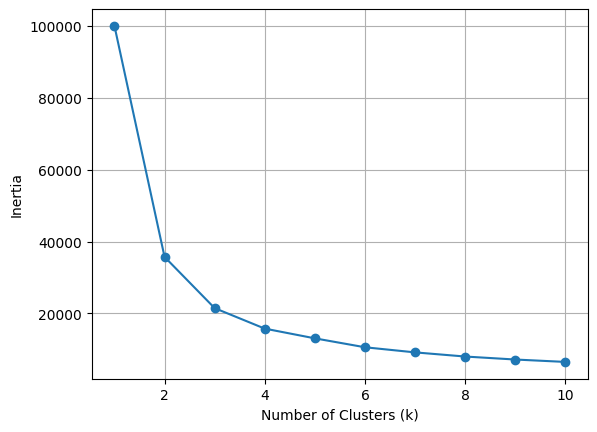

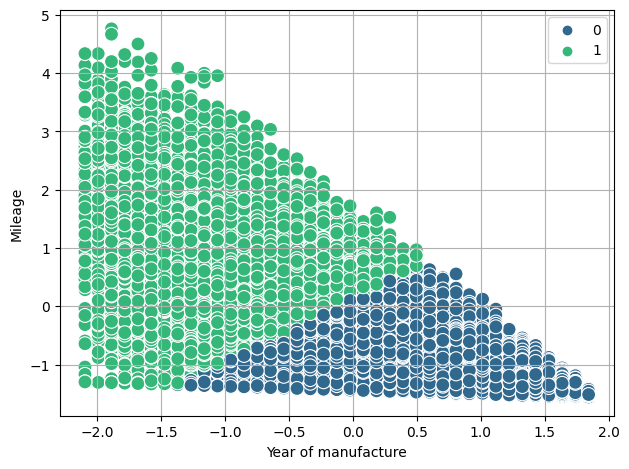

In [48]:
#Apply function to df for year of manufacture and mileage features
kmeans_year_mileage = execute_kmeans_clustering(df, feature_names_4)
#Extract the figures and axes from the tuple
fig1, ax1, fig2, ax2 = kmeans_year_mileage

#Save the figures to PNG files
fig1.savefig('kmeans_year_mileage_1.png')
fig2.savefig('kmeans_year_mileage_2.png')

Optimal number of clusters: 2
Silhouette Score: 0.5480
Davies-Bouldin Score: 0.6780


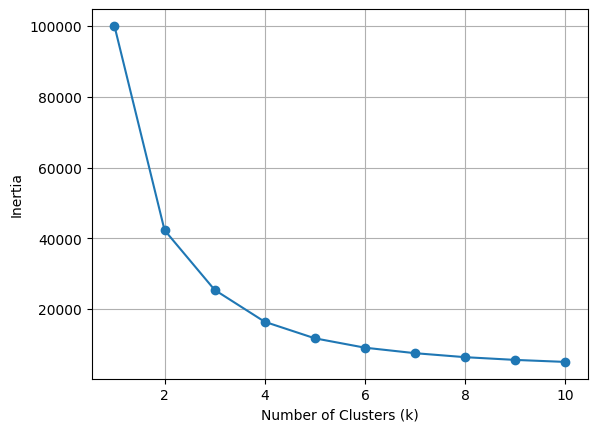

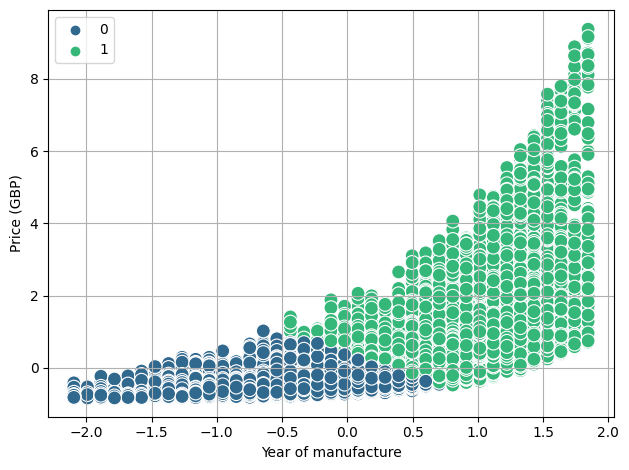

In [49]:
#Apply function to df for year of manufacture and price
kmeans_year_price = execute_kmeans_clustering(df, feature_names_5)

fig1, ax1, fig2, ax2 = kmeans_year_price
fig1.savefig('kmeans_year_price_1.png')
fig2.savefig('kmeans_year_price_2.png')

Optimal number of clusters: 3
Silhouette Score: 0.4502
Davies-Bouldin Score: 0.7758


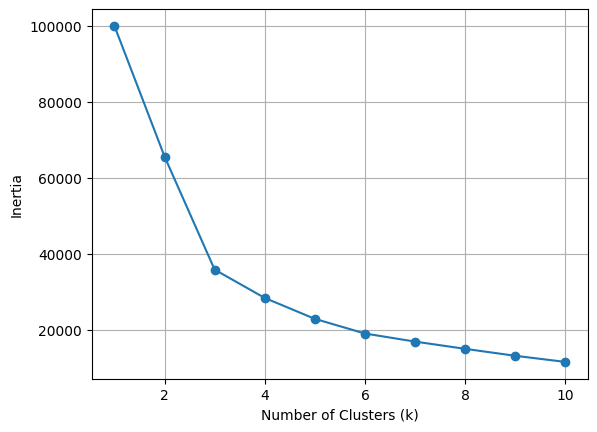

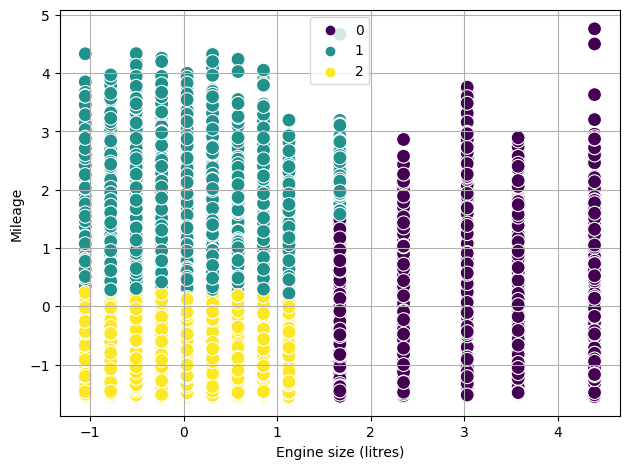

In [50]:
#Apply function to df for engine size and mileage features
kmeans_engine_mileage = execute_kmeans_clustering(df, feature_names_6)

fig1, ax1, fig2, ax2 = kmeans_engine_mileage
fig1.savefig('kmeans_engine_mileage_1.png')
fig2.savefig('kmeans_engine_mileage_2.png')

Optimal number of clusters: 2
Silhouette Score: 0.6182
Davies-Bouldin Score: 0.9419


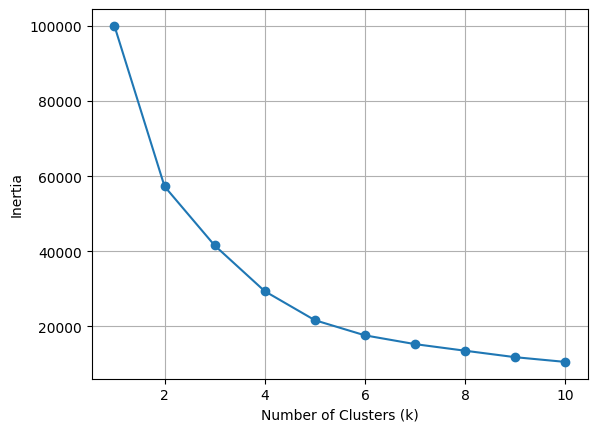

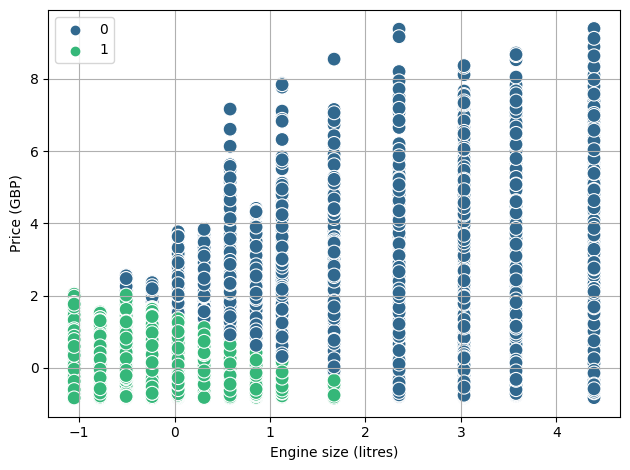

In [51]:
#Apply function to df for engine size and price features
kmeans_engine_price = execute_kmeans_clustering(df, feature_names_7)

fig1, ax1, fig2, ax2 = kmeans_engine_price
fig1.savefig('kmeans_engine_price_1.png')
fig2.savefig('kmeans_engine_price_2.png')

Optimal number of clusters: 2
Silhouette Score: 0.4869
Davies-Bouldin Score: 0.7596


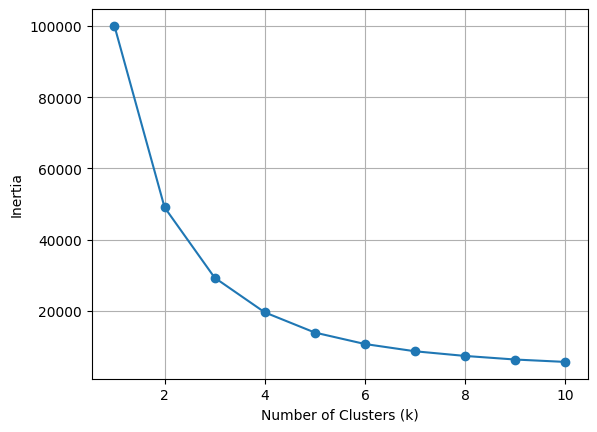

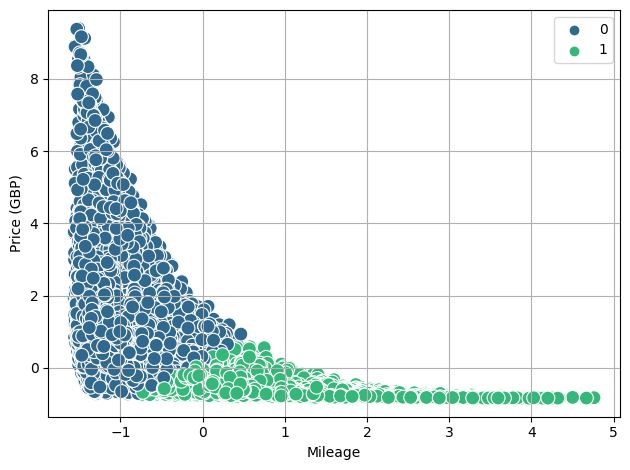

In [52]:
#Apply function to df for mileage and price features
kmeans_mileage_price = execute_kmeans_clustering(df, feature_names_8)

fig1, ax1, fig2, ax2 = kmeans_mileage_price
fig1.savefig('kmeans_mileage_price_1.png')
fig2.savefig('kmeans_mileage_price_2.png')

**Summary of Kmeans clustering on numerical features**

The best k-Means clustering was for year of manufacture and mileage (Optimal number of clusters: 2, Silhouette Score: 0.5334, Davies-Bouldin Score: 0.6585) and year of manufacture and price (Optimal number of clusters: 2, Silhouette Score: 0.5480, Davies-Bouldin Score: 0.6780)

Silhouette score was best for year of manufacture vs price (indicating most compactness of individual clusters (intra cluster distance) and separation amongst clusters (inter cluster distance)). However, Davies-Bouldin score was better for year of manufacture versus mileage (with lowest within-cluster variation and highest between-cluster separation).

Given that the difference in the Davies-Bouldin score is relatively small, the Kmeans model for year of manufacture and price gives a better clustering result overall.

**Comparison of KMeans with other clustering models**

Compare the results of the k-Means clustering model to at least one other clustering algorithm. Determine the algorithm producing the best clustering using suitable evaluation metrics to justify choice.

Clustering methods chosen are Agglomerative Hierarchical Clustering and Means shift because these clustering methods handle noise and are less sensitive to the density of clusters. The data is reasonably noisy so DBSCAN may not effectively cluster. 

Choosing year of manufacture vs price (feature_names_5) to compare as showed best Kmeans clustering.

**Agglomerative Hierarchical clustering**

Reference:

Scikit learn (n. d.) sklearn.cluster.AgglomerativeClustering. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html [Accessed 13/12/2023].

Complete linkage measures the maximum distance between all pairs of observations from two clusters. It tends to produce compact clusters with similar sizes. This will be examined first.

*Complete linkage*

In [53]:
#Import the AgglomerativeClustering model from the sklearn library.
#from sklearn.cluster import AgglomerativeClustering
#Code function for agg clustering to determine optimal k over k_range and then apply dataset and feature names
def calc_optimal_k_agglomerative(data, k_range, linkage):
    """
    Calculate silhouette scores and Davies-Bouldin scores for different numbers of clusters (k) in Agglomerative Clustering.

    Parameters:
    data (pd.DataFrame): The input data containing features.
    k_range (range): Range of values for the number of clusters (k).
    linkage (str): The linkage criterion to use in the Agglomerative Clustering model.

    Returns:
    s_scores (list): Silhouette scores for each value of k.
    db_scores (list): Davies-Bouldin scores for each value of k.
    linkage_values (list): Cluster labels for each value of k.
    """
    s_scores = []
    db_scores = []
    linkage_values = []

    for k in k_range:
        #Create prediction model using complete linkage
        agg_model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        cluster_labels = agg_model.fit_predict(data)
        
        #Determine evaluation metric scores
        silhouette = silhouette_score(data, cluster_labels)
        davies_bouldin = davies_bouldin_score(data, cluster_labels)
        
        #Add to lists
        s_scores.append(silhouette)
        db_scores.append(davies_bouldin)
        linkage_values.append(agg_model.labels_)

    return s_scores, db_scores, linkage_values

def execute_agglomerative_clustering(data, feature_names, linkage='complete'):
    """
    Execute Agglomerative Clustering on the given data using specified linkage and determine the optimal number of clusters.

    Parameters:
    data (pd.DataFrame): The input data containing features.
    feature_names (list): Names of the features to be used for clustering.
    linkage (str, optional): The linkage criterion to use in the Agglomerative Clustering model. Default is 'complete'.

    Returns:
    fig1, ax1 (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot): Figure and axes for the Silhouette Score plot.
    fig2, ax2 (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot): Figure and axes for the Davies-Bouldin Score plot.
    fig3, ax3 (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot): Figure and axes for the final scatter plot.
    """
    #Scale the data
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data[feature_names])

    #Define a range of k values
    k_range = range(2, 11)

    #Find the optimal k using the silhouette Score and Davies-Bouldin Score
    s_scores, db_scores, linkage_values = calc_optimal_k_agglomerative(x_scaled, k_range, linkage)

    #Plot silhouette_scores
    fig1, ax1 = plt.subplots()
    ax1.plot(k_range, s_scores, marker='o')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Silhouette Score')
    
    #Plot davies_bouldin_scores
    fig2, ax2 = plt.subplots()
    ax2.plot(k_range, db_scores, marker='o')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Davies-Bouldin Score')

    #Find the optimal number of clusters based on Silhouette Score
    optimal_k_s = k_range[np.argmax(s_scores)]
    print(f"Optimal number of clusters based on Silhouette Score: {optimal_k_s}")
    
    #Find the optimal number of clusters based on Davies-Bouldin Score
    optimal_k_db = k_range[np.argmin(db_scores)]
    print(f"Optimal number of clusters based on Davies-Bouldin Score: {optimal_k_db}")
    
    #Print optimal Silhouette and Davies-Bouldin Score as well
    print(f"Optimal Silhouette Score: {max(s_scores)} for k={optimal_k_s}")
    print(f"Optimal Davies-Bouldin Score: {min(db_scores)} for k={optimal_k_db}")

    #Create the final Agglomerative Hierarchical Clustering model with the optimal number of clusters using optimal_k_s
    final_agg_model = AgglomerativeClustering(n_clusters=optimal_k_s, linkage=linkage)
    final_agg_model.fit(x_scaled)

    #Predict cluster labels
    cluster_labels_pred = final_agg_model.labels_

    #Print scatter plot
    data_with_clusters = pd.DataFrame(data=x_scaled, columns=feature_names)
    data_with_clusters['Cluster'] = cluster_labels_pred

    fig3, ax3 = plt.subplots()
    sns.scatterplot(data=data_with_clusters, x=feature_names[0], y=feature_names[1], hue=cluster_labels_pred, palette='viridis', s=100, ax=ax3)
    plt.grid(True)
    plt.tight_layout()
    
    return fig1, ax1, fig2, ax2, fig3, ax3

Optimal number of clusters based on Silhouette Score: 2
Optimal number of clusters based on Davies-Bouldin Score: 2
Optimal Silhouette Score: 0.690660664445566 for k=2
Optimal Davies-Bouldin Score: 0.44473086207011603 for k=2


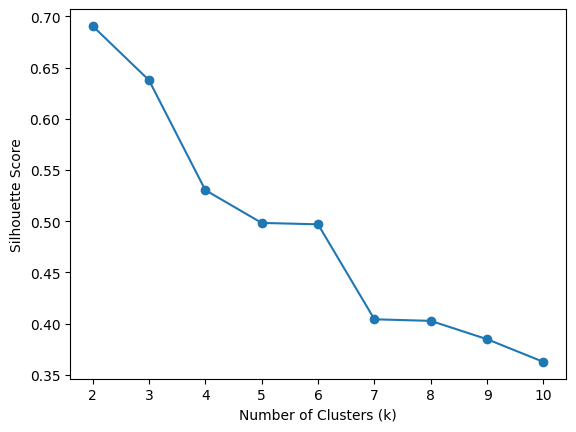

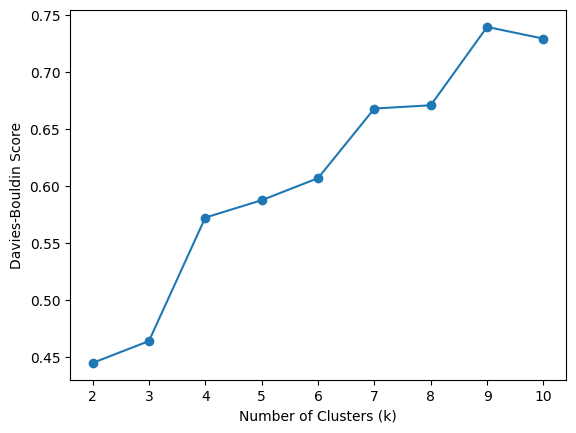

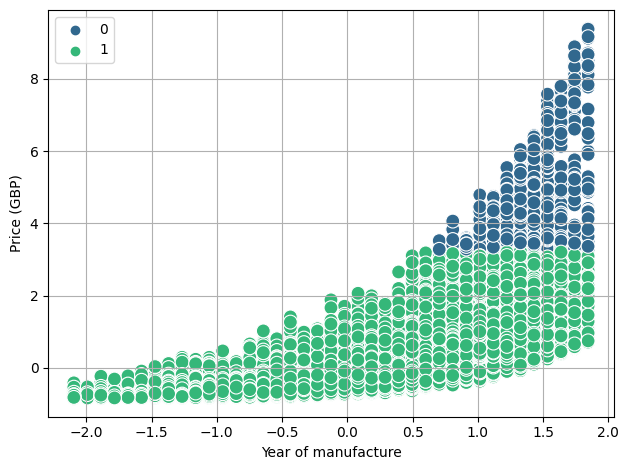

In [54]:
#Run for year of manufacture and mileage with complete linkage
agg_clustering_year_price_complink = execute_agglomerative_clustering(df, feature_names_5)

fig1, ax1, fig2, ax2, fig3, ax3 = agg_clustering_year_price_complink
fig1.savefig('agg_clustering_year_price_complink_1.png')
fig2.savefig('agg_clustering_year_price_complink_2.png')
fig3.savefig('agg_clustering_year_price_complink_3.png')

*Average linkage*

Optimal number of clusters based on Silhouette Score: 2
Optimal number of clusters based on Davies-Bouldin Score: 3
Optimal Silhouette Score: 0.6490988074013216 for k=2
Optimal Davies-Bouldin Score: 0.46097672822425534 for k=3


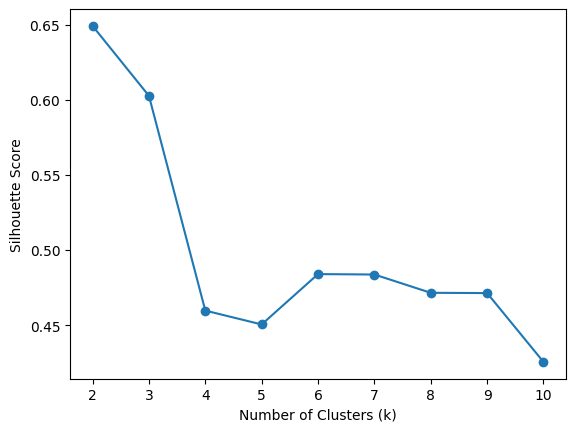

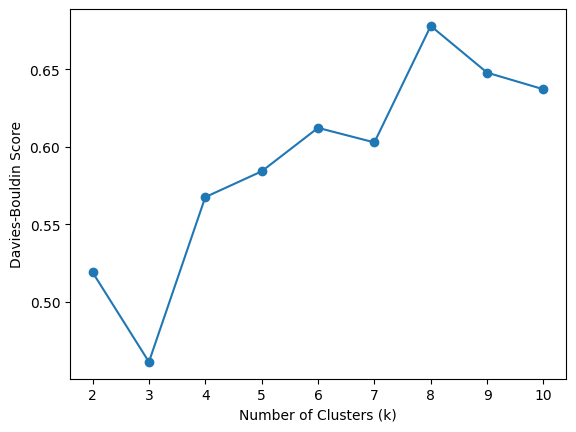

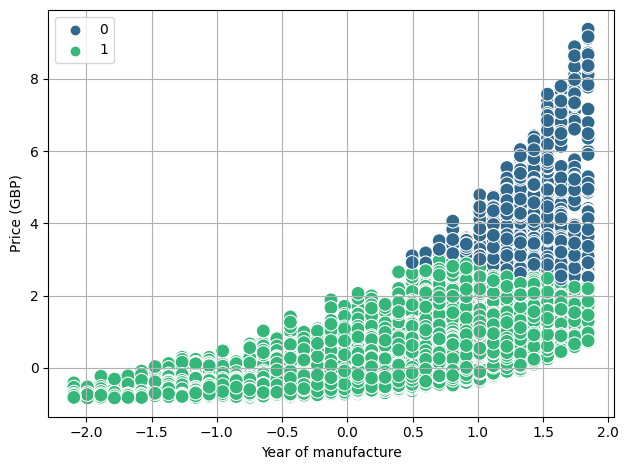

In [55]:
#Run for year of manufacture and mileage with complete linkage
agg_clustering_year_price_averlink = execute_agglomerative_clustering(df, feature_names_5, linkage='average')

fig1, ax1, fig2, ax2, fig3, ax3 = agg_clustering_year_price_averlink
fig1.savefig('agg_clustering_year_price_averlink_1.png')
fig2.savefig('agg_clustering_year_price_averlink_2.png')
fig3.savefig('agg_clustering_year_price_averlink_3.png')

Average linkage produces slightly poorer clustering indicated by lower silhouette score and higher DB score.

*Single linkage*

Optimal number of clusters based on Silhouette Score: 2
Optimal number of clusters based on Davies-Bouldin Score: 2
Optimal Silhouette Score: 0.821084754823874 for k=2
Optimal Davies-Bouldin Score: 0.13570473386474038 for k=2


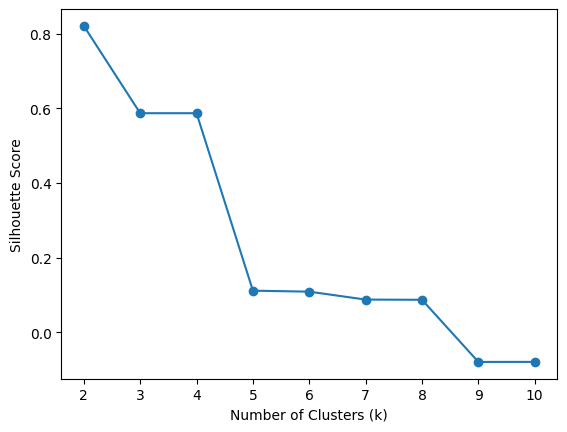

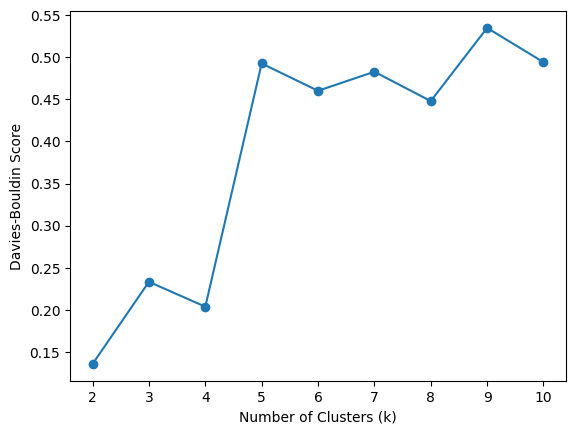

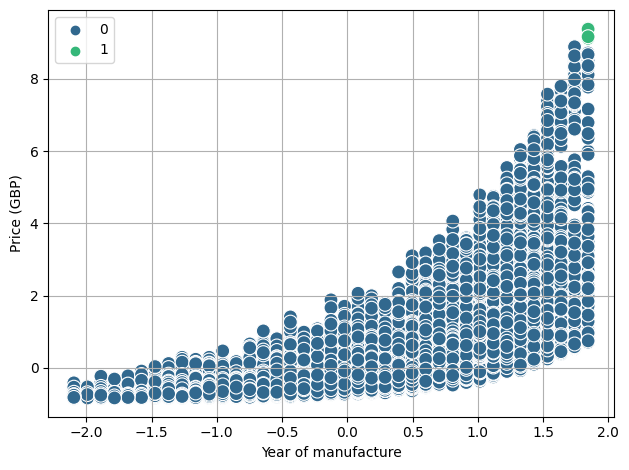

In [56]:
#Run for year of manufacture and mileage with complete linkage
agg_clustering_year_price_singlink = execute_agglomerative_clustering(df, feature_names_5, linkage='single')

fig1, ax1, fig2, ax2, fig3, ax3 = agg_clustering_year_price_singlink
fig1.savefig('agg_clustering_year_price_singlink_1.png')
fig2.savefig('agg_clustering_year_price_singlink_2.png')
fig3.savefig('agg_clustering_year_price_singlink_3.png')

Single linkage demonstrate the best silhouette and DB score but as you can see from the plot, a very small number of data points are included in the second cluster so the distribution of clusters is completely different to those produced by complete and average linkage.

This is also a very different clustering compared to the k-Means clustering. The second cluster accounts for very little data and the first cluster captures the majority of the data points. The data is not well-separated so single linkage may connect distant points, resulting in elongated clusters.

Going to try Min max scaling (A different scaling approach to standardscaler) with complete linkage.

*Try Minmax scaler with complete linkage*

In [57]:
def execute_agglomerative_clustering_minmax(data, feature_names, linkage='complete'):
    """
    Execute Agglomerative Clustering on the given data using MinMax scaling and specified linkage, and determine the optimal number of clusters.

    Parameters:
    data (pd.DataFrame): The input data containing features.
    feature_names (list): Names of the features to be used for clustering.
    linkage (str, optional): The linkage criterion to use in the Agglomerative Clustering model. Default is 'complete'.

    Returns:
    fig1, ax1 (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot): Figure and axes for the Silhouette Score plot.
    fig2, ax2 (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot): Figure and axes for the Davies-Bouldin Score plot.
    fig3, ax3 (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot): Figure and axes for the final scatter plot.
    """
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(data[feature_names])

    #Define a range of k values
    k_range = range(2, 11)

    #Find the optimal k using the silhouette Score and Davies-Bouldin Score
    s_scores, db_scores, linkage_values = calc_optimal_k_agglomerative(x_scaled, k_range, linkage)

    #Plot silhouette_scores
    fig1, ax1 = plt.subplots()
    ax1.plot(k_range, s_scores, marker='o')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Silhouette Score')
    
    #Plot davies_bouldin_scores
    fig2, ax2 = plt.subplots()
    ax2.plot(k_range, db_scores, marker='o')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Davies-Bouldin Score')

    #Find the optimal number of clusters based on Silhouette Score
    optimal_k_s = k_range[np.argmax(s_scores)]
    print(f"Optimal number of clusters based on Silhouette Score: {optimal_k_s}")
    
    #Find the optimal number of clusters based on Davies-Bouldin Score
    optimal_k_db = k_range[np.argmin(db_scores)]
    print(f"Optimal number of clusters based on Davies-Bouldin Score: {optimal_k_db}")
    
    #Print optimal Silhouette and Davies-Bouldin Score as well
    print(f"Optimal Silhouette Score: {max(s_scores)} for k={optimal_k_s}")
    print(f"Optimal Davies-Bouldin Score: {min(db_scores)} for k={optimal_k_db}")

    #Create the final Agglomerative Hierarchical Clustering model with the optimal number of clusters using optimal_k_s
    final_agg_model = AgglomerativeClustering(n_clusters=optimal_k_s, linkage=linkage)
    final_agg_model.fit(x_scaled)

    #Predict cluster labels
    cluster_labels_pred = final_agg_model.labels_

    #Print scatter plot
    data_with_clusters = pd.DataFrame(data=x_scaled, columns=feature_names)
    data_with_clusters['Cluster'] = cluster_labels_pred

    fig3, ax3 = plt.subplots()
    sns.scatterplot(data=data_with_clusters, x=feature_names[0], y=feature_names[1], hue=cluster_labels_pred, palette='viridis', s=100, ax=ax3)
    plt.grid(True)
    plt.tight_layout()
    
    return fig1, ax1, fig2, ax2, fig3, ax3

Optimal number of clusters based on Silhouette Score: 2
Optimal number of clusters based on Davies-Bouldin Score: 3
Optimal Silhouette Score: 0.4971673282028467 for k=2
Optimal Davies-Bouldin Score: 0.5433257778614616 for k=3


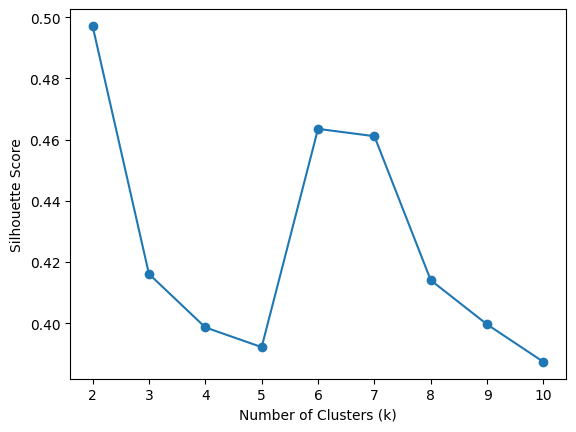

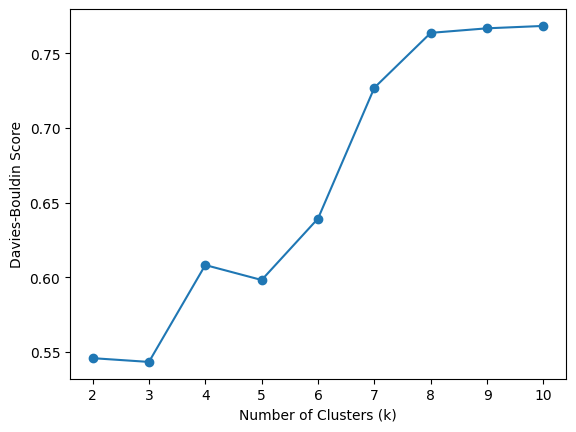

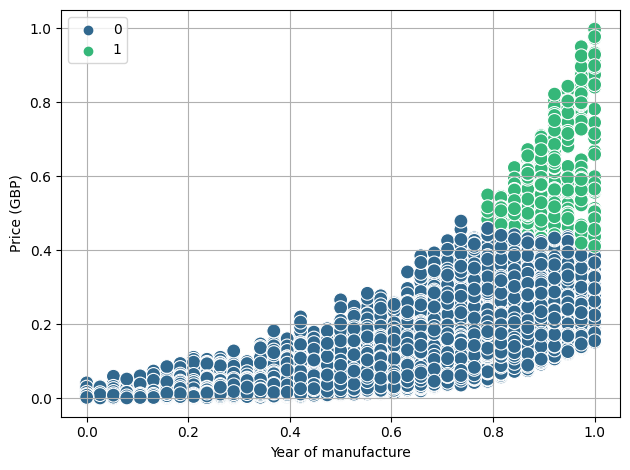

In [58]:
#Run for year of manufacture and mileage with complete linkage and MinMaxScaler
agg_clustering_year_price_compllink_minmax = execute_agglomerative_clustering_minmax(df, feature_names_5)

fig1, ax1, fig2, ax2, fig3, ax3 = agg_clustering_year_price_compllink_minmax
fig1.savefig('agg_clustering_year_price_compllink_minmax_1.png')
fig2.savefig('agg_clustering_year_price_compllink_minmax_2.png')
fig3.savefig('agg_clustering_year_price_compllink_minmax_3.png')

**Summary of Agglomerative Hierarhical Clustering**

Minmax scaler reduced the s and DB score copared to standard scaler with complete linkage. The single linkage provided a second cluster that only accounted for very few data points. This yielded better evaluation metrics but provided very different clustering compared to k-Means.

Complete linkage provided 2 clusters with similar number of data points. Clustering is going to be chllaneging due to the wide variance and distibution of the data points, with no visual separation between clusters.

**Meanshift**

Reference:

Scikit learn (n. d.) sklearn.cluster.MeanShift. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html [Accessed 14/12/2023].

Adapts to the shape of the data and does not require specifying the number of clusters. However, is computationally more demanding and the bandwidth parameter needs to be tuned.

In [5]:
def optimize_meanshift_bandwidth(data, feature_names, bandwidths):
    """
    Optimize the bandwidth parameter for Mean Shift clustering using silhouette score and Davies-Bouldin score.

    Parameters:
    data (pd.DataFrame): The input data containing features.
    feature_names (list): Names of the features to be used for clustering.
    bandwidths (list): Grid of bandwidth values to search.

    Returns:
    fig (matplotlib.figure.Figure): The figure displaying the optimal Mean Shift clustering with the scatter plot.
    """
    #Scale the data
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data[feature_names])

    #Perform bandwidth optimization
    best_bandwidth = None
    best_silhouette_score = -1
    best_db_score = float('inf')

    for bandwidth in bandwidths:
        #Mean Shift clustering with the current bandwidth
        meanshift = MeanShift(bandwidth=bandwidth)
        meanshift_labels_pred = meanshift.fit_predict(x_scaled)

        #Calculate silhouette score
        silhouette_score_value = silhouette_score(x_scaled, meanshift_labels_pred)

        #Calculate Davies-Bouldin score
        db_score = davies_bouldin_score(x_scaled, meanshift_labels_pred)

        #Check if the current bandwidth results in better scores
        if silhouette_score_value > best_silhouette_score and db_score < best_db_score:
            best_silhouette_score = silhouette_score_value
            best_db_score = db_score
            best_bandwidth = bandwidth

    print("Optimal Bandwidth:", best_bandwidth)
    print("Silhouette Score:", best_silhouette_score)
    print("Davies-Bouldin Score:", best_db_score)

    #Perform Mean Shift clustering with the optimal bandwidth
    optimal_meanshift = MeanShift(bandwidth=best_bandwidth)
    optimal_labels_pred = optimal_meanshift.fit_predict(x_scaled)

    #Print scatter plot
    data_with_clusters = pd.DataFrame(data=x_scaled, columns=feature_names)
    data_with_clusters['Cluster'] = optimal_labels_pred

    fig, ax = plt.subplots()
    sns.scatterplot(data=data_with_clusters, x=feature_names[0], y=feature_names[1], hue=optimal_labels_pred, palette='viridis', s=100, ax=ax)
    plt.grid(True)
    plt.tight_layout()

    return fig

#Define a grid of bandwidth values to search
bandwidths_to_search = [0.1, 1, 5, 10, 20]

meanshift_year_mileage = optimize_meanshift_bandwidth(df, feature_names_5, bandwidths_to_search)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

**Summary of Meanshift clustering**

Over a wide range of bandwidths (0.1 to 20), the meanshift algorithm was unable to find more than one cluster in contrast to k-Means and agglomerative hierarchical clustering. The number of unique labels in meanshift_labels_pred is only 1. All data points are assigned to the same cluster, and silhouette score cannot be calculated.

Mean Shift may struggle to identify multiple clusters if the underlying data distribution does not have clear density variations or if the clusters are not well-separated. The algorithm is most effective when clusters are separated by regions of lower density.

There are no clear density variations in year of manufacture vs price so Mean Shift might not be the most suitable algorithm.

**DBSCAN**

Reference:

Scikit learn (n. d.) sklearn.cluster.DBSCAN. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html [Accessed 13/12/2023].

In [ ]:
#Import the DBSCAN model from the sklearn library.
#from sklearn.cluster import DBSCAN
#Hyperparameter optimization for DBSCAN using grid search function
def optimize_dbscan_hyperparameters(data, feature_names, param_grid):
    """
    Optimize hyperparameters for DBSCAN clustering using silhouette score and Davies-Bouldin score.

    Parameters:
    data (pd.DataFrame): The input data containing features.
    feature_names (list): Names of the features to be used for clustering.
    param_grid (dict): Grid of hyperparameters to search.

    Returns:
    best_params (dict): The optimal hyperparameters.
    dbscan_labels_pred (numpy.ndarray): The predicted labels using the optimal hyperparameters.
    """
    #Scale the data
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data[feature_names])
    
    #Variables to store best scores and parameters
    best_s_score = -1
    best_db_score = float('inf')
    best_params = None
    
    #Loop over all hyperparameter combinations in the grid
    for params in ParameterGrid(param_grid):
        #DBSCAN model with the current hyperparameters
        dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
        dbscan_labels_pred = dbscan.fit_predict(x_scaled)
        
        #Print unique labels assigned by DBSCAN
        print("Unique labels assigned by DBSCAN:", np.unique(dbscan_labels_pred))

        #Calculate the silhouette Score and Davies-Bouldin Score
        s_score = silhouette_score(x_scaled, dbscan_labels_pred)
        db_score = davies_bouldin_score(x_scaled, dbscan_labels_pred)
        
        #Check if the current combination of hyperparameters results in better scores
        if s_score > best_s_score and db_score < best_db_score:
            best_s_score = s_score
            best_db_score = db_score
            best_params = params
    
    print("Optimal Hyperparameters:")
    print(best_params)
    print("Silhouette Score:", best_s_score)
    print("Davies-Bouldin Score:", best_db_score)
    
    return best_params, dbscan_labels_pred

#Define a grid of hyperparameters to search
param_grid = {
    'eps': [0.1, 0.5, 1.0, 1.5, 2.0],
    'min_samples': [3, 5, 10]
}

In [18]:
#Run for year of manufacture and mileage 
DBSCAN_year_mileage_opt = optimize_dbscan_hyperparameters(df, feature_names_5, param_grid)

Unique labels assigned by DBSCAN: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86]
Unique labels assigned by DBSCAN: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78]
Unique labels assigned by DBSCAN: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72]
Unique labels assigned by DBSCAN: [0]


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

#Code function to input df, feature names, and optimised hyperparameters eps and min_samples
def execute_dbscan_clustering(data, feature_names, eps, min_samples):
    """
    Execute DBSCAN clustering on the given data using specified hyperparameters.

    Parameters:
    data (pd.DataFrame): The input data containing features.
    feature_names (list): Names of the features to be used for clustering.
    eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    min_samples (int): The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

    Returns:
    fig (matplotlib.figure.Figure): The scatter plot displaying the DBSCAN clustering results.
    """
    #Scale the data
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data[feature_names])
   
    #Create a DBSCAN model with optmised hyperparameters
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    
    #Fit the DBSCAN model and obtain cluster labels
    dbscan_labels_pred = dbscan.fit_predict(x_scaled)
    
    #Calculate the Davies-Bouldin Score and silhouette Score
    db_score = davies_bouldin_score(x_scaled, dbscan_labels_pred)
    s_score = silhouette_score(x_scaled, dbscan_labels_pred)
    
    #Create a df to store the scaled data and cluster labels
    data_with_clusters = pd.DataFrame(data=x_scaled, columns=feature_names)
    data_with_clusters['Cluster'] = dbscan_labels_pred
    
    #Print scatter plot
    fig, ax = plt.figure()
    sns.scatterplot(data=data_with_clusters, x=feature_names[0], y=feature_names[1], hue=dbscan_labels_pred, palette='viridis', s=100)
    plt.grid(True)
    plt.tight_layout()
    
    return fig

#Run for year of manufacture and mileage
DBSCAN_year_mileage = execute_dbscan_clustering(df, feature_names_5, eps=0.5, min_samples=5)

**Summary of DBSCAN**

DBSCAN is effective when there are clear density variations in the data. If the clusters are not well-separated or if there are varying densities within a single cluster, DBSCAN might not perform as expected. DBSCAN has only identified 1 cluster as for Mean shift. This is because there is not clear density separation in the data.

**Summary of Unsupervised Clustering Models**

The best Kmeans clustering was for year of manufacture and mileage (Optimal number of clusters: 2, Silhouette Score: 0.5334, Davies-Bouldin Score: 0.6585) and year of manufacture and price (Optimal number of clusters: 2, Silhouette Score: 0.5480, Davies-Bouldin Score: 0.6780)

Silhouette score was best for year of manufacture vs price (indicating most compactness of individual clusters (intra cluster distance) and separation amongst clusters (inter cluster distance)). However, Davies-Bouldin score was better for year of manufacture versus mileage (with lowest within-cluster variation and highest between-cluster separation).

Given that the difference in the Davies-Bouldin score is relatively small, the Kmeans model for year of manufacture and price gives a better clustering result overall. This was chosen for comparison with other clustering models.

Complete linkage agglomerative_clustering with k2 clusters (optimised) had Silhouette Score: 0.69 and Davies-Bouldin Score: 0.44 and had improve clustering over k-means clustering.

Single linkage indicated better performance compared to complete linkage, optimised with k2 clusters, but the second cluster accounted for very few data points.

Means shift and DBSCAN clustering was unable to identify more than 1 cluster for the data, likely due to the distribution of the data meaning there was no clear separation in density for successful clustering.